## Building The Country Page Widgets

Charlie has added the following dataset to the **PRODUCTION** API for the construction of the new country pages widgets. This notebook details how to query these datasets to create a the required widgets.


Note: many queries will be repeated, but the data used in different ways, so we should cache the responses for re-use.

```
{'dataset': '499682b1-3174-493f-ba1a-368b4636708e'}
```

### Table of Contents

0. [Global metadata etc](#s0)
1. [Tree Cover Widgets + Dynamic Sentences](#s1)
2. [FAO Forest Widget](#s2)
3. [Tree Cover Loss Widget](#s3)
4. [Loss 'Stacked Bars' Widget](#s4)
5. [Loss Dynamic Sentence](#s5)
6. [Header Dynamic Sentence](#s6)
7. [Tree Cover Gain Dynamic Sentence and Ranked List](#s7)
8. [FAO Rate of Reforestation and Ranked List](#s8)
9. [Ranked Extent / Donut Widget](#s9)
10. [Ranked Extent Dynamic Sentence](#s10)
11. [Ranked Loss / Donut Widget](#s11)
11. [Ranked Loss Dynamic Sentence](#s12)
11. [Ranked Gain / Donut Widget](#s13)
11. [Ranked Gain Dynamic Sentence](#s14)
11. [Plantations Area Widget (by Type)](#s15)
11. [Plantations Dynamic Sentnce (by Type)](#s16)
11. [Plantations Area Widget (by Species)](#s17)
11. [Plantations Dynamic Sentnce (by Species)](#s18)



https://production-api.globalforestwatch.org/v1/query/?sql=SELECT polyname, year_data.year, sum(year_data.area_loss) as sum FROM data WHERE polyname = 'wdpa'  and iso = 'BRA' GROUP BY polyname, iso, nested(year_data.year)


In [1]:
import requests
import requests_cache
from pprint import pprint
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
requests_cache.install_cache('demo_cache')

Testing basic queries

**notes**

* New table structure includes `bound1-4` which provide an additional attribute to group by

```
https://production-api.globalforestwatch.org/v1/query/499682b1-3174-493f-ba1a-368b4636708e?sql=SELECT polyname, count(*) FROM data WHERE iso = 'BRA' and thresh = 30 GROUP BY polyname
```

This one table should be enough to generate data for areas of interest from admin0 to admin 2 level on its own.

In [2]:
ds = '499682b1-3174-493f-ba1a-368b4636708e'  # ADMIN 2 level data

In [3]:
# Example of what is in the data tables and how to simply read them:
url = f"https://production-api.globalforestwatch.org/v1/query/{ds}"
#sql = (f"SELECT sum(area_gain) FROM {ds} WHERE iso = 'BRA' and adm1 = 7 AND thresh = 0 AND polyname = 'gadm28'")
#sql = (f"SELECT polyname, count(*) FROM {ds} WHERE iso = 'BRA' and thresh = 30 GROUP BY polyname")
sql = (f"SELECT * FROM {ds} WHERE iso = 'BRA' AND thresh = 30 AND polyname = 'plantations' LIMIT 2 ORDER BY area_extent DESC")
properties = {"sql": sql}
r = requests.get(url, params = properties)
print(r.url)
print(f'Status: {r.status_code}')
r.json()

https://production-api.globalforestwatch.org/v1/query/499682b1-3174-493f-ba1a-368b4636708e?sql=SELECT+%2A+FROM+499682b1-3174-493f-ba1a-368b4636708e+WHERE+iso+%3D+%27BRA%27+AND+thresh+%3D+30+AND+polyname+%3D+%27plantations%27+LIMIT+2+ORDER+BY+area_extent+DESC
Status: 200


{'data': [{'_id': 'AWBQThBRplLZ87Mw_Qjd',
   'adm1': 16,
   'adm2': 3135,
   'area_extent': 51210.668501199994,
   'area_gadm28': 122698.669597,
   'area_gain': 33512.1868198,
   'area_poly_aoi': 55806.6311051,
   'bound1': 'Large industrial plantation',
   'bound2': 'Wood fiber / timber',
   'bound3': -9999,
   'bound4': -9999,
   'iso': 'BRA',
   'polyname': 'plantations',
   'thresh': 30,
   'year_data': [{'area_loss': 798.678183005,
     'emissions': 109296.72327999999,
     'year': 2001},
    {'area_loss': 2713.08876427, 'emissions': 375777.542814, 'year': 2002},
    {'area_loss': 2054.33129683,
     'emissions': 290411.23737600003,
     'year': 2003},
    {'area_loss': 2492.50763937, 'emissions': 349251.142067, 'year': 2004},
    {'area_loss': 3463.94844168, 'emissions': 498386.009671, 'year': 2005},
    {'area_loss': 3470.62419473, 'emissions': 498039.658034, 'year': 2006},
    {'area_loss': 2084.34156043, 'emissions': 301050.55028, 'year': 2007},
    {'area_loss': 3159.59334272

The `polyname` attribute in the data indicates the geometry used in the intersection. E.g. `polyname`:`gadm28` means that the GADM28 polygons alone were used, therefore `area_extent` would be the value of the Hansen 2010 tree cover extent within a particular gadm28 geometry.

Charlie has used a convention of mutliple underscores to indicate when data has multiple intersects. The rule is as follows:
* All data are intersected with the gadm28
* Some data are intersected with gadam + something else, in that case it takes the name of the something else, e.g. plantations
* some data are intersected with multiple gadam + multiple other data sources, in that case, the data sources are seperated by a dunder (double underscore) in the `polyname`. E.g. `primary_forest__landmark` are the gadam28 + primary forest data + landmark 

In [4]:
url = f"https://production-api.globalforestwatch.org/v1/query/{ds}"
sql = (f"SELECT polyname FROM {ds} WHERE iso = 'BRA' and thresh = 0 GROUP BY polyname")
properties = {"sql": sql}
r = requests.get(url, params = properties)
print(r.url)
print(f'Status: {r.status_code}')
for row in r.json().get('data'):
    print(row.get('polyname'))

https://production-api.globalforestwatch.org/v1/query/499682b1-3174-493f-ba1a-368b4636708e?sql=SELECT+polyname+FROM+499682b1-3174-493f-ba1a-368b4636708e+WHERE+iso+%3D+%27BRA%27+and+thresh+%3D+0+GROUP+BY+polyname
Status: 200
gadm28
bra_biomes
mining
plantations
wdpa
plantations__mining
primary_forest
primary_forest__mining
primary_forest__wdpa
plantations__wdpa
ifl_2013
ifl_2013__wdpa
ifl_2013__mining
landmark
primary_forest__landmark
plantations__landmark


Also of note, is the `bound1-4` attributes, which are 

```
   'bound1': 'Large industrial plantation',
   'bound2': 'Wood fiber / timber',
   'bound3': -9999,
   'bound4': -9999,
   
```

These hold extra properties of a dataset which can be used in group-by statements, e.g. plantation data has been split into species type. 

Finally, another key property is the `area_poly_aoi`, which should hold the total area (ha) of the shape used to make the intersection. E.g., the sum of the `polyname` = gadm28 `area_poly_aoi` values should equal the total land area of a selected ROI. 


<a id='s0'></a>
# Obtain metadata for admin-0 to admin-2 level

Retrieve json mappings of id values (e.g. iso codes or integers) for admin0 to admin2 level, and map them to english names for selectors and resources to build dynamic sentences.

In [5]:
def get_admin0_json(urlCarto="https://wri-01.carto.com/api/v2/sql"):
    """return an alphabetical json of mappings of iso and country names
    e.g.
    [{'iso': 'AFG', 'name': 'Afghanistan'},
     {'iso': 'XAD', 'name': 'Akrotiri and Dhekelia'},
     {'iso': 'ALA', 'name': 'Åland'},
     ...
    ]
    
    """
    sql = ("SELECT iso, country as name FROM umd_nat_staging "
            "GROUP BY iso, name "
            "ORDER BY name "
          )
    r = requests.get(urlCarto, params={"q": sql})
    return r.json().get('rows', None)
 

def get_admin1_json(iso, urlCarto="https://wri-01.carto.com/api/v2/sql"):
    """return an alphabetical json of mappings of admin1 for a country
    e.g. for iso='GBR'
        [{'adm1': 1, 'name': 'England'},
         {'adm1': 2, 'name': 'Northern Ireland'},
         {'adm1': 3, 'name': 'Scotland'},
         {'adm1': 4, 'name': 'Wales'}]
    """
    sql = ("SELECT id1 as adm1, region as name "
            "FROM umd_subnat_staging "
            f"WHERE iso = '{iso}' "
            "and year = 2001 "
            "and thresh = 30 "
            "ORDER BY name "
          )
    r = requests.get(urlCarto, params={"q": sql})
    return r.json().get('rows', None)
   

def get_admin2_json(iso, adm1, urlCarto="https://wri-01.carto.com/api/v2/sql"):
    """ 
    e.g. response for iso='GBR' adm1=1
    [{'adm2': 1, 'name': 'Barking and Dagenham'},
     {'adm2': 2, 'name': 'Bath and North East Somerset'},
     ...
     ]

    """
    sql = ("SELECT id_2 as adm2, name_2 as name "
            "FROM gadm28_adm2 "
            f"WHERE iso = '{iso}' "
            f"AND id_1 = {adm1} "
            "ORDER BY name "
          )
    r = requests.get(urlCarto, params={"q": sql})    
    return r.json().get('rows', None)

In [6]:
tmp = get_admin0_json()
iso_to_countries = {}
for row in tmp:
    iso_to_countries[row.get('iso')] = row.get('name')

# Get info on an areas shape

Use the Geostore service to find the geometry, bounding box or additional info on a given `iso` or `iso/admin1` area if required (e.g. for centering the map).

Note - if similar info is needed for admin2 areas I will have to go back and create a query based on a Carto table, as admin-2 level data does not exist in the geostore service yet.

In [7]:
iso = "GBR"
adm1 = None 

if not adm1:
    print("returning admin-0 level geostore")
    url = f"https://api.resourcewatch.org/v1/geostore/admin/{iso}"
else:
    print("returning admin-1 level geostore")
    url = f"https://api.resourcewatch.org/v1/geostore/admin/{iso}/{adm1}"
    
r = requests.get(url)
print(r.url)
roi = r.json()

print(roi.get('data', None).get('attributes', None).keys())
roi.get('data').get('attributes').get('bbox')  #e.g. of getting the bounding box of a ROI

returning admin-0 level geostore
https://api.resourcewatch.org/v1/geostore/admin/GBR
dict_keys(['geojson', 'hash', 'provider', 'areaHa', 'bbox', 'lock', 'info'])


[-13.6913900375365, 49.8654174804688, 1.76416802406322, 60.8458213806153]

In [8]:
def create_bounding_poly(bbox):
    """Create a bounding polygon from a returned bbox of the geostore service
        (- the old api produced shapes in this format).
    """
    lat1, lon1, lat2, lon2  = bbox
    return [[lat1,lon1], [lat1,lon2],[lat2,lon2],[lat2,lon1] ,[lat1,lon1]]

In [9]:
create_bounding_poly(roi.get('data').get('attributes').get('bbox'))

[[-13.6913900375365, 49.8654174804688],
 [-13.6913900375365, 60.8458213806153],
 [1.76416802406322, 60.8458213806153],
 [1.76416802406322, 49.8654174804688],
 [-13.6913900375365, 49.8654174804688]]

# Set up global (scope) data sources for the Country Widgets 

There is some work that needs to be done in populating the Location menu, not all options should be always available: some of them will need to be iso dependent. E.g. `Biomes` should only appear in the menu if the ISO is set to `BRA`


In [10]:
polynames = {
                'All Region':'gadm28',
                'Biomes':'bra_biomes',
                'Mining':'mining',
                'Protected Areas':'wdpa',
                'Primary Forests':'primary_forest',
                'Mining in Primary Forests':'primary_forest__mining',
                'Protected Areas in Primary Forests':'primary_forest__wdpa',
                'Intact Forest Landscapes':'ifl_2013',
                'Protected Areas in Intact Forest Landscapes':'ifl_2013__wdpa',
                'Mining in Intact Forest Landscapes':'ifl_2013__mining',
                'Indigenous Lands':'landmark',
                'Indigenous Lands in Primary Forests':'primary_forest__landmark',
                'Plantations':'plantations',
                'Mining in Plantation Areas':'plantations__mining',
                'Protected areas in Plantations':'plantations__wdpa',
                'Indigenous Lands in Plantations':'plantations__landmark',
            }

plantation_type_dict = {
    
                         'Large industrial plantation': 'large industrial',
                         'Clearing/ very young plantation': 'clearing or very young',
                         'Mosaic of medium-sized plantations': 'medium-sized',
                         'Mosaic of small-sized plantations': 'small sized'

                        }

plantation_species_dict = {
                            'Wood fiber / timber': 'wood fiber and timber',
                            'Wood fiber / timber mix': 'mixed wood fiber and timber',
                            'Recently cleared': 'recently cleared',
                            'Unknown': 'unknown',
                            'Fruit': 'fruit tree',
                            'Fruit mix': 'mixed fruit tree',
                            'Oil palm': 'palm tree',
                            'Other mix': 'mixed',
                            'Other': 'other',
                            'Rubber': 'rubber tree'
                            }


tabs = {
         "summary":"Summary",
         "land_cover":"Land Cover",
         "land_use"
         "forest_change": "Forest Change",
         "conservation":'Conservation',
         "people":"People",
         "climate":"Climate"
        }


# Dynamic Whitelists Tests

In [11]:
# Create whitelist for each polyname

url = f"https://production-api.globalforestwatch.org/v1/query/{ds}"
sql = (f"SELECT iso, polyname FROM {ds} WHERE thresh = 0 AND polyname is not 'gadm28'")

properties = {"sql": sql}
r = requests.get(url, params = properties)
print(r.url)
print(f'Status: {r.status_code}')
data = r.json().get('data')
pprint(data)

https://production-api.globalforestwatch.org/v1/query/499682b1-3174-493f-ba1a-368b4636708e?sql=SELECT+iso%2C+polyname+FROM+499682b1-3174-493f-ba1a-368b4636708e+WHERE+thresh+%3D+0+AND+polyname+is+not+%27gadm28%27
Status: 200
[{'_id': 'AWB5lRnDhRfkUZCTZzqy', 'iso': 'IDN', 'polyname': 'plantations'},
 {'_id': 'AWB5lRnDhRfkUZCTZzqz', 'iso': 'IDN', 'polyname': 'plantations'},
 {'_id': 'AWB5lRnDhRfkUZCTZzq7', 'iso': 'IDN', 'polyname': 'plantations'},
 {'_id': 'AWB5lRnDhRfkUZCTZzrL', 'iso': 'IDN', 'polyname': 'plantations__wdpa'},
 {'_id': 'AWB5lRnDhRfkUZCTZzrh', 'iso': 'IDN', 'polyname': 'plantations'},
 {'_id': 'AWB5lRnDhRfkUZCTZzs7', 'iso': 'IDN', 'polyname': 'plantations__wdpa'},
 {'_id': 'AWB5lRnDhRfkUZCTZzuB',
  'iso': 'IDN',
  'polyname': 'plantations__oil_palm'},
 {'_id': 'AWB5lRnDhRfkUZCTZzuZ',
  'iso': 'IDN',
  'polyname': 'plantations__idn_forest_moratorium'},
 {'_id': 'AWB5lRnDhRfkUZCTZzwo', 'iso': 'IDN', 'polyname': 'plantations'},
 {'_id': 'AWB5lRnDhRfkUZCTZzwy',
  'iso': 'IDN',

 {'_id': 'AWB5lRnJhRfkUZCTZ1j1', 'iso': 'BRA', 'polyname': 'plantations'},
 {'_id': 'AWB5lRnJhRfkUZCTZ1j9', 'iso': 'BRA', 'polyname': 'plantations'},
 {'_id': 'AWB5lRnJhRfkUZCTZ1j-', 'iso': 'BRA', 'polyname': 'plantations'},
 {'_id': 'AWB5lRnJhRfkUZCTZ1kO', 'iso': 'BRA', 'polyname': 'plantations'},
 {'_id': 'AWB5lRnJhRfkUZCTZ1kP', 'iso': 'BRA', 'polyname': 'plantations'},
 {'_id': 'AWB5lRnJhRfkUZCTZ1kR', 'iso': 'BRA', 'polyname': 'plantations'},
 {'_id': 'AWB5lRnJhRfkUZCTZ1kS', 'iso': 'BRA', 'polyname': 'plantations'},
 {'_id': 'AWB5lRnJhRfkUZCTZ1kd', 'iso': 'BRA', 'polyname': 'plantations'},
 {'_id': 'AWB5lRnJhRfkUZCTZ1ke', 'iso': 'BRA', 'polyname': 'plantations'},
 {'_id': 'AWB5lRnJhRfkUZCTZ1kh', 'iso': 'BRA', 'polyname': 'plantations'},
 {'_id': 'AWB5lRnJhRfkUZCTZ1ki', 'iso': 'BRA', 'polyname': 'plantations'},
 {'_id': 'AWB5lRnJhRfkUZCTZ1kn', 'iso': 'BRA', 'polyname': 'plantations'},
 {'_id': 'AWB5lRnJhRfkUZCTZ1ku', 'iso': 'BRA', 'polyname': 'plantations'},
 {'_id': 'AWB5lRnJhRfkUZC

  'polyname': 'plantations__mining'},
 {'_id': 'AWB5lRnLhRfkUZCTZ2P2',
  'iso': 'BRA',
  'polyname': 'plantations__mining'},
 {'_id': 'AWB5lRnLhRfkUZCTZ2P6',
  'iso': 'BRA',
  'polyname': 'plantations__mining'},
 {'_id': 'AWB5lRnLhRfkUZCTZ2QB',
  'iso': 'BRA',
  'polyname': 'plantations__mining'},
 {'_id': 'AWB5lRnLhRfkUZCTZ2QC',
  'iso': 'BRA',
  'polyname': 'plantations__mining'},
 {'_id': 'AWB5lRnLhRfkUZCTZ2QF',
  'iso': 'BRA',
  'polyname': 'plantations__mining'},
 {'_id': 'AWB5lRnLhRfkUZCTZ2QN',
  'iso': 'BRA',
  'polyname': 'plantations__mining'},
 {'_id': 'AWB5lRnLhRfkUZCTZ2QT',
  'iso': 'BRA',
  'polyname': 'plantations__mining'},
 {'_id': 'AWB5lRnLhRfkUZCTZ2QU',
  'iso': 'BRA',
  'polyname': 'plantations__mining'},
 {'_id': 'AWB5lRnLhRfkUZCTZ2QX',
  'iso': 'BRA',
  'polyname': 'plantations__mining'},
 {'_id': 'AWB5lRnLhRfkUZCTZ2QZ',
  'iso': 'BRA',
  'polyname': 'plantations__mining'},
 {'_id': 'AWB5lRnLhRfkUZCTZ2Qh',
  'iso': 'BRA',
  'polyname': 'plantations__mining'},
 {'_i

  'iso': 'IDN',
  'polyname': 'plantations__idn_forest_moratorium'},
 {'_id': 'AWB5lVc-hRfkUZCTaFtL',
  'iso': 'IDN',
  'polyname': 'plantations__idn_forest_moratorium'},
 {'_id': 'AWB5lVc-hRfkUZCTaFtM',
  'iso': 'IDN',
  'polyname': 'plantations__idn_forest_moratorium'},
 {'_id': 'AWB5lVc-hRfkUZCTaFtR',
  'iso': 'IDN',
  'polyname': 'plantations__idn_forest_moratorium'},
 {'_id': 'AWB5lRnShRfkUZCTZ3xE',
  'iso': 'IDN',
  'polyname': 'plantations__oil_palm'},
 {'_id': 'AWB5lRnShRfkUZCTZ3xI',
  'iso': 'IDN',
  'polyname': 'plantations__oil_palm'},
 {'_id': 'AWB5lRnShRfkUZCTZ3xJ',
  'iso': 'IDN',
  'polyname': 'plantations__oil_palm'},
 {'_id': 'AWB5lRnThRfkUZCTZ3yG',
  'iso': 'IDN',
  'polyname': 'plantations__oil_palm'},
 {'_id': 'AWB5lRnWhRfkUZCTZ4Xr', 'iso': 'IDN', 'polyname': 'plantations__wdpa'},
 {'_id': 'AWB5lRnWhRfkUZCTZ4Xu', 'iso': 'IDN', 'polyname': 'plantations__wdpa'},
 {'_id': 'AWB5lRnWhRfkUZCTZ4Xx', 'iso': 'IDN', 'polyname': 'plantations__wdpa'},
 {'_id': 'AWB5lRnWhRfkUZCT

 {'_id': 'AWB5lc1AhRfkUZCTaho1', 'iso': 'IDN', 'polyname': 'plantations'},
 {'_id': 'AWB5lc1AhRfkUZCTahpS', 'iso': 'IDN', 'polyname': 'plantations'},
 {'_id': 'AWB5lc1AhRfkUZCTahpV', 'iso': 'IDN', 'polyname': 'plantations'},
 {'_id': 'AWB5lc1AhRfkUZCTahpa', 'iso': 'IDN', 'polyname': 'plantations'},
 {'_id': 'AWB5lc1AhRfkUZCTahpe', 'iso': 'KHM', 'polyname': 'plantations'},
 {'_id': 'AWB5lc1AhRfkUZCTahpf', 'iso': 'KHM', 'polyname': 'plantations'},
 {'_id': 'AWB5lc1AhRfkUZCTahpj', 'iso': 'IDN', 'polyname': 'plantations'},
 {'_id': 'AWB5lc1AhRfkUZCTahpo', 'iso': 'IDN', 'polyname': 'plantations'},
 {'_id': 'AWB5lc1AhRfkUZCTahps', 'iso': 'IDN', 'polyname': 'plantations'},
 {'_id': 'AWB5lc1AhRfkUZCTahpv', 'iso': 'IDN', 'polyname': 'plantations'},
 {'_id': 'AWB5lc1AhRfkUZCTahpw', 'iso': 'IDN', 'polyname': 'plantations'},
 {'_id': 'AWB5lc1AhRfkUZCTahpy', 'iso': 'KHM', 'polyname': 'plantations'},
 {'_id': 'AWB5lc1AhRfkUZCTahpz', 'iso': 'KHM', 'polyname': 'plantations'},
 {'_id': 'AWB5lc1AhRfkUZC

 {'_id': 'AWB5lgPXhRfkUZCTav0E', 'iso': 'IDN', 'polyname': 'plantations'},
 {'_id': 'AWB5lgPXhRfkUZCTav0Y', 'iso': 'BRA', 'polyname': 'plantations'},
 {'_id': 'AWB5lgPXhRfkUZCTav0f', 'iso': 'BRA', 'polyname': 'plantations'},
 {'_id': 'AWB5lgPXhRfkUZCTav0j', 'iso': 'BRA', 'polyname': 'plantations'},
 {'_id': 'AWB5lgPXhRfkUZCTav0t', 'iso': 'BRA', 'polyname': 'plantations'},
 {'_id': 'AWB5lgPXhRfkUZCTav0x', 'iso': 'BRA', 'polyname': 'plantations'},
 {'_id': 'AWB5lgPXhRfkUZCTav1N', 'iso': 'BRA', 'polyname': 'plantations'},
 {'_id': 'AWB5lgPXhRfkUZCTav1R', 'iso': 'BRA', 'polyname': 'plantations'},
 {'_id': 'AWB5lgPXhRfkUZCTav1T', 'iso': 'BRA', 'polyname': 'plantations'},
 {'_id': 'AWB5lgPXhRfkUZCTav1W', 'iso': 'BRA', 'polyname': 'plantations'},
 {'_id': 'AWB5lgPXhRfkUZCTav1p', 'iso': 'BRA', 'polyname': 'plantations'},
 {'_id': 'AWB5lgPXhRfkUZCTav1v', 'iso': 'BRA', 'polyname': 'plantations'},
 {'_id': 'AWB5lgPXhRfkUZCTav12', 'iso': 'BRA', 'polyname': 'plantations'},
 {'_id': 'AWB5lgPXhRfkUZC

  'iso': 'IDN',
  'polyname': 'plantations__idn_mys_peatlands'},
 {'_id': 'AWB5ljmphRfkUZCTa9dD',
  'iso': 'IDN',
  'polyname': 'plantations__idn_mys_peatlands'},
 {'_id': 'AWB5ljmphRfkUZCTa9dE',
  'iso': 'IDN',
  'polyname': 'plantations__idn_mys_peatlands'},
 {'_id': 'AWB5ljmphRfkUZCTa9dJ',
  'iso': 'IDN',
  'polyname': 'plantations__oil_palm'},
 {'_id': 'AWB5ljmphRfkUZCTa9dY',
  'iso': 'IDN',
  'polyname': 'plantations__idn_mys_peatlands'},
 {'_id': 'AWB5ljmphRfkUZCTa9da',
  'iso': 'IDN',
  'polyname': 'plantations__idn_mys_peatlands'},
 {'_id': 'AWB5ljmphRfkUZCTa9eH',
  'iso': 'IDN',
  'polyname': 'plantations__idn_mys_peatlands'},
 {'_id': 'AWB5ljmphRfkUZCTa9eK',
  'iso': 'IDN',
  'polyname': 'plantations__idn_mys_peatlands'},
 {'_id': 'AWB5ljmphRfkUZCTa9eL',
  'iso': 'IDN',
  'polyname': 'plantations__idn_mys_peatlands'},
 {'_id': 'AWB5ljmphRfkUZCTa9eP',
  'iso': 'IDN',
  'polyname': 'plantations__idn_mys_peatlands'},
 {'_id': 'AWB5ljmphRfkUZCTa9eS',
  'iso': 'IDN',
  'polyname':

 {'_id': 'AWB5lmvshRfkUZCTbLl8',
  'iso': 'IDN',
  'polyname': 'primary_forest__oil_palm'},
 {'_id': 'AWB5lmvshRfkUZCTbLl_',
  'iso': 'IDN',
  'polyname': 'primary_forest__oil_palm'},
 {'_id': 'AWB5lmvshRfkUZCTbLmB',
  'iso': 'IDN',
  'polyname': 'primary_forest__oil_palm'},
 {'_id': 'AWB5lmvshRfkUZCTbLmG',
  'iso': 'IDN',
  'polyname': 'primary_forest__oil_palm'},
 {'_id': 'AWB5lmvshRfkUZCTbLmQ',
  'iso': 'IDN',
  'polyname': 'primary_forest__oil_palm'},
 {'_id': 'AWB5lmvshRfkUZCTbLmb',
  'iso': 'IDN',
  'polyname': 'primary_forest__oil_palm'},
 {'_id': 'AWB5lmvshRfkUZCTbLmi',
  'iso': 'IDN',
  'polyname': 'primary_forest__oil_palm'},
 {'_id': 'AWB5lmvshRfkUZCTbLmj',
  'iso': 'IDN',
  'polyname': 'primary_forest__oil_palm'},
 {'_id': 'AWB5lmvshRfkUZCTbLmq',
  'iso': 'IDN',
  'polyname': 'primary_forest__oil_palm'},
 {'_id': 'AWB5lmvshRfkUZCTbLnL',
  'iso': 'IDN',
  'polyname': 'primary_forest__oil_palm'},
 {'_id': 'AWB5lmvshRfkUZCTbLnN',
  'iso': 'IDN',
  'polyname': 'primary_forest__

 {'_id': 'AWB5lqEPhRfkUZCTbaOX',
  'iso': 'BRA',
  'polyname': 'primary_forest__mining'},
 {'_id': 'AWB5lqEPhRfkUZCTbaOY',
  'iso': 'BRA',
  'polyname': 'primary_forest__mining'},
 {'_id': 'AWB5lqEPhRfkUZCTbaOd',
  'iso': 'BRA',
  'polyname': 'primary_forest__mining'},
 {'_id': 'AWB5lqEPhRfkUZCTbaOi',
  'iso': 'BRA',
  'polyname': 'primary_forest__mining'},
 {'_id': 'AWB5lqEPhRfkUZCTbaOr',
  'iso': 'BRA',
  'polyname': 'primary_forest__mining'},
 {'_id': 'AWB5lqEPhRfkUZCTbaPA',
  'iso': 'BRA',
  'polyname': 'primary_forest__mining'},
 {'_id': 'AWB5lqEPhRfkUZCTbaPF',
  'iso': 'BRA',
  'polyname': 'primary_forest__mining'},
 {'_id': 'AWB5lqEPhRfkUZCTbaPJ',
  'iso': 'BRA',
  'polyname': 'primary_forest__mining'},
 {'_id': 'AWB5lqEPhRfkUZCTbaPM',
  'iso': 'BRA',
  'polyname': 'primary_forest__mining'},
 {'_id': 'AWB5lqEPhRfkUZCTbaPa',
  'iso': 'BRA',
  'polyname': 'primary_forest__mining'},
 {'_id': 'AWB5lqEPhRfkUZCTbaPb',
  'iso': 'BRA',
  'polyname': 'primary_forest__mining'},
 {'_id': '

  'polyname': 'primary_forest__idn_forest_moratorium'},
 {'_id': 'AWB5lqEUhRfkUZCTbcHY',
  'iso': 'IDN',
  'polyname': 'primary_forest__idn_forest_moratorium'},
 {'_id': 'AWB5lqEUhRfkUZCTbcHb',
  'iso': 'IDN',
  'polyname': 'primary_forest__idn_forest_moratorium'},
 {'_id': 'AWB5lqEYhRfkUZCTbdUn', 'iso': 'COL', 'polyname': 'mining'},
 {'_id': 'AWB5lqEYhRfkUZCTbdUq', 'iso': 'COL', 'polyname': 'mining'},
 {'_id': 'AWB5lqEYhRfkUZCTbdUs', 'iso': 'COL', 'polyname': 'mining'},
 {'_id': 'AWB5lqEYhRfkUZCTbdUv', 'iso': 'COL', 'polyname': 'mining'},
 {'_id': 'AWB5lqEYhRfkUZCTbdU-', 'iso': 'COL', 'polyname': 'mining'},
 {'_id': 'AWB5lqEYhRfkUZCTbdVO', 'iso': 'COL', 'polyname': 'mining'},
 {'_id': 'AWB5lqEYhRfkUZCTbdVQ', 'iso': 'COL', 'polyname': 'mining'},
 {'_id': 'AWB5lqEYhRfkUZCTbdVV', 'iso': 'COL', 'polyname': 'mining'},
 {'_id': 'AWB5lqEYhRfkUZCTbdVf', 'iso': 'COL', 'polyname': 'mining'},
 {'_id': 'AWB5lqEYhRfkUZCTbdVg', 'iso': 'COL', 'polyname': 'mining'},
 {'_id': 'AWB5lqEYhRfkUZCTbdVl', '

 {'_id': 'AWB5lwNAhRfkUZCTby9S', 'iso': 'BRA', 'polyname': 'mining'},
 {'_id': 'AWB5lwNAhRfkUZCTby9W', 'iso': 'BRA', 'polyname': 'mining'},
 {'_id': 'AWB5lwNAhRfkUZCTby9Y', 'iso': 'BRA', 'polyname': 'mining'},
 {'_id': 'AWB5lwNAhRfkUZCTby9a', 'iso': 'BRA', 'polyname': 'mining'},
 {'_id': 'AWB5lwNAhRfkUZCTby9b', 'iso': 'BRA', 'polyname': 'mining'},
 {'_id': 'AWB5lwNAhRfkUZCTby91', 'iso': 'BRA', 'polyname': 'mining'},
 {'_id': 'AWB5lwNAhRfkUZCTby93', 'iso': 'BRA', 'polyname': 'mining'},
 {'_id': 'AWB5lwNAhRfkUZCTby-F', 'iso': 'BRA', 'polyname': 'mining'},
 {'_id': 'AWB5lwNAhRfkUZCTby-I', 'iso': 'BRA', 'polyname': 'mining'},
 {'_id': 'AWB5lwNAhRfkUZCTby-N', 'iso': 'BRA', 'polyname': 'mining'},
 {'_id': 'AWB5lwNAhRfkUZCTby-j', 'iso': 'BRA', 'polyname': 'mining'},
 {'_id': 'AWB5lwNAhRfkUZCTby-r', 'iso': 'BRA', 'polyname': 'mining'},
 {'_id': 'AWB5lwNAhRfkUZCTby-w', 'iso': 'BRA', 'polyname': 'mining'},
 {'_id': 'AWB5lwNAhRfkUZCTby-0', 'iso': 'BRA', 'polyname': 'mining'},
 {'_id': 'AWB5lwNAhR

 {'_id': 'AWB5mJ9ihRfkUZCTdlfL', 'iso': 'ROU', 'polyname': 'wdpa'},
 {'_id': 'AWB5mJ9ihRfkUZCTdlfU', 'iso': 'ROU', 'polyname': 'wdpa'},
 {'_id': 'AWB5mJ9ihRfkUZCTdlfX', 'iso': 'ROU', 'polyname': 'wdpa'},
 {'_id': 'AWB5mJ9ihRfkUZCTdlfY', 'iso': 'ROU', 'polyname': 'wdpa'},
 {'_id': 'AWB5mJ9ihRfkUZCTdlfm', 'iso': 'ROU', 'polyname': 'wdpa'},
 {'_id': 'AWB5mJ9ihRfkUZCTdlfs', 'iso': 'ROU', 'polyname': 'wdpa'},
 {'_id': 'AWB5mJ9ihRfkUZCTdlfu', 'iso': 'ROU', 'polyname': 'wdpa'},
 {'_id': 'AWB5mJ9ihRfkUZCTdlfz', 'iso': 'ROU', 'polyname': 'wdpa'},
 {'_id': 'AWB5mJ9ihRfkUZCTdlf3', 'iso': 'ROU', 'polyname': 'wdpa'},
 {'_id': 'AWB5mJ9ihRfkUZCTdlf5', 'iso': 'ROU', 'polyname': 'wdpa'},
 {'_id': 'AWB5mJ9ihRfkUZCTdlf9', 'iso': 'ROU', 'polyname': 'wdpa'},
 {'_id': 'AWB5mJ9ihRfkUZCTdlgD', 'iso': 'ROU', 'polyname': 'wdpa'},
 {'_id': 'AWB5mJ9jhRfkUZCTdlgJ', 'iso': 'ROU', 'polyname': 'wdpa'},
 {'_id': 'AWB5mJ9jhRfkUZCTdlgT', 'iso': 'ROU', 'polyname': 'wdpa'},
 {'_id': 'AWB5mJ9jhRfkUZCTdlgW', 'iso': 'ROU', '

 {'_id': 'AWB5mNt4hRfkUZCTd10I',
  'iso': 'BRA',
  'polyname': 'primary_forest__wdpa'},
 {'_id': 'AWB5mNt4hRfkUZCTd10P',
  'iso': 'BRA',
  'polyname': 'primary_forest__wdpa'},
 {'_id': 'AWB5mNt4hRfkUZCTd10R',
  'iso': 'BRA',
  'polyname': 'primary_forest__wdpa'},
 {'_id': 'AWB5mNt4hRfkUZCTd10a',
  'iso': 'BRA',
  'polyname': 'primary_forest__wdpa'},
 {'_id': 'AWB5mNt4hRfkUZCTd10f',
  'iso': 'BRA',
  'polyname': 'primary_forest__wdpa'},
 {'_id': 'AWB5mNt4hRfkUZCTd10h',
  'iso': 'BRA',
  'polyname': 'primary_forest__wdpa'},
 {'_id': 'AWB5mNt4hRfkUZCTd10p',
  'iso': 'BRA',
  'polyname': 'primary_forest__wdpa'},
 {'_id': 'AWB5mNt4hRfkUZCTd10q',
  'iso': 'BRA',
  'polyname': 'primary_forest__wdpa'},
 {'_id': 'AWB5mNt4hRfkUZCTd101',
  'iso': 'BRA',
  'polyname': 'primary_forest__wdpa'},
 {'_id': 'AWB5mNt4hRfkUZCTd106',
  'iso': 'BRA',
  'polyname': 'primary_forest__wdpa'},
 {'_id': 'AWB5mNt4hRfkUZCTd10_',
  'iso': 'BRA',
  'polyname': 'primary_forest__wdpa'},
 {'_id': 'AWB5mNt4hRfkUZCTd11C',

 {'_id': 'AWB5mNt5hRfkUZCTd2Kb',
  'iso': 'BRA',
  'polyname': 'primary_forest__wdpa'},
 {'_id': 'AWB5mNt5hRfkUZCTd2Kd',
  'iso': 'BRA',
  'polyname': 'primary_forest__wdpa'},
 {'_id': 'AWB5mNt5hRfkUZCTd2Kj',
  'iso': 'BRA',
  'polyname': 'primary_forest__wdpa'},
 {'_id': 'AWB5mNt5hRfkUZCTd2Kn',
  'iso': 'IDN',
  'polyname': 'primary_forest__wdpa'},
 {'_id': 'AWB5mNt5hRfkUZCTd2Kx',
  'iso': 'IDN',
  'polyname': 'primary_forest__wdpa'},
 {'_id': 'AWB5mNt5hRfkUZCTd2K4',
  'iso': 'IDN',
  'polyname': 'primary_forest__wdpa'},
 {'_id': 'AWB5mNt5hRfkUZCTd2K6',
  'iso': 'IDN',
  'polyname': 'primary_forest__wdpa'},
 {'_id': 'AWB5mNt5hRfkUZCTd2K8',
  'iso': 'IDN',
  'polyname': 'primary_forest__wdpa'},
 {'_id': 'AWB5mNt5hRfkUZCTd2LH',
  'iso': 'IDN',
  'polyname': 'primary_forest__wdpa'},
 {'_id': 'AWB5mNt5hRfkUZCTd2LQ',
  'iso': 'IDN',
  'polyname': 'primary_forest__wdpa'},
 {'_id': 'AWB5mNt5hRfkUZCTd2LU',
  'iso': 'IDN',
  'polyname': 'primary_forest__wdpa'},
 {'_id': 'AWB5mNt5hRfkUZCTd2LW',

 {'_id': 'AWB5mQPdhRfkUZCTd9fb', 'iso': 'NGA', 'polyname': 'wdpa'},
 {'_id': 'AWB5mQPdhRfkUZCTd9fg', 'iso': 'NGA', 'polyname': 'wdpa'},
 {'_id': 'AWB5mQPdhRfkUZCTd9fk', 'iso': 'NIC', 'polyname': 'wdpa'},
 {'_id': 'AWB5mQPdhRfkUZCTd9fl', 'iso': 'NIC', 'polyname': 'wdpa'},
 {'_id': 'AWB5mQPdhRfkUZCTd9fn', 'iso': 'NIC', 'polyname': 'wdpa'},
 {'_id': 'AWB5mQPdhRfkUZCTd9fp', 'iso': 'NIC', 'polyname': 'wdpa'},
 {'_id': 'AWB5mQPdhRfkUZCTd9fs', 'iso': 'NIC', 'polyname': 'wdpa'},
 {'_id': 'AWB5mQPdhRfkUZCTd9fv', 'iso': 'NIC', 'polyname': 'wdpa'},
 {'_id': 'AWB5mQPdhRfkUZCTd9f0', 'iso': 'NIC', 'polyname': 'wdpa'},
 {'_id': 'AWB5mQPdhRfkUZCTd9f2', 'iso': 'NIC', 'polyname': 'wdpa'},
 {'_id': 'AWB5mQPdhRfkUZCTd9f3', 'iso': 'NIC', 'polyname': 'wdpa'},
 {'_id': 'AWB5mQPdhRfkUZCTd9f6', 'iso': 'NIC', 'polyname': 'wdpa'},
 {'_id': 'AWB5mQPdhRfkUZCTd9f_', 'iso': 'NIC', 'polyname': 'wdpa'},
 {'_id': 'AWB5mQPdhRfkUZCTd9gA', 'iso': 'NIC', 'polyname': 'wdpa'},
 {'_id': 'AWB5mQPdhRfkUZCTd9gB', 'iso': 'NIC', '

 {'_id': 'AWB5mQPhhRfkUZCTd_Vd', 'iso': 'GAB', 'polyname': 'wdpa'},
 {'_id': 'AWB5mQPhhRfkUZCTd_Vh', 'iso': 'GBR', 'polyname': 'wdpa'},
 {'_id': 'AWB5mQPhhRfkUZCTd_Vr', 'iso': 'GAB', 'polyname': 'wdpa'},
 {'_id': 'AWB5mQPhhRfkUZCTd_Vt', 'iso': 'GAB', 'polyname': 'wdpa'},
 {'_id': 'AWB5mQPhhRfkUZCTd_Vu', 'iso': 'GAB', 'polyname': 'wdpa'},
 {'_id': 'AWB5mQPhhRfkUZCTd_Vx', 'iso': 'GAB', 'polyname': 'wdpa'},
 {'_id': 'AWB5mQPhhRfkUZCTd_V2', 'iso': 'GAB', 'polyname': 'wdpa'},
 {'_id': 'AWB5mQPhhRfkUZCTd_V4', 'iso': 'GAB', 'polyname': 'wdpa'},
 {'_id': 'AWB5mQPhhRfkUZCTd_V9', 'iso': 'GAB', 'polyname': 'wdpa'},
 {'_id': 'AWB5mQPhhRfkUZCTd_V_', 'iso': 'GAB', 'polyname': 'wdpa'},
 {'_id': 'AWB5mQPhhRfkUZCTd_WR', 'iso': 'FIN', 'polyname': 'wdpa'},
 {'_id': 'AWB5mQPhhRfkUZCTd_WU', 'iso': 'FIN', 'polyname': 'wdpa'},
 {'_id': 'AWB5mQPhhRfkUZCTd_Wa', 'iso': 'FIN', 'polyname': 'wdpa'},
 {'_id': 'AWB5mQPhhRfkUZCTd_Wb', 'iso': 'FIN', 'polyname': 'wdpa'},
 {'_id': 'AWB5mQPhhRfkUZCTd_Wf', 'iso': 'FIN', '

 {'_id': 'AWB5nMd0hRfkUZCTh15M', 'iso': 'AUS', 'polyname': 'ifl_2013'},
 {'_id': 'AWB5nMd0hRfkUZCTh15Q', 'iso': 'AUS', 'polyname': 'ifl_2013'},
 {'_id': 'AWB5nMd0hRfkUZCTh15S', 'iso': 'AUS', 'polyname': 'ifl_2013'},
 {'_id': 'AWB5nMd0hRfkUZCTh15U', 'iso': 'AUS', 'polyname': 'ifl_2013'},
 {'_id': 'AWB5nMd0hRfkUZCTh15V', 'iso': 'AUS', 'polyname': 'ifl_2013'},
 {'_id': 'AWB5nMd0hRfkUZCTh15Y', 'iso': 'AUS', 'polyname': 'ifl_2013'},
 {'_id': 'AWB5nMd0hRfkUZCTh15j', 'iso': 'AUS', 'polyname': 'ifl_2013'},
 {'_id': 'AWB5nMd0hRfkUZCTh15w', 'iso': 'AUS', 'polyname': 'ifl_2013'},
 {'_id': 'AWB5nMd0hRfkUZCTh15z', 'iso': 'AUS', 'polyname': 'ifl_2013'},
 {'_id': 'AWB5nMd0hRfkUZCTh153', 'iso': 'AUS', 'polyname': 'ifl_2013'},
 {'_id': 'AWB5nMd0hRfkUZCTh155', 'iso': 'AUS', 'polyname': 'ifl_2013'},
 {'_id': 'AWB5nMd0hRfkUZCTh15-', 'iso': 'AUS', 'polyname': 'ifl_2013'},
 {'_id': 'AWB5nMd0hRfkUZCTh16D', 'iso': 'BRA', 'polyname': 'ifl_2013'},
 {'_id': 'AWB5nMd0hRfkUZCTh16K', 'iso': 'BRA', 'polyname': 'ifl_

  'polyname': 'idn_forest_moratorium'},
 {'_id': 'AWB5nSZ7hRfkUZCTiHzj',
  'iso': 'IDN',
  'polyname': 'idn_forest_moratorium'},
 {'_id': 'AWB5nSZ7hRfkUZCTiHzo',
  'iso': 'IDN',
  'polyname': 'idn_forest_moratorium'},
 {'_id': 'AWB5nSZ7hRfkUZCTiHzp',
  'iso': 'IDN',
  'polyname': 'idn_forest_moratorium'},
 {'_id': 'AWB5nSZ7hRfkUZCTiHz2',
  'iso': 'IDN',
  'polyname': 'idn_forest_moratorium'},
 {'_id': 'AWB5nSZ7hRfkUZCTiHz3',
  'iso': 'IDN',
  'polyname': 'idn_forest_moratorium'},
 {'_id': 'AWB5nSZ7hRfkUZCTiHz5',
  'iso': 'IDN',
  'polyname': 'idn_forest_moratorium'},
 {'_id': 'AWB5nSZ7hRfkUZCTiH0B',
  'iso': 'IDN',
  'polyname': 'idn_forest_moratorium'},
 {'_id': 'AWB5nSZ7hRfkUZCTiH0Q',
  'iso': 'IDN',
  'polyname': 'idn_forest_moratorium'},
 {'_id': 'AWB5nSZ7hRfkUZCTiH0S',
  'iso': 'IDN',
  'polyname': 'idn_forest_moratorium'},
 {'_id': 'AWB5nSZ7hRfkUZCTiH0b',
  'iso': 'IDN',
  'polyname': 'idn_forest_moratorium'},
 {'_id': 'AWB5nSZ7hRfkUZCTiH0i',
  'iso': 'IDN',
  'polyname': 'idn_fo

 {'_id': 'AWB5lRnLhRfkUZCTZ2E9',
  'iso': 'BRA',
  'polyname': 'plantations__mining'},
 {'_id': 'AWB5lRnLhRfkUZCTZ2FA',
  'iso': 'BRA',
  'polyname': 'plantations__mining'},
 {'_id': 'AWB5lRnLhRfkUZCTZ2FE',
  'iso': 'BRA',
  'polyname': 'plantations__mining'},
 {'_id': 'AWB5lRnLhRfkUZCTZ2FJ',
  'iso': 'BRA',
  'polyname': 'plantations__mining'},
 {'_id': 'AWB5lRnLhRfkUZCTZ2FK',
  'iso': 'BRA',
  'polyname': 'plantations__mining'},
 {'_id': 'AWB5lRnLhRfkUZCTZ2FL',
  'iso': 'BRA',
  'polyname': 'plantations__mining'},
 {'_id': 'AWB5lRnLhRfkUZCTZ2FR',
  'iso': 'BRA',
  'polyname': 'plantations__mining'},
 {'_id': 'AWB5lRnLhRfkUZCTZ2FS',
  'iso': 'BRA',
  'polyname': 'plantations__mining'},
 {'_id': 'AWB5lRnLhRfkUZCTZ2FY',
  'iso': 'BRA',
  'polyname': 'plantations__mining'},
 {'_id': 'AWB5lRnLhRfkUZCTZ2Fb',
  'iso': 'BRA',
  'polyname': 'plantations__mining'},
 {'_id': 'AWB5lRnLhRfkUZCTZ2Fd',
  'iso': 'BRA',
  'polyname': 'plantations__mining'},
 {'_id': 'AWB5lRnLhRfkUZCTZ2Ff',
  'iso': '

 {'_id': 'AWB5lRnNhRfkUZCTZ2kb',
  'iso': 'BRA',
  'polyname': 'plantations__mining'},
 {'_id': 'AWB5lRnNhRfkUZCTZ2kc',
  'iso': 'BRA',
  'polyname': 'plantations__mining'},
 {'_id': 'AWB5lRnNhRfkUZCTZ2ko',
  'iso': 'BRA',
  'polyname': 'plantations__mining'},
 {'_id': 'AWB5lRnNhRfkUZCTZ2kw',
  'iso': 'BRA',
  'polyname': 'plantations__mining'},
 {'_id': 'AWB5lRnNhRfkUZCTZ2kx',
  'iso': 'BRA',
  'polyname': 'plantations__mining'},
 {'_id': 'AWB5lRnNhRfkUZCTZ2k4',
  'iso': 'BRA',
  'polyname': 'plantations__mining'},
 {'_id': 'AWB5lRnNhRfkUZCTZ2k8',
  'iso': 'BRA',
  'polyname': 'plantations__mining'},
 {'_id': 'AWB5lRnNhRfkUZCTZ2lA',
  'iso': 'BRA',
  'polyname': 'plantations__mining'},
 {'_id': 'AWB5lRnNhRfkUZCTZ2lM',
  'iso': 'BRA',
  'polyname': 'plantations__mining'},
 {'_id': 'AWB5lRnNhRfkUZCTZ2lY',
  'iso': 'BRA',
  'polyname': 'plantations__mining'},
 {'_id': 'AWB5lRnNhRfkUZCTZ2lo',
  'iso': 'BRA',
  'polyname': 'plantations__mining'},
 {'_id': 'AWB5lRnNhRfkUZCTZ2lp',
  'iso': '

  'polyname': 'plantations__idn_forest_moratorium'},
 {'_id': 'AWB5lZifhRfkUZCTaUjP',
  'iso': 'IDN',
  'polyname': 'plantations__idn_forest_moratorium'},
 {'_id': 'AWB5lZifhRfkUZCTaUjW',
  'iso': 'IDN',
  'polyname': 'plantations__idn_forest_moratorium'},
 {'_id': 'AWB5lZifhRfkUZCTaUlg',
  'iso': 'IDN',
  'polyname': 'plantations__idn_mys_peatlands'},
 {'_id': 'AWB5lZifhRfkUZCTaUmZ',
  'iso': 'MYS',
  'polyname': 'plantations__idn_mys_peatlands'},
 {'_id': 'AWB5lZifhRfkUZCTaUme',
  'iso': 'IDN',
  'polyname': 'plantations__idn_mys_peatlands'},
 {'_id': 'AWB5lZifhRfkUZCTaUmi',
  'iso': 'IDN',
  'polyname': 'plantations__idn_mys_peatlands'},
 {'_id': 'AWB5lZifhRfkUZCTaUmk',
  'iso': 'IDN',
  'polyname': 'plantations__idn_mys_peatlands'},
 {'_id': 'AWB5lZifhRfkUZCTaUos', 'iso': 'IDN', 'polyname': 'plantations'},
 {'_id': 'AWB5lZifhRfkUZCTaUow',
  'iso': 'IDN',
  'polyname': 'plantations__idn_mys_peatlands'},
 {'_id': 'AWB5lZifhRfkUZCTaUoz',
  'iso': 'MYS',
  'polyname': 'plantations__idn

  'iso': 'IDN',
  'polyname': 'plantations__oil_palm'},
 {'_id': 'AWB5lgPShRfkUZCTauUn',
  'iso': 'IDN',
  'polyname': 'plantations__oil_palm'},
 {'_id': 'AWB5lgPShRfkUZCTauUq',
  'iso': 'IDN',
  'polyname': 'plantations__oil_palm'},
 {'_id': 'AWB5lgPShRfkUZCTauUu',
  'iso': 'LBR',
  'polyname': 'plantations__oil_palm'},
 {'_id': 'AWB5lgPShRfkUZCTauUv',
  'iso': 'LBR',
  'polyname': 'plantations__oil_palm'},
 {'_id': 'AWB5lgPShRfkUZCTauU3',
  'iso': 'MYS',
  'polyname': 'plantations__oil_palm'},
 {'_id': 'AWB5lgPShRfkUZCTauU8',
  'iso': 'IDN',
  'polyname': 'plantations__oil_palm'},
 {'_id': 'AWB5lgPShRfkUZCTauU-',
  'iso': 'IDN',
  'polyname': 'plantations__oil_palm'},
 {'_id': 'AWB5lgPShRfkUZCTauVH',
  'iso': 'IDN',
  'polyname': 'plantations__oil_palm'},
 {'_id': 'AWB5lgPShRfkUZCTauVL',
  'iso': 'IDN',
  'polyname': 'plantations__oil_palm'},
 {'_id': 'AWB5lgPShRfkUZCTauVO',
  'iso': 'IDN',
  'polyname': 'plantations__oil_palm'},
 {'_id': 'AWB5lgPThRfkUZCTauoi',
  'iso': 'BRA',
  'po

  'iso': 'IDN',
  'polyname': 'plantations__idn_forest_moratorium'},
 {'_id': 'AWB5lgPZhRfkUZCTawa9',
  'iso': 'IDN',
  'polyname': 'plantations__idn_forest_moratorium'},
 {'_id': 'AWB5lgPZhRfkUZCTawbQ',
  'iso': 'IDN',
  'polyname': 'plantations__idn_forest_moratorium'},
 {'_id': 'AWB5lgPZhRfkUZCTawbs',
  'iso': 'IDN',
  'polyname': 'plantations__idn_forest_moratorium'},
 {'_id': 'AWB5lgPZhRfkUZCTawcX',
  'iso': 'IDN',
  'polyname': 'plantations__oil_palm'},
 {'_id': 'AWB5lgPZhRfkUZCTawc-',
  'iso': 'MYS',
  'polyname': 'plantations__oil_palm'},
 {'_id': 'AWB5lgPZhRfkUZCTawc_',
  'iso': 'IDN',
  'polyname': 'plantations__oil_palm'},
 {'_id': 'AWB5lgPZhRfkUZCTawdB',
  'iso': 'IDN',
  'polyname': 'plantations__oil_palm'},
 {'_id': 'AWB5lgPZhRfkUZCTawdF',
  'iso': 'IDN',
  'polyname': 'plantations__oil_palm'},
 {'_id': 'AWB5lgPZhRfkUZCTawda',
  'iso': 'IDN',
  'polyname': 'plantations__oil_palm'},
 {'_id': 'AWB5lgPZhRfkUZCTawdb',
  'iso': 'IDN',
  'polyname': 'plantations__oil_palm'},
 {

 {'_id': 'AWB5ljmphRfkUZCTa9jd', 'iso': 'IDN', 'polyname': 'plantations'},
 {'_id': 'AWB5ljmphRfkUZCTa9je', 'iso': 'IDN', 'polyname': 'plantations'},
 {'_id': 'AWB5ljmphRfkUZCTa9jg', 'iso': 'IDN', 'polyname': 'plantations'},
 {'_id': 'AWB5ljmphRfkUZCTa9jj', 'iso': 'IDN', 'polyname': 'plantations'},
 {'_id': 'AWB5ljmphRfkUZCTa9jl', 'iso': 'IDN', 'polyname': 'plantations'},
 {'_id': 'AWB5ljmphRfkUZCTa9jm', 'iso': 'IDN', 'polyname': 'plantations'},
 {'_id': 'AWB5ljmphRfkUZCTa9kN',
  'iso': 'IDN',
  'polyname': 'plantations__idn_forest_moratorium'},
 {'_id': 'AWB5ljmphRfkUZCTa9kp', 'iso': 'IDN', 'polyname': 'plantations'},
 {'_id': 'AWB5ljmphRfkUZCTa9ks', 'iso': 'MYS', 'polyname': 'plantations'},
 {'_id': 'AWB5ljmphRfkUZCTa9lM', 'iso': 'MYS', 'polyname': 'plantations'},
 {'_id': 'AWB5ljmphRfkUZCTa9lS', 'iso': 'MYS', 'polyname': 'plantations'},
 {'_id': 'AWB5ljmphRfkUZCTa9lV', 'iso': 'MYS', 'polyname': 'plantations'},
 {'_id': 'AWB5ljmphRfkUZCTa9lj', 'iso': 'MYS', 'polyname': 'plantations'}

  'iso': 'IDN',
  'polyname': 'primary_forest__managed_forests'},
 {'_id': 'AWB5lmv6hRfkUZCTbPZI',
  'iso': 'IDN',
  'polyname': 'primary_forest__managed_forests'},
 {'_id': 'AWB5lmv6hRfkUZCTbPZJ',
  'iso': 'IDN',
  'polyname': 'primary_forest__managed_forests'},
 {'_id': 'AWB5lmv6hRfkUZCTbPZN',
  'iso': 'IDN',
  'polyname': 'primary_forest__managed_forests'},
 {'_id': 'AWB5lmv6hRfkUZCTbPZT',
  'iso': 'IDN',
  'polyname': 'primary_forest__managed_forests'},
 {'_id': 'AWB5lmv6hRfkUZCTbPZy',
  'iso': 'IDN',
  'polyname': 'primary_forest__managed_forests'},
 {'_id': 'AWB5lmv6hRfkUZCTbPZ7',
  'iso': 'IDN',
  'polyname': 'primary_forest__managed_forests'},
 {'_id': 'AWB5lmv6hRfkUZCTbPZ_',
  'iso': 'PNG',
  'polyname': 'primary_forest__managed_forests'},
 {'_id': 'AWB5lmv6hRfkUZCTbPaC',
  'iso': 'IDN',
  'polyname': 'primary_forest__managed_forests'},
 {'_id': 'AWB5lmv6hRfkUZCTbPaE',
  'iso': 'IDN',
  'polyname': 'primary_forest__managed_forests'},
 {'_id': 'AWB5lmv6hRfkUZCTbPaL',
  'iso': '

 {'_id': 'AWB5lqEPhRfkUZCTbaSD',
  'iso': 'BRA',
  'polyname': 'primary_forest__mining'},
 {'_id': 'AWB5lqEPhRfkUZCTbaSF',
  'iso': 'BRA',
  'polyname': 'primary_forest__mining'},
 {'_id': 'AWB5lqEPhRfkUZCTbaSJ',
  'iso': 'BRA',
  'polyname': 'primary_forest__mining'},
 {'_id': 'AWB5lqEPhRfkUZCTbaSR',
  'iso': 'BRA',
  'polyname': 'primary_forest__mining'},
 {'_id': 'AWB5lqEPhRfkUZCTbaSS',
  'iso': 'BRA',
  'polyname': 'primary_forest__mining'},
 {'_id': 'AWB5lqEPhRfkUZCTbaSd',
  'iso': 'BRA',
  'polyname': 'primary_forest__mining'},
 {'_id': 'AWB5lqEPhRfkUZCTbaSe',
  'iso': 'BRA',
  'polyname': 'primary_forest__mining'},
 {'_id': 'AWB5lqEPhRfkUZCTbaSj',
  'iso': 'BRA',
  'polyname': 'primary_forest__mining'},
 {'_id': 'AWB5lqEPhRfkUZCTbaSn',
  'iso': 'BRA',
  'polyname': 'primary_forest__mining'},
 {'_id': 'AWB5lqEPhRfkUZCTbaSq',
  'iso': 'BRA',
  'polyname': 'primary_forest__mining'},
 {'_id': 'AWB5lqEPhRfkUZCTbaS1',
  'iso': 'BRA',
  'polyname': 'primary_forest__mining'},
 {'_id': '

 {'_id': 'AWB5lqEZhRfkUZCTbdse', 'iso': 'CAN', 'polyname': 'mining'},
 {'_id': 'AWB5lqEZhRfkUZCTbdsf', 'iso': 'CAN', 'polyname': 'mining'},
 {'_id': 'AWB5lqEZhRfkUZCTbdsj', 'iso': 'CAN', 'polyname': 'mining'},
 {'_id': 'AWB5lqEZhRfkUZCTbdsk', 'iso': 'CAN', 'polyname': 'mining'},
 {'_id': 'AWB5lqEZhRfkUZCTbdsm', 'iso': 'CAN', 'polyname': 'mining'},
 {'_id': 'AWB5lqEZhRfkUZCTbdso', 'iso': 'BRA', 'polyname': 'mining'},
 {'_id': 'AWB5lqEZhRfkUZCTbdsp', 'iso': 'CAN', 'polyname': 'mining'},
 {'_id': 'AWB5lqEZhRfkUZCTbdss', 'iso': 'BRA', 'polyname': 'mining'},
 {'_id': 'AWB5lqEZhRfkUZCTbdsx', 'iso': 'BRA', 'polyname': 'mining'},
 {'_id': 'AWB5lqEZhRfkUZCTbds4', 'iso': 'BRA', 'polyname': 'mining'},
 {'_id': 'AWB5lqEZhRfkUZCTbds7', 'iso': 'BRA', 'polyname': 'mining'},
 {'_id': 'AWB5lqEZhRfkUZCTbds8', 'iso': 'BRA', 'polyname': 'mining'},
 {'_id': 'AWB5lqEZhRfkUZCTbds-', 'iso': 'BRA', 'polyname': 'mining'},
 {'_id': 'AWB5lqEZhRfkUZCTbdtD', 'iso': 'BRA', 'polyname': 'mining'},
 {'_id': 'AWB5lqEZhR

 {'_id': 'AWB5lwNBhRfkUZCTbztu', 'iso': 'CMR', 'polyname': 'managed_forests'},
 {'_id': 'AWB5lwNBhRfkUZCTbzt1', 'iso': 'CMR', 'polyname': 'managed_forests'},
 {'_id': 'AWB5lwNBhRfkUZCTbzt3', 'iso': 'CMR', 'polyname': 'managed_forests'},
 {'_id': 'AWB5lwNBhRfkUZCTbzt5', 'iso': 'CMR', 'polyname': 'managed_forests'},
 {'_id': 'AWB5lzaahRfkUZCTcBsl', 'iso': 'IDN', 'polyname': 'oil_palm'},
 {'_id': 'AWB5lzaahRfkUZCTcBsr', 'iso': 'IDN', 'polyname': 'oil_palm'},
 {'_id': 'AWB5lzaahRfkUZCTcBst', 'iso': 'IDN', 'polyname': 'oil_palm'},
 {'_id': 'AWB5lzaahRfkUZCTcBsv', 'iso': 'IDN', 'polyname': 'oil_palm'},
 {'_id': 'AWB5lzaahRfkUZCTcBsw', 'iso': 'IDN', 'polyname': 'oil_palm'},
 {'_id': 'AWB5lzaahRfkUZCTcBs1', 'iso': 'IDN', 'polyname': 'oil_palm'},
 {'_id': 'AWB5lzaahRfkUZCTcBtE', 'iso': 'IDN', 'polyname': 'oil_palm'},
 {'_id': 'AWB5lzaahRfkUZCTcBtQ', 'iso': 'IDN', 'polyname': 'oil_palm'},
 {'_id': 'AWB5lzaahRfkUZCTcBtS', 'iso': 'IDN', 'polyname': 'oil_palm'},
 {'_id': 'AWB5lzaahRfkUZCTcBtU', 'is

 {'_id': 'AWB5mJ9jhRfkUZCTdlyR', 'iso': 'USA', 'polyname': 'wdpa'},
 {'_id': 'AWB5mJ9jhRfkUZCTdlyS', 'iso': 'USA', 'polyname': 'wdpa'},
 {'_id': 'AWB5mJ9jhRfkUZCTdlyf', 'iso': 'USA', 'polyname': 'wdpa'},
 {'_id': 'AWB5mJ9jhRfkUZCTdlyg', 'iso': 'USA', 'polyname': 'wdpa'},
 {'_id': 'AWB5mJ9jhRfkUZCTdlyu', 'iso': 'USA', 'polyname': 'wdpa'},
 {'_id': 'AWB5mJ9jhRfkUZCTdlyw', 'iso': 'USA', 'polyname': 'wdpa'},
 {'_id': 'AWB5mJ9jhRfkUZCTdly2', 'iso': 'USA', 'polyname': 'wdpa'},
 {'_id': 'AWB5mJ9jhRfkUZCTdly6', 'iso': 'USA', 'polyname': 'wdpa'},
 {'_id': 'AWB5mJ9jhRfkUZCTdlzD', 'iso': 'USA', 'polyname': 'wdpa'},
 {'_id': 'AWB5mJ9khRfkUZCTdlzH', 'iso': 'USA', 'polyname': 'wdpa'},
 {'_id': 'AWB5mJ9khRfkUZCTdlzK', 'iso': 'USA', 'polyname': 'wdpa'},
 {'_id': 'AWB5mJ9khRfkUZCTdlzR', 'iso': 'USA', 'polyname': 'wdpa'},
 {'_id': 'AWB5mJ9khRfkUZCTdlzS', 'iso': 'USA', 'polyname': 'wdpa'},
 {'_id': 'AWB5mJ9khRfkUZCTdlzY', 'iso': 'USA', 'polyname': 'wdpa'},
 {'_id': 'AWB5mJ9khRfkUZCTdlzZ', 'iso': 'USA', '

 {'_id': 'AWB5mNt4hRfkUZCTd12c',
  'iso': 'BRA',
  'polyname': 'primary_forest__wdpa'},
 {'_id': 'AWB5mNt4hRfkUZCTd12p',
  'iso': 'BRA',
  'polyname': 'primary_forest__wdpa'},
 {'_id': 'AWB5mNt4hRfkUZCTd12y',
  'iso': 'BRA',
  'polyname': 'primary_forest__wdpa'},
 {'_id': 'AWB5mNt4hRfkUZCTd12z',
  'iso': 'BRA',
  'polyname': 'primary_forest__wdpa'},
 {'_id': 'AWB5mNt4hRfkUZCTd125',
  'iso': 'BRA',
  'polyname': 'primary_forest__wdpa'},
 {'_id': 'AWB5mNt4hRfkUZCTd13E',
  'iso': 'BRA',
  'polyname': 'primary_forest__wdpa'},
 {'_id': 'AWB5mNt4hRfkUZCTd13H',
  'iso': 'BRA',
  'polyname': 'primary_forest__wdpa'},
 {'_id': 'AWB5mNt4hRfkUZCTd13O',
  'iso': 'BRA',
  'polyname': 'primary_forest__wdpa'},
 {'_id': 'AWB5mNt4hRfkUZCTd13Y',
  'iso': 'BRA',
  'polyname': 'primary_forest__wdpa'},
 {'_id': 'AWB5mNt4hRfkUZCTd13k',
  'iso': 'BRA',
  'polyname': 'primary_forest__wdpa'},
 {'_id': 'AWB5mNt4hRfkUZCTd13m',
  'iso': 'BRA',
  'polyname': 'primary_forest__wdpa'},
 {'_id': 'AWB5mNt4hRfkUZCTd13p',

 {'_id': 'AWB5mQPahRfkUZCTd8BI', 'iso': 'LAO', 'polyname': 'wdpa'},
 {'_id': 'AWB5mQPahRfkUZCTd8BJ', 'iso': 'LAO', 'polyname': 'wdpa'},
 {'_id': 'AWB5mQPahRfkUZCTd8BL', 'iso': 'LAO', 'polyname': 'wdpa'},
 {'_id': 'AWB5mQPahRfkUZCTd8BX', 'iso': 'LKA', 'polyname': 'wdpa'},
 {'_id': 'AWB5mQPahRfkUZCTd8Bb', 'iso': 'LKA', 'polyname': 'wdpa'},
 {'_id': 'AWB5mQPahRfkUZCTd8Bc', 'iso': 'LKA', 'polyname': 'wdpa'},
 {'_id': 'AWB5mQPahRfkUZCTd8Bi', 'iso': 'LKA', 'polyname': 'wdpa'},
 {'_id': 'AWB5mQPahRfkUZCTd8Bj', 'iso': 'LKA', 'polyname': 'wdpa'},
 {'_id': 'AWB5mQPahRfkUZCTd8Bk', 'iso': 'LKA', 'polyname': 'wdpa'},
 {'_id': 'AWB5mQPahRfkUZCTd8Bl', 'iso': 'LKA', 'polyname': 'wdpa'},
 {'_id': 'AWB5mQPahRfkUZCTd8Bm', 'iso': 'LKA', 'polyname': 'wdpa'},
 {'_id': 'AWB5mQPahRfkUZCTd8Bs', 'iso': 'LKA', 'polyname': 'wdpa'},
 {'_id': 'AWB5mQPahRfkUZCTd8Bu', 'iso': 'LKA', 'polyname': 'wdpa'},
 {'_id': 'AWB5mQPahRfkUZCTd8B1', 'iso': 'LKA', 'polyname': 'wdpa'},
 {'_id': 'AWB5mQPahRfkUZCTd8B7', 'iso': 'LKA', '

 {'_id': 'AWB5mQPdhRfkUZCTd9sm', 'iso': 'CIV', 'polyname': 'wdpa'},
 {'_id': 'AWB5mQPdhRfkUZCTd9sq', 'iso': 'CIV', 'polyname': 'wdpa'},
 {'_id': 'AWB5mQPdhRfkUZCTd9sr', 'iso': 'CIV', 'polyname': 'wdpa'},
 {'_id': 'AWB5mQPdhRfkUZCTd9ss', 'iso': 'CIV', 'polyname': 'wdpa'},
 {'_id': 'AWB5mQPdhRfkUZCTd9st', 'iso': 'CIV', 'polyname': 'wdpa'},
 {'_id': 'AWB5mQPdhRfkUZCTd9s7', 'iso': 'CMR', 'polyname': 'wdpa'},
 {'_id': 'AWB5mQPdhRfkUZCTd9s8', 'iso': 'CMR', 'polyname': 'wdpa'},
 {'_id': 'AWB5mQPdhRfkUZCTd9tE', 'iso': 'CHN', 'polyname': 'wdpa'},
 {'_id': 'AWB5mQPdhRfkUZCTd9tH', 'iso': 'CHN', 'polyname': 'wdpa'},
 {'_id': 'AWB5mQPdhRfkUZCTd9tK', 'iso': 'CHN', 'polyname': 'wdpa'},
 {'_id': 'AWB5mQPdhRfkUZCTd9tO', 'iso': 'CIV', 'polyname': 'wdpa'},
 {'_id': 'AWB5mQPdhRfkUZCTd9tP', 'iso': 'CIV', 'polyname': 'wdpa'},
 {'_id': 'AWB5mQPdhRfkUZCTd9ta', 'iso': 'CIV', 'polyname': 'wdpa'},
 {'_id': 'AWB5mQPdhRfkUZCTd9t4', 'iso': 'CMR', 'polyname': 'wdpa'},
 {'_id': 'AWB5mQPdhRfkUZCTd9t8', 'iso': 'CMR', '

 {'_id': 'AWB5m2EvhRfkUZCTgUO7', 'iso': 'BRA', 'polyname': 'bra_biomes'},
 {'_id': 'AWB5m2EvhRfkUZCTgUO9', 'iso': 'BRA', 'polyname': 'bra_biomes'},
 {'_id': 'AWB5m2EvhRfkUZCTgUPB', 'iso': 'BRA', 'polyname': 'bra_biomes'},
 {'_id': 'AWB5m2EvhRfkUZCTgUPC', 'iso': 'BRA', 'polyname': 'bra_biomes'},
 {'_id': 'AWB5m2EvhRfkUZCTgUPI', 'iso': 'BRA', 'polyname': 'bra_biomes'},
 {'_id': 'AWB5m2EvhRfkUZCTgUPL', 'iso': 'BRA', 'polyname': 'bra_biomes'},
 {'_id': 'AWB5m2EvhRfkUZCTgUPM', 'iso': 'BRA', 'polyname': 'bra_biomes'},
 {'_id': 'AWB5m2EvhRfkUZCTgUPW', 'iso': 'BRA', 'polyname': 'bra_biomes'},
 {'_id': 'AWB5m2EvhRfkUZCTgUPX', 'iso': 'BRA', 'polyname': 'bra_biomes'},
 {'_id': 'AWB5m2EvhRfkUZCTgUPY', 'iso': 'BRA', 'polyname': 'bra_biomes'},
 {'_id': 'AWB5m2EvhRfkUZCTgUPZ', 'iso': 'BRA', 'polyname': 'bra_biomes'},
 {'_id': 'AWB5m2EvhRfkUZCTgUPg', 'iso': 'BRA', 'polyname': 'bra_biomes'},
 {'_id': 'AWB5m2EvhRfkUZCTgUPz', 'iso': 'BRA', 'polyname': 'bra_biomes'},
 {'_id': 'AWB5m2EvhRfkUZCTgUQS', 'iso'

 {'_id': 'AWB5nMd4hRfkUZCTh3Ia', 'iso': 'IDN', 'polyname': 'ifl_2013__wdpa'},
 {'_id': 'AWB5nMd4hRfkUZCTh3Ib', 'iso': 'IDN', 'polyname': 'ifl_2013__wdpa'},
 {'_id': 'AWB5nMd4hRfkUZCTh3Ie', 'iso': 'IDN', 'polyname': 'ifl_2013__wdpa'},
 {'_id': 'AWB5nMd4hRfkUZCTh3Ih', 'iso': 'IDN', 'polyname': 'ifl_2013__wdpa'},
 {'_id': 'AWB5nMd4hRfkUZCTh3Im', 'iso': 'IDN', 'polyname': 'ifl_2013__wdpa'},
 {'_id': 'AWB5nMd4hRfkUZCTh3Is', 'iso': 'IND', 'polyname': 'ifl_2013__wdpa'},
 {'_id': 'AWB5nMd4hRfkUZCTh3Iu', 'iso': 'LAO', 'polyname': 'ifl_2013__wdpa'},
 {'_id': 'AWB5nMd4hRfkUZCTh3Iz', 'iso': 'LAO', 'polyname': 'ifl_2013__wdpa'},
 {'_id': 'AWB5nMd4hRfkUZCTh3I3', 'iso': 'LAO', 'polyname': 'ifl_2013__wdpa'},
 {'_id': 'AWB5nMd4hRfkUZCTh3I5', 'iso': 'LAO', 'polyname': 'ifl_2013__wdpa'},
 {'_id': 'AWB5nMd4hRfkUZCTh3I8', 'iso': 'LBR', 'polyname': 'ifl_2013__wdpa'},
 {'_id': 'AWB5nMd4hRfkUZCTh3JD', 'iso': 'MDG', 'polyname': 'ifl_2013__wdpa'},
 {'_id': 'AWB5nMd4hRfkUZCTh3JH', 'iso': 'LAO', 'polyname': 'ifl_

  'iso': 'IDN',
  'polyname': 'idn_forest_moratorium'},
 {'_id': 'AWB5nSZ7hRfkUZCTiHx3',
  'iso': 'IDN',
  'polyname': 'idn_forest_moratorium'},
 {'_id': 'AWB5nSZ7hRfkUZCTiHyA',
  'iso': 'IDN',
  'polyname': 'idn_forest_moratorium'},
 {'_id': 'AWB5nSZ7hRfkUZCTiHyD',
  'iso': 'IDN',
  'polyname': 'idn_forest_moratorium'},
 {'_id': 'AWB5nSZ7hRfkUZCTiHyK',
  'iso': 'IDN',
  'polyname': 'idn_forest_moratorium'},
 {'_id': 'AWB5nSZ7hRfkUZCTiHyP',
  'iso': 'IDN',
  'polyname': 'idn_forest_moratorium'},
 {'_id': 'AWB5nSZ7hRfkUZCTiHyR',
  'iso': 'IDN',
  'polyname': 'idn_forest_moratorium'},
 {'_id': 'AWB5nSZ7hRfkUZCTiHyT',
  'iso': 'IDN',
  'polyname': 'idn_forest_moratorium'},
 {'_id': 'AWB5nSZ7hRfkUZCTiHyZ',
  'iso': 'IDN',
  'polyname': 'idn_forest_moratorium'},
 {'_id': 'AWB5nSZ7hRfkUZCTiHya',
  'iso': 'IDN',
  'polyname': 'idn_forest_moratorium'},
 {'_id': 'AWB5nSZ7hRfkUZCTiHyn',
  'iso': 'IDN',
  'polyname': 'idn_forest_moratorium'},
 {'_id': 'AWB5nSZ7hRfkUZCTiHyr',
  'iso': 'IDN',
  'po

  'polyname': 'plantations__mining'},
 {'_id': 'AWB5lRnLhRfkUZCTZ2CZ',
  'iso': 'BRA',
  'polyname': 'plantations__mining'},
 {'_id': 'AWB5lRnLhRfkUZCTZ2Cd',
  'iso': 'BRA',
  'polyname': 'plantations__mining'},
 {'_id': 'AWB5lRnLhRfkUZCTZ2Cg',
  'iso': 'BRA',
  'polyname': 'plantations__mining'},
 {'_id': 'AWB5lRnLhRfkUZCTZ2Ci',
  'iso': 'BRA',
  'polyname': 'plantations__mining'},
 {'_id': 'AWB5lRnLhRfkUZCTZ2Cs',
  'iso': 'BRA',
  'polyname': 'plantations__mining'},
 {'_id': 'AWB5lRnLhRfkUZCTZ2Cu',
  'iso': 'BRA',
  'polyname': 'plantations__mining'},
 {'_id': 'AWB5lRnLhRfkUZCTZ2Cx',
  'iso': 'BRA',
  'polyname': 'plantations__mining'},
 {'_id': 'AWB5lRnLhRfkUZCTZ2C4',
  'iso': 'BRA',
  'polyname': 'plantations__mining'},
 {'_id': 'AWB5lRnLhRfkUZCTZ2C5',
  'iso': 'BRA',
  'polyname': 'plantations__mining'},
 {'_id': 'AWB5lRnLhRfkUZCTZ2DD',
  'iso': 'BRA',
  'polyname': 'plantations__mining'},
 {'_id': 'AWB5lRnLhRfkUZCTZ2DE',
  'iso': 'BRA',
  'polyname': 'plantations__mining'},
 {'_i

  'polyname': 'plantations__mining'},
 {'_id': 'AWB5lRnNhRfkUZCTZ2jd',
  'iso': 'BRA',
  'polyname': 'plantations__mining'},
 {'_id': 'AWB5lRnNhRfkUZCTZ2jo',
  'iso': 'BRA',
  'polyname': 'plantations__mining'},
 {'_id': 'AWB5lRnNhRfkUZCTZ2jr',
  'iso': 'BRA',
  'polyname': 'plantations__mining'},
 {'_id': 'AWB5lRnNhRfkUZCTZ2jt',
  'iso': 'BRA',
  'polyname': 'plantations__mining'},
 {'_id': 'AWB5lRnNhRfkUZCTZ2jx',
  'iso': 'BRA',
  'polyname': 'plantations__mining'},
 {'_id': 'AWB5lRnNhRfkUZCTZ2j0',
  'iso': 'BRA',
  'polyname': 'plantations__mining'},
 {'_id': 'AWB5lRnNhRfkUZCTZ2j1',
  'iso': 'BRA',
  'polyname': 'plantations__mining'},
 {'_id': 'AWB5lRnNhRfkUZCTZ2j4',
  'iso': 'BRA',
  'polyname': 'plantations__mining'},
 {'_id': 'AWB5lRnNhRfkUZCTZ2kJ',
  'iso': 'BRA',
  'polyname': 'plantations__mining'},
 {'_id': 'AWB5lRnNhRfkUZCTZ2kP',
  'iso': 'BRA',
  'polyname': 'plantations__mining'},
 {'_id': 'AWB5lRnNhRfkUZCTZ2kS',
  'iso': 'BRA',
  'polyname': 'plantations__mining'},
 {'_i

  'iso': 'IDN',
  'polyname': 'plantations__wood_fiber'},
 {'_id': 'AWB5lZighRfkUZCTaUz-',
  'iso': 'IDN',
  'polyname': 'plantations__wood_fiber'},
 {'_id': 'AWB5lZighRfkUZCTaU0A',
  'iso': 'IDN',
  'polyname': 'plantations__wood_fiber'},
 {'_id': 'AWB5lZighRfkUZCTaU0B',
  'iso': 'IDN',
  'polyname': 'plantations__wood_fiber'},
 {'_id': 'AWB5lZihhRfkUZCTaVLO', 'iso': 'IDN', 'polyname': 'plantations__wdpa'},
 {'_id': 'AWB5lZihhRfkUZCTaVLS', 'iso': 'IDN', 'polyname': 'plantations__wdpa'},
 {'_id': 'AWB5lZihhRfkUZCTaVLZ', 'iso': 'IDN', 'polyname': 'plantations__wdpa'},
 {'_id': 'AWB5lZihhRfkUZCTaVMt', 'iso': 'KHM', 'polyname': 'plantations__wdpa'},
 {'_id': 'AWB5lZihhRfkUZCTaVNv', 'iso': 'KHM', 'polyname': 'plantations__wdpa'},
 {'_id': 'AWB5lZihhRfkUZCTaVN6', 'iso': 'MYS', 'polyname': 'plantations__wdpa'},
 {'_id': 'AWB5lZihhRfkUZCTaVN7', 'iso': 'MYS', 'polyname': 'plantations__wdpa'},
 {'_id': 'AWB5lZihhRfkUZCTaVN-', 'iso': 'MYS', 'polyname': 'plantations__wdpa'},
 {'_id': 'AWB5lZihhRf

  'polyname': 'plantations__oil_palm'},
 {'_id': 'AWB5lgPShRfkUZCTauUz',
  'iso': 'LBR',
  'polyname': 'plantations__oil_palm'},
 {'_id': 'AWB5lgPShRfkUZCTauU1',
  'iso': 'MYS',
  'polyname': 'plantations__oil_palm'},
 {'_id': 'AWB5lgPShRfkUZCTauU2',
  'iso': 'MYS',
  'polyname': 'plantations__oil_palm'},
 {'_id': 'AWB5lgPShRfkUZCTauU5',
  'iso': 'MYS',
  'polyname': 'plantations__oil_palm'},
 {'_id': 'AWB5lgPShRfkUZCTauU9',
  'iso': 'IDN',
  'polyname': 'plantations__oil_palm'},
 {'_id': 'AWB5lgPShRfkUZCTauU_',
  'iso': 'IDN',
  'polyname': 'plantations__oil_palm'},
 {'_id': 'AWB5lgPShRfkUZCTauVD',
  'iso': 'IDN',
  'polyname': 'plantations__oil_palm'},
 {'_id': 'AWB5lgPShRfkUZCTauVQ',
  'iso': 'IDN',
  'polyname': 'plantations__oil_palm'},
 {'_id': 'AWB5lgPThRfkUZCTauok',
  'iso': 'BRA',
  'polyname': 'plantations__mining'},
 {'_id': 'AWB5lgPThRfkUZCTauol',
  'iso': 'BRA',
  'polyname': 'plantations__mining'},
 {'_id': 'AWB5lgPThRfkUZCTauoo',
  'iso': 'BRA',
  'polyname': 'plantation

  'polyname': 'plantations__idn_forest_moratorium'},
 {'_id': 'AWB5lgPchRfkUZCTaxdK',
  'iso': 'IDN',
  'polyname': 'plantations__idn_forest_moratorium'},
 {'_id': 'AWB5lgPchRfkUZCTaxeJ',
  'iso': 'IDN',
  'polyname': 'plantations__managed_forests'},
 {'_id': 'AWB5lgPchRfkUZCTaxeK',
  'iso': 'IDN',
  'polyname': 'plantations__managed_forests'},
 {'_id': 'AWB5lgPdhRfkUZCTaxjF',
  'iso': 'IDN',
  'polyname': 'plantations__idn_mys_peatlands'},
 {'_id': 'AWB5lgPdhRfkUZCTaxjH',
  'iso': 'IDN',
  'polyname': 'plantations__idn_mys_peatlands'},
 {'_id': 'AWB5lgPdhRfkUZCTaxjP',
  'iso': 'IDN',
  'polyname': 'plantations__idn_mys_peatlands'},
 {'_id': 'AWB5lgPdhRfkUZCTaxjk',
  'iso': 'MYS',
  'polyname': 'plantations__idn_mys_peatlands'},
 {'_id': 'AWB5lgPdhRfkUZCTaxkS',
  'iso': 'MYS',
  'polyname': 'plantations__idn_mys_peatlands'},
 {'_id': 'AWB5lgPdhRfkUZCTaxpO', 'iso': 'IDN', 'polyname': 'plantations'},
 {'_id': 'AWB5lgPdhRfkUZCTaxpS', 'iso': 'IDN', 'polyname': 'plantations'},
 {'_id': 'AWB

 {'_id': 'AWB5ljmrhRfkUZCTa-zB', 'iso': 'MYS', 'polyname': 'plantations'},
 {'_id': 'AWB5ljmrhRfkUZCTa-zn', 'iso': 'IDN', 'polyname': 'plantations'},
 {'_id': 'AWB5ljmrhRfkUZCTa-zw', 'iso': 'IDN', 'polyname': 'plantations'},
 {'_id': 'AWB5ljmrhRfkUZCTa-z_', 'iso': 'MYS', 'polyname': 'plantations'},
 {'_id': 'AWB5ljmrhRfkUZCTa-2b',
  'iso': 'IDN',
  'polyname': 'plantations__idn_forest_moratorium'},
 {'_id': 'AWB5ljmrhRfkUZCTa-2d',
  'iso': 'IDN',
  'polyname': 'plantations__idn_forest_moratorium'},
 {'_id': 'AWB5ljmrhRfkUZCTa-2q',
  'iso': 'IDN',
  'polyname': 'plantations__idn_forest_moratorium'},
 {'_id': 'AWB5ljmrhRfkUZCTa-2t',
  'iso': 'IDN',
  'polyname': 'plantations__idn_forest_moratorium'},
 {'_id': 'AWB5ljmrhRfkUZCTa-23',
  'iso': 'IDN',
  'polyname': 'plantations__idn_forest_moratorium'},
 {'_id': 'AWB5ljmrhRfkUZCTa-24',
  'iso': 'IDN',
  'polyname': 'plantations__idn_forest_moratorium'},
 {'_id': 'AWB5ljmrhRfkUZCTa-3P',
  'iso': 'IDN',
  'polyname': 'plantations__idn_forest_

  'iso': 'BRA',
  'polyname': 'primary_forest__mining'},
 {'_id': 'AWB5lmv6hRfkUZCTbPd4',
  'iso': 'BRA',
  'polyname': 'primary_forest__mining'},
 {'_id': 'AWB5lmv6hRfkUZCTbPd6',
  'iso': 'BRA',
  'polyname': 'primary_forest__mining'},
 {'_id': 'AWB5lmv6hRfkUZCTbPd_',
  'iso': 'BRA',
  'polyname': 'primary_forest__mining'},
 {'_id': 'AWB5lmv6hRfkUZCTbPeC',
  'iso': 'BRA',
  'polyname': 'primary_forest__mining'},
 {'_id': 'AWB5lmv6hRfkUZCTbPeJ',
  'iso': 'BRA',
  'polyname': 'primary_forest__mining'},
 {'_id': 'AWB5lmv6hRfkUZCTbPeP',
  'iso': 'BRA',
  'polyname': 'primary_forest__mining'},
 {'_id': 'AWB5lmv6hRfkUZCTbPeS',
  'iso': 'BRA',
  'polyname': 'primary_forest__mining'},
 {'_id': 'AWB5lmv6hRfkUZCTbPec',
  'iso': 'BRA',
  'polyname': 'primary_forest__mining'},
 {'_id': 'AWB5lmv6hRfkUZCTbPee',
  'iso': 'BRA',
  'polyname': 'primary_forest__mining'},
 {'_id': 'AWB5lmv6hRfkUZCTbPeg',
  'iso': 'BRA',
  'polyname': 'primary_forest__mining'},
 {'_id': 'AWB5lmv6hRfkUZCTbPek',
  'iso': '

  'iso': 'BRA',
  'polyname': 'primary_forest__mining'},
 {'_id': 'AWB5lqEPhRfkUZCTbaWY',
  'iso': 'BRA',
  'polyname': 'primary_forest__mining'},
 {'_id': 'AWB5lqEPhRfkUZCTbaWb',
  'iso': 'BRA',
  'polyname': 'primary_forest__mining'},
 {'_id': 'AWB5lqEPhRfkUZCTbaWn',
  'iso': 'BRA',
  'polyname': 'primary_forest__mining'},
 {'_id': 'AWB5lqEPhRfkUZCTbaWo',
  'iso': 'BRA',
  'polyname': 'primary_forest__mining'},
 {'_id': 'AWB5lqEPhRfkUZCTbadA',
  'iso': 'BRA',
  'polyname': 'primary_forest__mining'},
 {'_id': 'AWB5lqEPhRfkUZCTbadD',
  'iso': 'BRA',
  'polyname': 'primary_forest__mining'},
 {'_id': 'AWB5lqEPhRfkUZCTbadR',
  'iso': 'BRA',
  'polyname': 'primary_forest__mining'},
 {'_id': 'AWB5lqEPhRfkUZCTbadS',
  'iso': 'BRA',
  'polyname': 'primary_forest__mining'},
 {'_id': 'AWB5lqEPhRfkUZCTbadZ',
  'iso': 'BRA',
  'polyname': 'primary_forest__mining'},
 {'_id': 'AWB5lqEPhRfkUZCTbads',
  'iso': 'BRA',
  'polyname': 'primary_forest__mining'},
 {'_id': 'AWB5lqEPhRfkUZCTbadu',
  'iso': '

 {'_id': 'AWB5ls3BhRfkUZCTbmv8', 'iso': 'AUS', 'polyname': 'landmark'},
 {'_id': 'AWB5ls3BhRfkUZCTbmv-', 'iso': 'AUS', 'polyname': 'landmark'},
 {'_id': 'AWB5ls3BhRfkUZCTbmwB', 'iso': 'AUS', 'polyname': 'landmark'},
 {'_id': 'AWB5ls3BhRfkUZCTbmwF', 'iso': 'AUS', 'polyname': 'landmark'},
 {'_id': 'AWB5ls3BhRfkUZCTbmwL', 'iso': 'AUS', 'polyname': 'landmark'},
 {'_id': 'AWB5ls3BhRfkUZCTbmwN', 'iso': 'AUS', 'polyname': 'landmark'},
 {'_id': 'AWB5ls3BhRfkUZCTbmwQ', 'iso': 'AUS', 'polyname': 'landmark'},
 {'_id': 'AWB5ls3BhRfkUZCTbmwS', 'iso': 'AUS', 'polyname': 'landmark'},
 {'_id': 'AWB5ls3BhRfkUZCTbmwb', 'iso': 'MEX', 'polyname': 'landmark'},
 {'_id': 'AWB5ls3BhRfkUZCTbmwe', 'iso': 'MEX', 'polyname': 'landmark'},
 {'_id': 'AWB5ls3BhRfkUZCTbmwm', 'iso': 'MEX', 'polyname': 'landmark'},
 {'_id': 'AWB5ls3BhRfkUZCTbmwq', 'iso': 'MEX', 'polyname': 'landmark'},
 {'_id': 'AWB5ls3BhRfkUZCTbmwr', 'iso': 'MEX', 'polyname': 'landmark'},
 {'_id': 'AWB5ls3BhRfkUZCTbmw0', 'iso': 'ECU', 'polyname': 'land

 {'_id': 'AWB5mJ9chRfkUZCTdjcj', 'iso': 'USA', 'polyname': 'wdpa'},
 {'_id': 'AWB5mJ9chRfkUZCTdjcn', 'iso': 'USA', 'polyname': 'wdpa'},
 {'_id': 'AWB5mJ9chRfkUZCTdjcr', 'iso': 'USA', 'polyname': 'wdpa'},
 {'_id': 'AWB5mJ9chRfkUZCTdjcu', 'iso': 'USA', 'polyname': 'wdpa'},
 {'_id': 'AWB5mJ9chRfkUZCTdjcx', 'iso': 'USA', 'polyname': 'wdpa'},
 {'_id': 'AWB5mJ9chRfkUZCTdjc0', 'iso': 'USA', 'polyname': 'wdpa'},
 {'_id': 'AWB5mJ9chRfkUZCTdjc5', 'iso': 'USA', 'polyname': 'wdpa'},
 {'_id': 'AWB5mJ9chRfkUZCTdjc6', 'iso': 'USA', 'polyname': 'wdpa'},
 {'_id': 'AWB5mJ9chRfkUZCTdjc7', 'iso': 'USA', 'polyname': 'wdpa'},
 {'_id': 'AWB5mJ9chRfkUZCTdjc8', 'iso': 'USA', 'polyname': 'wdpa'},
 {'_id': 'AWB5mJ9chRfkUZCTdjdD', 'iso': 'USA', 'polyname': 'wdpa'},
 {'_id': 'AWB5mJ9chRfkUZCTdjdI', 'iso': 'USA', 'polyname': 'wdpa'},
 {'_id': 'AWB5mJ9chRfkUZCTdjdK', 'iso': 'USA', 'polyname': 'wdpa'},
 {'_id': 'AWB5mJ9chRfkUZCTdjdL', 'iso': 'USA', 'polyname': 'wdpa'},
 {'_id': 'AWB5mJ9chRfkUZCTdjdN', 'iso': 'USA', '

 {'_id': 'AWB5mJ9khRfkUZCTdmGp', 'iso': 'RUS', 'polyname': 'wdpa'},
 {'_id': 'AWB5mJ9khRfkUZCTdmGu', 'iso': 'RUS', 'polyname': 'wdpa'},
 {'_id': 'AWB5mJ9khRfkUZCTdmGw', 'iso': 'RUS', 'polyname': 'wdpa'},
 {'_id': 'AWB5mJ9khRfkUZCTdmGz', 'iso': 'RUS', 'polyname': 'wdpa'},
 {'_id': 'AWB5mJ9lhRfkUZCTdmG-', 'iso': 'RUS', 'polyname': 'wdpa'},
 {'_id': 'AWB5mJ9lhRfkUZCTdmG_', 'iso': 'RUS', 'polyname': 'wdpa'},
 {'_id': 'AWB5mJ9lhRfkUZCTdmHN', 'iso': 'RUS', 'polyname': 'wdpa'},
 {'_id': 'AWB5mJ9lhRfkUZCTdmHP', 'iso': 'RUS', 'polyname': 'wdpa'},
 {'_id': 'AWB5mJ9lhRfkUZCTdmHT', 'iso': 'RUS', 'polyname': 'wdpa'},
 {'_id': 'AWB5mJ9lhRfkUZCTdmHa', 'iso': 'RUS', 'polyname': 'wdpa'},
 {'_id': 'AWB5mJ9lhRfkUZCTdmHc', 'iso': 'RUS', 'polyname': 'wdpa'},
 {'_id': 'AWB5mJ9lhRfkUZCTdmHd', 'iso': 'RUS', 'polyname': 'wdpa'},
 {'_id': 'AWB5mJ9lhRfkUZCTdmH0', 'iso': 'RUS', 'polyname': 'wdpa'},
 {'_id': 'AWB5mJ9lhRfkUZCTdmH3', 'iso': 'RUS', 'polyname': 'wdpa'},
 {'_id': 'AWB5mJ9lhRfkUZCTdmH8', 'iso': 'RUS', '

  'iso': 'BRA',
  'polyname': 'primary_forest__wdpa'},
 {'_id': 'AWB5mNt4hRfkUZCTd14o',
  'iso': 'BRA',
  'polyname': 'primary_forest__wdpa'},
 {'_id': 'AWB5mNt4hRfkUZCTd14u',
  'iso': 'BRA',
  'polyname': 'primary_forest__wdpa'},
 {'_id': 'AWB5mNt4hRfkUZCTd14y',
  'iso': 'BRA',
  'polyname': 'primary_forest__wdpa'},
 {'_id': 'AWB5mNt4hRfkUZCTd140',
  'iso': 'BRA',
  'polyname': 'primary_forest__wdpa'},
 {'_id': 'AWB5mNt4hRfkUZCTd141',
  'iso': 'BRA',
  'polyname': 'primary_forest__wdpa'},
 {'_id': 'AWB5mNt4hRfkUZCTd15B',
  'iso': 'BRA',
  'polyname': 'primary_forest__wdpa'},
 {'_id': 'AWB5mNt4hRfkUZCTd15J',
  'iso': 'BRA',
  'polyname': 'primary_forest__wdpa'},
 {'_id': 'AWB5mNt4hRfkUZCTd15K',
  'iso': 'BRA',
  'polyname': 'primary_forest__wdpa'},
 {'_id': 'AWB5mNt4hRfkUZCTd15Q',
  'iso': 'BRA',
  'polyname': 'primary_forest__wdpa'},
 {'_id': 'AWB5mNt4hRfkUZCTd15R',
  'iso': 'BRA',
  'polyname': 'primary_forest__wdpa'},
 {'_id': 'AWB5mNt4hRfkUZCTd16Z',
  'iso': 'BRA',
  'polyname': 'p

 {'_id': 'AWB5mQPahRfkUZCTd8Ls', 'iso': 'LKA', 'polyname': 'wdpa'},
 {'_id': 'AWB5mQPahRfkUZCTd8L0', 'iso': 'MEX', 'polyname': 'wdpa'},
 {'_id': 'AWB5mQPahRfkUZCTd8L3', 'iso': 'MEX', 'polyname': 'wdpa'},
 {'_id': 'AWB5mQPahRfkUZCTd8L5', 'iso': 'MEX', 'polyname': 'wdpa'},
 {'_id': 'AWB5mQPahRfkUZCTd8L6', 'iso': 'MEX', 'polyname': 'wdpa'},
 {'_id': 'AWB5mQPahRfkUZCTd8MB', 'iso': 'MEX', 'polyname': 'wdpa'},
 {'_id': 'AWB5mQPahRfkUZCTd8MC', 'iso': 'MEX', 'polyname': 'wdpa'},
 {'_id': 'AWB5mQPahRfkUZCTd8MI', 'iso': 'MEX', 'polyname': 'wdpa'},
 {'_id': 'AWB5mQPahRfkUZCTd8MM', 'iso': 'MEX', 'polyname': 'wdpa'},
 {'_id': 'AWB5mQPahRfkUZCTd8MR', 'iso': 'MEX', 'polyname': 'wdpa'},
 {'_id': 'AWB5mQPahRfkUZCTd8Mb', 'iso': 'MEX', 'polyname': 'wdpa'},
 {'_id': 'AWB5mQPahRfkUZCTd8M0', 'iso': 'MEX', 'polyname': 'wdpa'},
 {'_id': 'AWB5mQPahRfkUZCTd8M6', 'iso': 'MEX', 'polyname': 'wdpa'},
 {'_id': 'AWB5mQPahRfkUZCTd8NA', 'iso': 'MEX', 'polyname': 'wdpa'},
 {'_id': 'AWB5mQPahRfkUZCTd8NB', 'iso': 'MEX', '

 {'_id': 'AWB5mQPehRfkUZCTd-Ge', 'iso': 'CRI', 'polyname': 'wdpa'},
 {'_id': 'AWB5mQPehRfkUZCTd-Gj', 'iso': 'COL', 'polyname': 'wdpa'},
 {'_id': 'AWB5mQPehRfkUZCTd-Gm', 'iso': 'COL', 'polyname': 'wdpa'},
 {'_id': 'AWB5mQPehRfkUZCTd-Gn', 'iso': 'COL', 'polyname': 'wdpa'},
 {'_id': 'AWB5mQPehRfkUZCTd-Gv', 'iso': 'COL', 'polyname': 'wdpa'},
 {'_id': 'AWB5mQPehRfkUZCTd-G0', 'iso': 'COL', 'polyname': 'wdpa'},
 {'_id': 'AWB5mQPehRfkUZCTd-G-', 'iso': 'COL', 'polyname': 'wdpa'},
 {'_id': 'AWB5mQPehRfkUZCTd-HB', 'iso': 'COL', 'polyname': 'wdpa'},
 {'_id': 'AWB5mQPehRfkUZCTd-He', 'iso': 'COL', 'polyname': 'wdpa'},
 {'_id': 'AWB5mQPehRfkUZCTd-Hf', 'iso': 'COL', 'polyname': 'wdpa'},
 {'_id': 'AWB5mQPehRfkUZCTd-Hk', 'iso': 'COL', 'polyname': 'wdpa'},
 {'_id': 'AWB5mQPehRfkUZCTd-Hq', 'iso': 'COL', 'polyname': 'wdpa'},
 {'_id': 'AWB5mQPehRfkUZCTd-Hr', 'iso': 'COL', 'polyname': 'wdpa'},
 {'_id': 'AWB5mQPehRfkUZCTd-Hu', 'iso': 'COL', 'polyname': 'wdpa'},
 {'_id': 'AWB5mQPehRfkUZCTd-Hy', 'iso': 'COL', '

 {'_id': 'AWB5m2E1hRfkUZCTgV4N', 'iso': 'BRA', 'polyname': 'bra_biomes'},
 {'_id': 'AWB5m2E1hRfkUZCTgV4X', 'iso': 'BRA', 'polyname': 'bra_biomes'},
 {'_id': 'AWB5m2E1hRfkUZCTgV4b', 'iso': 'BRA', 'polyname': 'bra_biomes'},
 {'_id': 'AWB5m2E1hRfkUZCTgV4d', 'iso': 'BRA', 'polyname': 'bra_biomes'},
 {'_id': 'AWB5m2E1hRfkUZCTgV4f', 'iso': 'BRA', 'polyname': 'bra_biomes'},
 {'_id': 'AWB5m2E1hRfkUZCTgV4m', 'iso': 'BRA', 'polyname': 'bra_biomes'},
 {'_id': 'AWB5m2E1hRfkUZCTgV4t', 'iso': 'BRA', 'polyname': 'bra_biomes'},
 {'_id': 'AWB5m2E1hRfkUZCTgV4u', 'iso': 'BRA', 'polyname': 'bra_biomes'},
 {'_id': 'AWB5m2E1hRfkUZCTgV4x', 'iso': 'BRA', 'polyname': 'bra_biomes'},
 {'_id': 'AWB5m2E1hRfkUZCTgV4y', 'iso': 'BRA', 'polyname': 'bra_biomes'},
 {'_id': 'AWB5m2E1hRfkUZCTgV4z', 'iso': 'BRA', 'polyname': 'bra_biomes'},
 {'_id': 'AWB5m2E1hRfkUZCTgV41', 'iso': 'BRA', 'polyname': 'bra_biomes'},
 {'_id': 'AWB5m2E1hRfkUZCTgV44', 'iso': 'BRA', 'polyname': 'bra_biomes'},
 {'_id': 'AWB5m2E1hRfkUZCTgV45', 'iso'

  'polyname': 'ifl_2013__oil_palm'},
 {'_id': 'AWB5nMd6hRfkUZCTh3vY',
  'iso': 'IDN',
  'polyname': 'ifl_2013__oil_palm'},
 {'_id': 'AWB5nMd6hRfkUZCTh3vq', 'iso': 'AUS', 'polyname': 'ifl_2013__wdpa'},
 {'_id': 'AWB5nMd6hRfkUZCTh3v0', 'iso': 'AUS', 'polyname': 'ifl_2013__wdpa'},
 {'_id': 'AWB5nMd6hRfkUZCTh3v8', 'iso': 'AUS', 'polyname': 'ifl_2013__wdpa'},
 {'_id': 'AWB5nMd6hRfkUZCTh3wL', 'iso': 'ARG', 'polyname': 'ifl_2013__wdpa'},
 {'_id': 'AWB5nMd6hRfkUZCTh3wQ', 'iso': 'ARG', 'polyname': 'ifl_2013__wdpa'},
 {'_id': 'AWB5nMd6hRfkUZCTh3wV', 'iso': 'AUS', 'polyname': 'ifl_2013__wdpa'},
 {'_id': 'AWB5nMd6hRfkUZCTh3wZ', 'iso': 'AUS', 'polyname': 'ifl_2013__wdpa'},
 {'_id': 'AWB5nMd6hRfkUZCTh3wa', 'iso': 'AUS', 'polyname': 'ifl_2013__wdpa'},
 {'_id': 'AWB5nMd6hRfkUZCTh3wc', 'iso': 'AUS', 'polyname': 'ifl_2013__wdpa'},
 {'_id': 'AWB5nMd6hRfkUZCTh3wj', 'iso': 'BOL', 'polyname': 'ifl_2013__wdpa'},
 {'_id': 'AWB5nMd6hRfkUZCTh3wn', 'iso': 'BOL', 'polyname': 'ifl_2013__wdpa'},
 {'_id': 'AWB5nMd6h

 {'_id': 'AWB5lRnIhRfkUZCTZ1VL', 'iso': 'BRA', 'polyname': 'plantations'},
 {'_id': 'AWB5lRnIhRfkUZCTZ1VU', 'iso': 'BRA', 'polyname': 'plantations'},
 {'_id': 'AWB5lRnIhRfkUZCTZ1VV', 'iso': 'BRA', 'polyname': 'plantations'},
 {'_id': 'AWB5lRnIhRfkUZCTZ1VX', 'iso': 'BRA', 'polyname': 'plantations'},
 {'_id': 'AWB5lRnIhRfkUZCTZ1Va', 'iso': 'BRA', 'polyname': 'plantations'},
 {'_id': 'AWB5lRnIhRfkUZCTZ1Vc', 'iso': 'BRA', 'polyname': 'plantations'},
 {'_id': 'AWB5lRnIhRfkUZCTZ1Vf', 'iso': 'BRA', 'polyname': 'plantations'},
 {'_id': 'AWB5lRnIhRfkUZCTZ1Vg', 'iso': 'BRA', 'polyname': 'plantations'},
 {'_id': 'AWB5lRnIhRfkUZCTZ1Vi', 'iso': 'BRA', 'polyname': 'plantations'},
 {'_id': 'AWB5lRnIhRfkUZCTZ1Vj', 'iso': 'BRA', 'polyname': 'plantations'},
 {'_id': 'AWB5lRnIhRfkUZCTZ1Vl', 'iso': 'BRA', 'polyname': 'plantations'},
 {'_id': 'AWB5lRnIhRfkUZCTZ1Vp', 'iso': 'BRA', 'polyname': 'plantations'},
 {'_id': 'AWB5lRnIhRfkUZCTZ1Vx', 'iso': 'BRA', 'polyname': 'plantations'},
 {'_id': 'AWB5lRnIhRfkUZC

  'polyname': 'plantations__mining'},
 {'_id': 'AWB5lRnLhRfkUZCTZ2Hx',
  'iso': 'BRA',
  'polyname': 'plantations__mining'},
 {'_id': 'AWB5lRnLhRfkUZCTZ2Hz',
  'iso': 'BRA',
  'polyname': 'plantations__mining'},
 {'_id': 'AWB5lRnLhRfkUZCTZ2H2',
  'iso': 'BRA',
  'polyname': 'plantations__mining'},
 {'_id': 'AWB5lRnLhRfkUZCTZ2H4',
  'iso': 'BRA',
  'polyname': 'plantations__mining'},
 {'_id': 'AWB5lRnLhRfkUZCTZ2LW',
  'iso': 'IDN',
  'polyname': 'plantations__wood_fiber'},
 {'_id': 'AWB5lRnLhRfkUZCTZ2Nu',
  'iso': 'BRA',
  'polyname': 'plantations__mining'},
 {'_id': 'AWB5lRnLhRfkUZCTZ2N6',
  'iso': 'BRA',
  'polyname': 'plantations__mining'},
 {'_id': 'AWB5lRnLhRfkUZCTZ2N_',
  'iso': 'BRA',
  'polyname': 'plantations__mining'},
 {'_id': 'AWB5lRnLhRfkUZCTZ2OA',
  'iso': 'BRA',
  'polyname': 'plantations__mining'},
 {'_id': 'AWB5lRnLhRfkUZCTZ2OF',
  'iso': 'BRA',
  'polyname': 'plantations__mining'},
 {'_id': 'AWB5lRnLhRfkUZCTZ2OH',
  'iso': 'BRA',
  'polyname': 'plantations__mining'},
 

 {'_id': 'AWB5lRnNhRfkUZCTZ2nU',
  'iso': 'BRA',
  'polyname': 'plantations__mining'},
 {'_id': 'AWB5lRnNhRfkUZCTZ2nc',
  'iso': 'BRA',
  'polyname': 'plantations__mining'},
 {'_id': 'AWB5lRnNhRfkUZCTZ2nd',
  'iso': 'BRA',
  'polyname': 'plantations__mining'},
 {'_id': 'AWB5lRnNhRfkUZCTZ2ne',
  'iso': 'BRA',
  'polyname': 'plantations__mining'},
 {'_id': 'AWB5lRnNhRfkUZCTZ2ni',
  'iso': 'BRA',
  'polyname': 'plantations__mining'},
 {'_id': 'AWB5lRnNhRfkUZCTZ2nl',
  'iso': 'BRA',
  'polyname': 'plantations__mining'},
 {'_id': 'AWB5lRnNhRfkUZCTZ2no',
  'iso': 'BRA',
  'polyname': 'plantations__mining'},
 {'_id': 'AWB5lRnNhRfkUZCTZ2np',
  'iso': 'BRA',
  'polyname': 'plantations__mining'},
 {'_id': 'AWB5lRnNhRfkUZCTZ2ny',
  'iso': 'BRA',
  'polyname': 'plantations__mining'},
 {'_id': 'AWB5lRnNhRfkUZCTZ2oE',
  'iso': 'BRA',
  'polyname': 'plantations__mining'},
 {'_id': 'AWB5lRnNhRfkUZCTZ2oH',
  'iso': 'BRA',
  'polyname': 'plantations__mining'},
 {'_id': 'AWB5lRnNhRfkUZCTZ2oI',
  'iso': '

 {'_id': 'AWB5lZihhRfkUZCTaVVS',
  'iso': 'IDN',
  'polyname': 'plantations__wood_fiber'},
 {'_id': 'AWB5lZihhRfkUZCTaVVV',
  'iso': 'IDN',
  'polyname': 'plantations__wood_fiber'},
 {'_id': 'AWB5lZihhRfkUZCTaVVY',
  'iso': 'IDN',
  'polyname': 'plantations__wood_fiber'},
 {'_id': 'AWB5lZihhRfkUZCTaVWS',
  'iso': 'MYS',
  'polyname': 'plantations__idn_mys_peatlands'},
 {'_id': 'AWB5lZihhRfkUZCTaVWU',
  'iso': 'MYS',
  'polyname': 'plantations__idn_mys_peatlands'},
 {'_id': 'AWB5lZihhRfkUZCTaVWi',
  'iso': 'MYS',
  'polyname': 'plantations__idn_mys_peatlands'},
 {'_id': 'AWB5lZihhRfkUZCTaVWx',
  'iso': 'BRA',
  'polyname': 'plantations__mining'},
 {'_id': 'AWB5lZihhRfkUZCTaVW6',
  'iso': 'KHM',
  'polyname': 'plantations__mining'},
 {'_id': 'AWB5lZihhRfkUZCTaVW-',
  'iso': 'KHM',
  'polyname': 'plantations__mining'},
 {'_id': 'AWB5lZihhRfkUZCTaVXL',
  'iso': 'BRA',
  'polyname': 'plantations__mining'},
 {'_id': 'AWB5lZihhRfkUZCTaVXW',
  'iso': 'BRA',
  'polyname': 'plantations__mining'}

 {'_id': 'AWB5lgPUhRfkUZCTauwN',
  'iso': 'BRA',
  'polyname': 'plantations__mining'},
 {'_id': 'AWB5lgPUhRfkUZCTauwO',
  'iso': 'BRA',
  'polyname': 'plantations__mining'},
 {'_id': 'AWB5lgPUhRfkUZCTauwP',
  'iso': 'BRA',
  'polyname': 'plantations__mining'},
 {'_id': 'AWB5lgPUhRfkUZCTauwQ',
  'iso': 'BRA',
  'polyname': 'plantations__mining'},
 {'_id': 'AWB5lgPUhRfkUZCTauwR',
  'iso': 'BRA',
  'polyname': 'plantations__mining'},
 {'_id': 'AWB5lgPUhRfkUZCTauwX',
  'iso': 'BRA',
  'polyname': 'plantations__mining'},
 {'_id': 'AWB5lgPUhRfkUZCTauwY',
  'iso': 'BRA',
  'polyname': 'plantations__mining'},
 {'_id': 'AWB5lgPUhRfkUZCTauwl',
  'iso': 'BRA',
  'polyname': 'plantations__mining'},
 {'_id': 'AWB5lgPUhRfkUZCTauw4',
  'iso': 'BRA',
  'polyname': 'plantations__mining'},
 {'_id': 'AWB5lgPUhRfkUZCTauw5',
  'iso': 'BRA',
  'polyname': 'plantations__mining'},
 {'_id': 'AWB5lgPUhRfkUZCTauw-',
  'iso': 'BRA',
  'polyname': 'plantations__mining'},
 {'_id': 'AWB5lgPUhRfkUZCTauxk',
  'iso': '

 {'_id': 'AWB5lgPdhRfkUZCTaxuh', 'iso': 'MYS', 'polyname': 'plantations'},
 {'_id': 'AWB5lgPdhRfkUZCTaxuk', 'iso': 'MYS', 'polyname': 'plantations'},
 {'_id': 'AWB5lgPehRfkUZCTaxyk', 'iso': 'IDN', 'polyname': 'plantations'},
 {'_id': 'AWB5lgPehRfkUZCTaxyn', 'iso': 'IDN', 'polyname': 'plantations'},
 {'_id': 'AWB5lgPehRfkUZCTaxyr', 'iso': 'IDN', 'polyname': 'plantations'},
 {'_id': 'AWB5lgPehRfkUZCTaxyv', 'iso': 'IDN', 'polyname': 'plantations'},
 {'_id': 'AWB5lgPehRfkUZCTaxy4', 'iso': 'IDN', 'polyname': 'plantations__wdpa'},
 {'_id': 'AWB5lgPehRfkUZCTaxy6', 'iso': 'IDN', 'polyname': 'plantations__wdpa'},
 {'_id': 'AWB5lgPehRfkUZCTaxy8', 'iso': 'IDN', 'polyname': 'plantations__wdpa'},
 {'_id': 'AWB5lgPehRfkUZCTaxy-', 'iso': 'IDN', 'polyname': 'plantations__wdpa'},
 {'_id': 'AWB5lgPehRfkUZCTaxzF', 'iso': 'IDN', 'polyname': 'plantations'},
 {'_id': 'AWB5lgPehRfkUZCTaxzK', 'iso': 'IDN', 'polyname': 'plantations'},
 {'_id': 'AWB5lgPehRfkUZCTaxzL', 'iso': 'IDN', 'polyname': 'plantations'},
 

  'iso': 'BRA',
  'polyname': 'plantations__mining'},
 {'_id': 'AWB5ljmshRfkUZCTa-_Y',
  'iso': 'BRA',
  'polyname': 'plantations__mining'},
 {'_id': 'AWB5ljmshRfkUZCTa-_b',
  'iso': 'BRA',
  'polyname': 'plantations__mining'},
 {'_id': 'AWB5ljmshRfkUZCTa-_d',
  'iso': 'BRA',
  'polyname': 'plantations__mining'},
 {'_id': 'AWB5ljmshRfkUZCTa-_f',
  'iso': 'BRA',
  'polyname': 'plantations__mining'},
 {'_id': 'AWB5ljmshRfkUZCTa-_8',
  'iso': 'IDN',
  'polyname': 'plantations__idn_forest_moratorium'},
 {'_id': 'AWB5ljmshRfkUZCTa_Co', 'iso': 'IDN', 'polyname': 'plantations__wdpa'},
 {'_id': 'AWB5ljmshRfkUZCTa_EA',
  'iso': 'IDN',
  'polyname': 'plantations__idn_forest_moratorium'},
 {'_id': 'AWB5ljmshRfkUZCTa_ED',
  'iso': 'IDN',
  'polyname': 'plantations__idn_forest_moratorium'},
 {'_id': 'AWB5ljmshRfkUZCTa_EF',
  'iso': 'IDN',
  'polyname': 'plantations__idn_forest_moratorium'},
 {'_id': 'AWB5ljmshRfkUZCTa_EM',
  'iso': 'IDN',
  'polyname': 'plantations__idn_forest_moratorium'},
 {'_id'

  'iso': 'BRA',
  'polyname': 'primary_forest__mining'},
 {'_id': 'AWB5lmv6hRfkUZCTbPgg',
  'iso': 'BRA',
  'polyname': 'primary_forest__mining'},
 {'_id': 'AWB5lmv6hRfkUZCTbPgh',
  'iso': 'BRA',
  'polyname': 'primary_forest__mining'},
 {'_id': 'AWB5lmv6hRfkUZCTbPgi',
  'iso': 'BRA',
  'polyname': 'primary_forest__mining'},
 {'_id': 'AWB5lmv6hRfkUZCTbPgo',
  'iso': 'BRA',
  'polyname': 'primary_forest__mining'},
 {'_id': 'AWB5lmv7hRfkUZCTbPqL',
  'iso': 'IDN',
  'polyname': 'primary_forest__idn_mys_peatlands'},
 {'_id': 'AWB5lmv7hRfkUZCTbPqP',
  'iso': 'IDN',
  'polyname': 'primary_forest__idn_mys_peatlands'},
 {'_id': 'AWB5lmv7hRfkUZCTbPqR',
  'iso': 'IDN',
  'polyname': 'primary_forest__idn_mys_peatlands'},
 {'_id': 'AWB5lmv7hRfkUZCTbPqW',
  'iso': 'IDN',
  'polyname': 'primary_forest__idn_mys_peatlands'},
 {'_id': 'AWB5lmv7hRfkUZCTbPqX',
  'iso': 'IDN',
  'polyname': 'primary_forest__idn_mys_peatlands'},
 {'_id': 'AWB5lmv7hRfkUZCTbPqY',
  'iso': 'IDN',
  'polyname': 'primary_forest

  'iso': 'BRA',
  'polyname': 'primary_forest__mining'},
 {'_id': 'AWB5lqEPhRfkUZCTbae6',
  'iso': 'BRA',
  'polyname': 'primary_forest__mining'},
 {'_id': 'AWB5lqEPhRfkUZCTbae7',
  'iso': 'BRA',
  'polyname': 'primary_forest__mining'},
 {'_id': 'AWB5lqEPhRfkUZCTbae_',
  'iso': 'BRA',
  'polyname': 'primary_forest__mining'},
 {'_id': 'AWB5lqEPhRfkUZCTbafG',
  'iso': 'BRA',
  'polyname': 'primary_forest__mining'},
 {'_id': 'AWB5lqEPhRfkUZCTbafK',
  'iso': 'BRA',
  'polyname': 'primary_forest__mining'},
 {'_id': 'AWB5lqEPhRfkUZCTbafN',
  'iso': 'BRA',
  'polyname': 'primary_forest__mining'},
 {'_id': 'AWB5lqEPhRfkUZCTbafR',
  'iso': 'BRA',
  'polyname': 'primary_forest__mining'},
 {'_id': 'AWB5lqEPhRfkUZCTbafT',
  'iso': 'BRA',
  'polyname': 'primary_forest__mining'},
 {'_id': 'AWB5lqEPhRfkUZCTbafa',
  'iso': 'BRA',
  'polyname': 'primary_forest__mining'},
 {'_id': 'AWB5lqEPhRfkUZCTbaf0',
  'iso': 'BRA',
  'polyname': 'primary_forest__mining'},
 {'_id': 'AWB5lqEPhRfkUZCTbaf5',
  'iso': '

 {'_id': 'AWB5ls3GhRfkUZCTbohv', 'iso': 'BRA', 'polyname': 'mining'},
 {'_id': 'AWB5ls3GhRfkUZCTbohy', 'iso': 'BRA', 'polyname': 'mining'},
 {'_id': 'AWB5ls3GhRfkUZCTboh2', 'iso': 'BRA', 'polyname': 'mining'},
 {'_id': 'AWB5ls3GhRfkUZCTboh4', 'iso': 'BRA', 'polyname': 'mining'},
 {'_id': 'AWB5ls3GhRfkUZCTboh_', 'iso': 'BRA', 'polyname': 'mining'},
 {'_id': 'AWB5ls3GhRfkUZCTboiF', 'iso': 'BRA', 'polyname': 'mining'},
 {'_id': 'AWB5ls3GhRfkUZCTboiI', 'iso': 'BRA', 'polyname': 'mining'},
 {'_id': 'AWB5ls3GhRfkUZCTboiS', 'iso': 'BRA', 'polyname': 'mining'},
 {'_id': 'AWB5ls3GhRfkUZCTboiV', 'iso': 'BRA', 'polyname': 'mining'},
 {'_id': 'AWB5ls3GhRfkUZCTboia', 'iso': 'BRA', 'polyname': 'mining'},
 {'_id': 'AWB5ls3GhRfkUZCTboii', 'iso': 'BRA', 'polyname': 'mining'},
 {'_id': 'AWB5ls3GhRfkUZCTboij', 'iso': 'BRA', 'polyname': 'mining'},
 {'_id': 'AWB5ls3GhRfkUZCTboiy', 'iso': 'BRA', 'polyname': 'mining'},
 {'_id': 'AWB5ls3GhRfkUZCTboi4', 'iso': 'BRA', 'polyname': 'mining'},
 {'_id': 'AWB5ls3GhR

 {'_id': 'AWB5mJ9dhRfkUZCTdjx0', 'iso': 'USA', 'polyname': 'wdpa'},
 {'_id': 'AWB5mJ9dhRfkUZCTdjx5', 'iso': 'USA', 'polyname': 'wdpa'},
 {'_id': 'AWB5mJ9dhRfkUZCTdjx6', 'iso': 'USA', 'polyname': 'wdpa'},
 {'_id': 'AWB5mJ9dhRfkUZCTdjx9', 'iso': 'USA', 'polyname': 'wdpa'},
 {'_id': 'AWB5mJ9dhRfkUZCTdjx_', 'iso': 'USA', 'polyname': 'wdpa'},
 {'_id': 'AWB5mJ9dhRfkUZCTdjyH', 'iso': 'USA', 'polyname': 'wdpa'},
 {'_id': 'AWB5mJ9dhRfkUZCTdjyI', 'iso': 'USA', 'polyname': 'wdpa'},
 {'_id': 'AWB5mJ9dhRfkUZCTdjyS', 'iso': 'USA', 'polyname': 'wdpa'},
 {'_id': 'AWB5mJ9dhRfkUZCTdjyT', 'iso': 'USA', 'polyname': 'wdpa'},
 {'_id': 'AWB5mJ9dhRfkUZCTdjye', 'iso': 'USA', 'polyname': 'wdpa'},
 {'_id': 'AWB5mJ9dhRfkUZCTdjyk', 'iso': 'USA', 'polyname': 'wdpa'},
 {'_id': 'AWB5mJ9dhRfkUZCTdjyq', 'iso': 'USA', 'polyname': 'wdpa'},
 {'_id': 'AWB5mJ9dhRfkUZCTdjyv', 'iso': 'USA', 'polyname': 'wdpa'},
 {'_id': 'AWB5mJ9dhRfkUZCTdjy7', 'iso': 'USA', 'polyname': 'wdpa'},
 {'_id': 'AWB5mJ9dhRfkUZCTdjy8', 'iso': 'USA', '

 {'_id': 'AWB5mNt1hRfkUZCTd0nd', 'iso': 'AUS', 'polyname': 'wdpa'},
 {'_id': 'AWB5mNt1hRfkUZCTd0ns', 'iso': 'AUS', 'polyname': 'wdpa'},
 {'_id': 'AWB5mNt1hRfkUZCTd0nw', 'iso': 'AUS', 'polyname': 'wdpa'},
 {'_id': 'AWB5mNt1hRfkUZCTd0n7', 'iso': 'AUS', 'polyname': 'wdpa'},
 {'_id': 'AWB5mNt1hRfkUZCTd0n_', 'iso': 'AUS', 'polyname': 'wdpa'},
 {'_id': 'AWB5mNt1hRfkUZCTd0oC', 'iso': 'AUS', 'polyname': 'wdpa'},
 {'_id': 'AWB5mNt1hRfkUZCTd0oG', 'iso': 'AUS', 'polyname': 'wdpa'},
 {'_id': 'AWB5mNt1hRfkUZCTd0oV', 'iso': 'AUS', 'polyname': 'wdpa'},
 {'_id': 'AWB5mNt1hRfkUZCTd0oX', 'iso': 'AUS', 'polyname': 'wdpa'},
 {'_id': 'AWB5mNt1hRfkUZCTd0oZ', 'iso': 'AUS', 'polyname': 'wdpa'},
 {'_id': 'AWB5mNt1hRfkUZCTd0od', 'iso': 'AUS', 'polyname': 'wdpa'},
 {'_id': 'AWB5mNt1hRfkUZCTd0og', 'iso': 'AUS', 'polyname': 'wdpa'},
 {'_id': 'AWB5mNt1hRfkUZCTd0oh', 'iso': 'AUS', 'polyname': 'wdpa'},
 {'_id': 'AWB5mNt1hRfkUZCTd0oo', 'iso': 'AUS', 'polyname': 'wdpa'},
 {'_id': 'AWB5mNt1hRfkUZCTd0oq', 'iso': 'AUS', '

 {'_id': 'AWB5mNt5hRfkUZCTd2DQ',
  'iso': 'IDN',
  'polyname': 'primary_forest__wdpa'},
 {'_id': 'AWB5mNt5hRfkUZCTd2DS',
  'iso': 'IDN',
  'polyname': 'primary_forest__wdpa'},
 {'_id': 'AWB5mNt5hRfkUZCTd2DV',
  'iso': 'IDN',
  'polyname': 'primary_forest__wdpa'},
 {'_id': 'AWB5mNt5hRfkUZCTd2DX',
  'iso': 'IDN',
  'polyname': 'primary_forest__wdpa'},
 {'_id': 'AWB5mNt5hRfkUZCTd2DY',
  'iso': 'IDN',
  'polyname': 'primary_forest__wdpa'},
 {'_id': 'AWB5mNt5hRfkUZCTd2Dj',
  'iso': 'IDN',
  'polyname': 'primary_forest__wdpa'},
 {'_id': 'AWB5mNt5hRfkUZCTd2HJ',
  'iso': 'BRA',
  'polyname': 'primary_forest__wdpa'},
 {'_id': 'AWB5mNt5hRfkUZCTd2HL',
  'iso': 'BRA',
  'polyname': 'primary_forest__wdpa'},
 {'_id': 'AWB5mNt5hRfkUZCTd2HP',
  'iso': 'BRA',
  'polyname': 'primary_forest__wdpa'},
 {'_id': 'AWB5mNt5hRfkUZCTd2HR',
  'iso': 'BRA',
  'polyname': 'primary_forest__wdpa'},
 {'_id': 'AWB5mNt5hRfkUZCTd2HX',
  'iso': 'BRA',
  'polyname': 'primary_forest__wdpa'},
 {'_id': 'AWB5mNt5hRfkUZCTd2Hc',

 {'_id': 'AWB5mQPbhRfkUZCTd8wE', 'iso': 'JPN', 'polyname': 'wdpa'},
 {'_id': 'AWB5mQPbhRfkUZCTd8wP', 'iso': 'JPN', 'polyname': 'wdpa'},
 {'_id': 'AWB5mQPbhRfkUZCTd8we', 'iso': 'JPN', 'polyname': 'wdpa'},
 {'_id': 'AWB5mQPbhRfkUZCTd8wg', 'iso': 'JPN', 'polyname': 'wdpa'},
 {'_id': 'AWB5mQPbhRfkUZCTd8wh', 'iso': 'JPN', 'polyname': 'wdpa'},
 {'_id': 'AWB5mQPbhRfkUZCTd8wi', 'iso': 'JPN', 'polyname': 'wdpa'},
 {'_id': 'AWB5mQPbhRfkUZCTd8wm', 'iso': 'JPN', 'polyname': 'wdpa'},
 {'_id': 'AWB5mQPbhRfkUZCTd8wq', 'iso': 'JPN', 'polyname': 'wdpa'},
 {'_id': 'AWB5mQPbhRfkUZCTd8wr', 'iso': 'JPN', 'polyname': 'wdpa'},
 {'_id': 'AWB5mQPbhRfkUZCTd8ws', 'iso': 'JPN', 'polyname': 'wdpa'},
 {'_id': 'AWB5mQPbhRfkUZCTd8wy', 'iso': 'JPN', 'polyname': 'wdpa'},
 {'_id': 'AWB5mQPbhRfkUZCTd8w7', 'iso': 'JPN', 'polyname': 'wdpa'},
 {'_id': 'AWB5mQPbhRfkUZCTd8w_', 'iso': 'JPN', 'polyname': 'wdpa'},
 {'_id': 'AWB5mQPbhRfkUZCTd8xE', 'iso': 'JPN', 'polyname': 'wdpa'},
 {'_id': 'AWB5mQPbhRfkUZCTd8xI', 'iso': 'JPN', '

 {'_id': 'AWB5mQPfhRfkUZCTd-fa', 'iso': 'BRA', 'polyname': 'wdpa'},
 {'_id': 'AWB5mQPfhRfkUZCTd-fg', 'iso': 'BRA', 'polyname': 'wdpa'},
 {'_id': 'AWB5mQPfhRfkUZCTd-fj', 'iso': 'BRA', 'polyname': 'wdpa'},
 {'_id': 'AWB5mQPfhRfkUZCTd-fo', 'iso': 'BRA', 'polyname': 'wdpa'},
 {'_id': 'AWB5mQPfhRfkUZCTd-fr', 'iso': 'BRA', 'polyname': 'wdpa'},
 {'_id': 'AWB5mQPfhRfkUZCTd-fv', 'iso': 'BRA', 'polyname': 'wdpa'},
 {'_id': 'AWB5mQPfhRfkUZCTd-f3', 'iso': 'BRA', 'polyname': 'wdpa'},
 {'_id': 'AWB5mQPfhRfkUZCTd-f4', 'iso': 'BRA', 'polyname': 'wdpa'},
 {'_id': 'AWB5mQPfhRfkUZCTd-f8', 'iso': 'BRA', 'polyname': 'wdpa'},
 {'_id': 'AWB5mQPfhRfkUZCTd-f-', 'iso': 'BRA', 'polyname': 'wdpa'},
 {'_id': 'AWB5mQPfhRfkUZCTd-gD', 'iso': 'BRA', 'polyname': 'wdpa'},
 {'_id': 'AWB5mQPfhRfkUZCTd-gE', 'iso': 'BRA', 'polyname': 'wdpa'},
 {'_id': 'AWB5mQPfhRfkUZCTd-gI', 'iso': 'BRA', 'polyname': 'wdpa'},
 {'_id': 'AWB5mQPfhRfkUZCTd-gL', 'iso': 'BRA', 'polyname': 'wdpa'},
 {'_id': 'AWB5mQPfhRfkUZCTd-gS', 'iso': 'BRA', '

 {'_id': 'AWB5m2E3hRfkUZCTgWfZ', 'iso': 'BRA', 'polyname': 'bra_biomes'},
 {'_id': 'AWB5m2E3hRfkUZCTgWfa', 'iso': 'BRA', 'polyname': 'bra_biomes'},
 {'_id': 'AWB5m2E3hRfkUZCTgWfb', 'iso': 'BRA', 'polyname': 'bra_biomes'},
 {'_id': 'AWB5m2E3hRfkUZCTgWfg', 'iso': 'BRA', 'polyname': 'bra_biomes'},
 {'_id': 'AWB5m2E3hRfkUZCTgWfh', 'iso': 'BRA', 'polyname': 'bra_biomes'},
 {'_id': 'AWB5m2E3hRfkUZCTgWfj', 'iso': 'BRA', 'polyname': 'bra_biomes'},
 {'_id': 'AWB5m2E3hRfkUZCTgWfl', 'iso': 'BRA', 'polyname': 'bra_biomes'},
 {'_id': 'AWB5m2E3hRfkUZCTgWfz', 'iso': 'BRA', 'polyname': 'bra_biomes'},
 {'_id': 'AWB5m2E3hRfkUZCTgWf7', 'iso': 'BRA', 'polyname': 'bra_biomes'},
 {'_id': 'AWB5m2E3hRfkUZCTgWgC', 'iso': 'BRA', 'polyname': 'bra_biomes'},
 {'_id': 'AWB5m2E3hRfkUZCTgWgD', 'iso': 'BRA', 'polyname': 'bra_biomes'},
 {'_id': 'AWB5m2E3hRfkUZCTgWgN', 'iso': 'BRA', 'polyname': 'bra_biomes'},
 {'_id': 'AWB5m2E3hRfkUZCTgWgV', 'iso': 'BRA', 'polyname': 'bra_biomes'},
 {'_id': 'AWB5m2E3hRfkUZCTgWga', 'iso'

 {'_id': 'AWB5nMd-hRfkUZCTh40u',
  'iso': 'IDN',
  'polyname': 'ifl_2013__idn_forest_moratorium'},
 {'_id': 'AWB5nMd-hRfkUZCTh40x',
  'iso': 'IDN',
  'polyname': 'ifl_2013__idn_forest_moratorium'},
 {'_id': 'AWB5nMd-hRfkUZCTh5DG',
  'iso': 'IDN',
  'polyname': 'ifl_2013__idn_mys_peatlands'},
 {'_id': 'AWB5nMd-hRfkUZCTh5D0',
  'iso': 'COL',
  'polyname': 'ifl_2013__landmark'},
 {'_id': 'AWB5nMd-hRfkUZCTh5D2',
  'iso': 'COL',
  'polyname': 'ifl_2013__landmark'},
 {'_id': 'AWB5nMd-hRfkUZCTh5D3',
  'iso': 'COL',
  'polyname': 'ifl_2013__landmark'},
 {'_id': 'AWB5nMd-hRfkUZCTh5D5',
  'iso': 'COL',
  'polyname': 'ifl_2013__landmark'},
 {'_id': 'AWB5nMd_hRfkUZCTh5E8',
  'iso': 'IDN',
  'polyname': 'ifl_2013__idn_mys_peatlands'},
 {'_id': 'AWB5nMd_hRfkUZCTh5E-',
  'iso': 'IDN',
  'polyname': 'ifl_2013__idn_mys_peatlands'},
 {'_id': 'AWB5nSZthRfkUZCTiDZu', 'iso': 'PER', 'polyname': 'ifl_2013__mining'},
 {'_id': 'AWB5nSZthRfkUZCTiDaO', 'iso': 'PER', 'polyname': 'ifl_2013__mining'},
 {'_id': 'AWB

 {'_id': 'AWB5lRnJhRfkUZCTZ1ns', 'iso': 'BRA', 'polyname': 'plantations'},
 {'_id': 'AWB5lRnJhRfkUZCTZ1oA', 'iso': 'BRA', 'polyname': 'plantations'},
 {'_id': 'AWB5lRnJhRfkUZCTZ1oB', 'iso': 'BRA', 'polyname': 'plantations'},
 {'_id': 'AWB5lRnJhRfkUZCTZ1oR', 'iso': 'BRA', 'polyname': 'plantations'},
 {'_id': 'AWB5lRnJhRfkUZCTZ1oU', 'iso': 'BRA', 'polyname': 'plantations'},
 {'_id': 'AWB5lRnJhRfkUZCTZ1oZ', 'iso': 'BRA', 'polyname': 'plantations'},
 {'_id': 'AWB5lRnJhRfkUZCTZ1oc', 'iso': 'BRA', 'polyname': 'plantations'},
 {'_id': 'AWB5lRnJhRfkUZCTZ1oi', 'iso': 'BRA', 'polyname': 'plantations'},
 {'_id': 'AWB5lRnJhRfkUZCTZ1or', 'iso': 'BRA', 'polyname': 'plantations'},
 {'_id': 'AWB5lRnJhRfkUZCTZ1ot', 'iso': 'BRA', 'polyname': 'plantations'},
 {'_id': 'AWB5lRnJhRfkUZCTZ1ov', 'iso': 'BRA', 'polyname': 'plantations'},
 {'_id': 'AWB5lRnJhRfkUZCTZ1oy', 'iso': 'BRA', 'polyname': 'plantations'},
 {'_id': 'AWB5lRnJhRfkUZCTZ1oz', 'iso': 'BRA', 'polyname': 'plantations'},
 {'_id': 'AWB5lRnJhRfkUZC

  'iso': 'BRA',
  'polyname': 'plantations__mining'},
 {'_id': 'AWB5lRnLhRfkUZCTZ2QR',
  'iso': 'BRA',
  'polyname': 'plantations__mining'},
 {'_id': 'AWB5lRnLhRfkUZCTZ2Qb',
  'iso': 'BRA',
  'polyname': 'plantations__mining'},
 {'_id': 'AWB5lRnLhRfkUZCTZ2Ql',
  'iso': 'BRA',
  'polyname': 'plantations__mining'},
 {'_id': 'AWB5lRnLhRfkUZCTZ2Qp',
  'iso': 'BRA',
  'polyname': 'plantations__mining'},
 {'_id': 'AWB5lRnLhRfkUZCTZ2Qr',
  'iso': 'BRA',
  'polyname': 'plantations__mining'},
 {'_id': 'AWB5lRnLhRfkUZCTZ2Qs',
  'iso': 'BRA',
  'polyname': 'plantations__mining'},
 {'_id': 'AWB5lRnLhRfkUZCTZ2Qt',
  'iso': 'BRA',
  'polyname': 'plantations__mining'},
 {'_id': 'AWB5lRnLhRfkUZCTZ2Qw',
  'iso': 'BRA',
  'polyname': 'plantations__mining'},
 {'_id': 'AWB5lRnLhRfkUZCTZ2Qy',
  'iso': 'BRA',
  'polyname': 'plantations__mining'},
 {'_id': 'AWB5lRnLhRfkUZCTZ2Q1',
  'iso': 'BRA',
  'polyname': 'plantations__mining'},
 {'_id': 'AWB5lRnLhRfkUZCTZ2Q9',
  'iso': 'PER',
  'polyname': 'plantations_

  'iso': 'IDN',
  'polyname': 'plantations__oil_palm'},
 {'_id': 'AWB5lRnThRfkUZCTZ3x3',
  'iso': 'IDN',
  'polyname': 'plantations__oil_palm'},
 {'_id': 'AWB5lRnThRfkUZCTZ3yI',
  'iso': 'IDN',
  'polyname': 'plantations__oil_palm'},
 {'_id': 'AWB5lRnWhRfkUZCTZ4Xt', 'iso': 'IDN', 'polyname': 'plantations__wdpa'},
 {'_id': 'AWB5lRnWhRfkUZCTZ4Xy', 'iso': 'IDN', 'polyname': 'plantations__wdpa'},
 {'_id': 'AWB5lRnWhRfkUZCTZ4X0', 'iso': 'IDN', 'polyname': 'plantations__wdpa'},
 {'_id': 'AWB5lRnWhRfkUZCTZ4X6', 'iso': 'IDN', 'polyname': 'plantations__wdpa'},
 {'_id': 'AWB5lRnWhRfkUZCTZ4X7', 'iso': 'IDN', 'polyname': 'plantations__wdpa'},
 {'_id': 'AWB5lRnWhRfkUZCTZ4YA', 'iso': 'IDN', 'polyname': 'plantations__wdpa'},
 {'_id': 'AWB5lRnWhRfkUZCTZ4YB', 'iso': 'KHM', 'polyname': 'plantations__wdpa'},
 {'_id': 'AWB5lRnWhRfkUZCTZ4YS', 'iso': 'MYS', 'polyname': 'plantations__wdpa'},
 {'_id': 'AWB5lRnWhRfkUZCTZ4YT', 'iso': 'MYS', 'polyname': 'plantations__wdpa'},
 {'_id': 'AWB5lVcyhRfkUZCTaCn_', 'iso

  'iso': 'IDN',
  'polyname': 'plantations__idn_forest_moratorium'},
 {'_id': 'AWB5lc04hRfkUZCTaftX',
  'iso': 'IDN',
  'polyname': 'plantations__idn_forest_moratorium'},
 {'_id': 'AWB5lc04hRfkUZCTaftc',
  'iso': 'IDN',
  'polyname': 'plantations__idn_forest_moratorium'},
 {'_id': 'AWB5lc04hRfkUZCTaftf',
  'iso': 'IDN',
  'polyname': 'plantations__idn_forest_moratorium'},
 {'_id': 'AWB5lc04hRfkUZCTafuW',
  'iso': 'IDN',
  'polyname': 'plantations__idn_forest_moratorium'},
 {'_id': 'AWB5lc04hRfkUZCTafuw',
  'iso': 'IDN',
  'polyname': 'plantations__oil_palm'},
 {'_id': 'AWB5lc04hRfkUZCTafu3',
  'iso': 'IDN',
  'polyname': 'plantations__oil_palm'},
 {'_id': 'AWB5lc04hRfkUZCTafu9',
  'iso': 'IDN',
  'polyname': 'plantations__oil_palm'},
 {'_id': 'AWB5lc04hRfkUZCTafvE',
  'iso': 'IDN',
  'polyname': 'plantations__oil_palm'},
 {'_id': 'AWB5lc04hRfkUZCTafv2',
  'iso': 'MYS',
  'polyname': 'plantations__oil_palm'},
 {'_id': 'AWB5lc04hRfkUZCTafyU',
  'iso': 'IDN',
  'polyname': 'plantations__i

  'iso': 'BRA',
  'polyname': 'plantations__mining'},
 {'_id': 'AWB5lgPUhRfkUZCTauzx',
  'iso': 'BRA',
  'polyname': 'plantations__mining'},
 {'_id': 'AWB5lgPUhRfkUZCTauzz',
  'iso': 'BRA',
  'polyname': 'plantations__mining'},
 {'_id': 'AWB5lgPUhRfkUZCTauz0',
  'iso': 'BRA',
  'polyname': 'plantations__mining'},
 {'_id': 'AWB5lgPUhRfkUZCTauz1',
  'iso': 'BRA',
  'polyname': 'plantations__mining'},
 {'_id': 'AWB5lgPUhRfkUZCTauz5',
  'iso': 'BRA',
  'polyname': 'plantations__mining'},
 {'_id': 'AWB5lgPUhRfkUZCTauz_',
  'iso': 'BRA',
  'polyname': 'plantations__mining'},
 {'_id': 'AWB5lgPUhRfkUZCTau0A',
  'iso': 'BRA',
  'polyname': 'plantations__mining'},
 {'_id': 'AWB5lgPUhRfkUZCTau0C',
  'iso': 'BRA',
  'polyname': 'plantations__mining'},
 {'_id': 'AWB5lgPUhRfkUZCTau0G',
  'iso': 'BRA',
  'polyname': 'plantations__mining'},
 {'_id': 'AWB5lgPUhRfkUZCTau0I',
  'iso': 'BRA',
  'polyname': 'plantations__mining'},
 {'_id': 'AWB5lgPUhRfkUZCTau0X',
  'iso': 'BRA',
  'polyname': 'plantations_

 {'_id': 'AWB5lgPdhRfkUZCTaxrb',
  'iso': 'MYS',
  'polyname': 'plantations__oil_palm'},
 {'_id': 'AWB5lgPdhRfkUZCTaxre',
  'iso': 'MYS',
  'polyname': 'plantations__oil_palm'},
 {'_id': 'AWB5lgPdhRfkUZCTaxrj',
  'iso': 'IDN',
  'polyname': 'plantations__oil_palm'},
 {'_id': 'AWB5lgPdhRfkUZCTaxrl', 'iso': 'IDN', 'polyname': 'plantations'},
 {'_id': 'AWB5lgPdhRfkUZCTaxrm', 'iso': 'IDN', 'polyname': 'plantations'},
 {'_id': 'AWB5lgPdhRfkUZCTaxrr', 'iso': 'IDN', 'polyname': 'plantations'},
 {'_id': 'AWB5lgPdhRfkUZCTaxrx', 'iso': 'IDN', 'polyname': 'plantations'},
 {'_id': 'AWB5lgPdhRfkUZCTaxr2', 'iso': 'IDN', 'polyname': 'plantations'},
 {'_id': 'AWB5lgPdhRfkUZCTaxr5', 'iso': 'IDN', 'polyname': 'plantations'},
 {'_id': 'AWB5lgPdhRfkUZCTaxr7', 'iso': 'IDN', 'polyname': 'plantations'},
 {'_id': 'AWB5lgPdhRfkUZCTaxr-',
  'iso': 'IDN',
  'polyname': 'plantations__oil_palm'},
 {'_id': 'AWB5lgPdhRfkUZCTaxr_',
  'iso': 'IDN',
  'polyname': 'plantations__oil_palm'},
 {'_id': 'AWB5lgPdhRfkUZCTaxuU

 {'_id': 'AWB5ljmthRfkUZCTa_gp', 'iso': 'IDN', 'polyname': 'plantations'},
 {'_id': 'AWB5ljmthRfkUZCTa_g3', 'iso': 'IDN', 'polyname': 'plantations'},
 {'_id': 'AWB5ljmthRfkUZCTa_g8', 'iso': 'IDN', 'polyname': 'plantations'},
 {'_id': 'AWB5ljmthRfkUZCTa_g_', 'iso': 'IDN', 'polyname': 'plantations'},
 {'_id': 'AWB5ljmthRfkUZCTa_mU',
  'iso': 'IDN',
  'polyname': 'plantations__idn_forest_moratorium'},
 {'_id': 'AWB5ljmthRfkUZCTa_mg',
  'iso': 'IDN',
  'polyname': 'plantations__idn_forest_moratorium'},
 {'_id': 'AWB5ljmthRfkUZCTa_mh',
  'iso': 'IDN',
  'polyname': 'plantations__idn_forest_moratorium'},
 {'_id': 'AWB5ljmthRfkUZCTa_mi',
  'iso': 'IDN',
  'polyname': 'plantations__idn_forest_moratorium'},
 {'_id': 'AWB5ljmthRfkUZCTa_mo',
  'iso': 'IDN',
  'polyname': 'plantations__idn_forest_moratorium'},
 {'_id': 'AWB5ljmthRfkUZCTa_pS',
  'iso': 'IDN',
  'polyname': 'plantations__idn_forest_moratorium'},
 {'_id': 'AWB5ljmthRfkUZCTa_rR',
  'iso': 'IDN',
  'polyname': 'plantations__idn_forest_

  'polyname': 'primary_forest__idn_mys_peatlands'},
 {'_id': 'AWB5lmv8hRfkUZCTbP2s',
  'iso': 'BRA',
  'polyname': 'primary_forest__landmark'},
 {'_id': 'AWB5lmv8hRfkUZCTbP26',
  'iso': 'BRA',
  'polyname': 'primary_forest__landmark'},
 {'_id': 'AWB5lmv8hRfkUZCTbP27',
  'iso': 'BRA',
  'polyname': 'primary_forest__landmark'},
 {'_id': 'AWB5lmv8hRfkUZCTbP3A',
  'iso': 'BRA',
  'polyname': 'primary_forest__landmark'},
 {'_id': 'AWB5lmv8hRfkUZCTbP3D',
  'iso': 'BRA',
  'polyname': 'primary_forest__landmark'},
 {'_id': 'AWB5lmv-hRfkUZCTbQZT',
  'iso': 'BRA',
  'polyname': 'primary_forest__mining'},
 {'_id': 'AWB5lmv-hRfkUZCTbQZZ',
  'iso': 'BRA',
  'polyname': 'primary_forest__mining'},
 {'_id': 'AWB5lmv-hRfkUZCTbQZa',
  'iso': 'BRA',
  'polyname': 'primary_forest__mining'},
 {'_id': 'AWB5lmv-hRfkUZCTbQZb',
  'iso': 'BRA',
  'polyname': 'primary_forest__mining'},
 {'_id': 'AWB5lmv-hRfkUZCTbQZc',
  'iso': 'BRA',
  'polyname': 'primary_forest__mining'},
 {'_id': 'AWB5lmv-hRfkUZCTbQZj',
  'is

 {'_id': 'AWB5lqEPhRfkUZCTbafc',
  'iso': 'BRA',
  'polyname': 'primary_forest__mining'},
 {'_id': 'AWB5lqEPhRfkUZCTbafk',
  'iso': 'BRA',
  'polyname': 'primary_forest__mining'},
 {'_id': 'AWB5lqEPhRfkUZCTbafm',
  'iso': 'BRA',
  'polyname': 'primary_forest__mining'},
 {'_id': 'AWB5lqEPhRfkUZCTbafp',
  'iso': 'BRA',
  'polyname': 'primary_forest__mining'},
 {'_id': 'AWB5lqEPhRfkUZCTbafq',
  'iso': 'BRA',
  'polyname': 'primary_forest__mining'},
 {'_id': 'AWB5lqEPhRfkUZCTbafs',
  'iso': 'BRA',
  'polyname': 'primary_forest__mining'},
 {'_id': 'AWB5lqEPhRfkUZCTbafu',
  'iso': 'BRA',
  'polyname': 'primary_forest__mining'},
 {'_id': 'AWB5lqEPhRfkUZCTbafw',
  'iso': 'BRA',
  'polyname': 'primary_forest__mining'},
 {'_id': 'AWB5lqEPhRfkUZCTbafy',
  'iso': 'BRA',
  'polyname': 'primary_forest__mining'},
 {'_id': 'AWB5lqEPhRfkUZCTbaf1',
  'iso': 'BRA',
  'polyname': 'primary_forest__mining'},
 {'_id': 'AWB5lqEPhRfkUZCTbaf3',
  'iso': 'BRA',
  'polyname': 'primary_forest__mining'},
 {'_id': '

 {'_id': 'AWB5ls3FhRfkUZCTboS7', 'iso': 'BRA', 'polyname': 'mining'},
 {'_id': 'AWB5ls3FhRfkUZCTboS8', 'iso': 'BRA', 'polyname': 'mining'},
 {'_id': 'AWB5ls3FhRfkUZCTboS_', 'iso': 'BRA', 'polyname': 'mining'},
 {'_id': 'AWB5ls3FhRfkUZCTboTB', 'iso': 'BRA', 'polyname': 'mining'},
 {'_id': 'AWB5ls3FhRfkUZCTboTD', 'iso': 'BRA', 'polyname': 'mining'},
 {'_id': 'AWB5ls3FhRfkUZCTboTJ', 'iso': 'BRA', 'polyname': 'mining'},
 {'_id': 'AWB5ls3FhRfkUZCTboTb', 'iso': 'BRA', 'polyname': 'mining'},
 {'_id': 'AWB5ls3FhRfkUZCTboTc', 'iso': 'BRA', 'polyname': 'mining'},
 {'_id': 'AWB5ls3FhRfkUZCTboTi', 'iso': 'BRA', 'polyname': 'mining'},
 {'_id': 'AWB5ls3FhRfkUZCTboTs', 'iso': 'BRA', 'polyname': 'mining'},
 {'_id': 'AWB5ls3FhRfkUZCTboTv', 'iso': 'BRA', 'polyname': 'mining'},
 {'_id': 'AWB5ls3FhRfkUZCTboTw', 'iso': 'BRA', 'polyname': 'mining'},
 {'_id': 'AWB5ls3FhRfkUZCTboT3', 'iso': 'BRA', 'polyname': 'mining'},
 {'_id': 'AWB5ls3FhRfkUZCTboUG', 'iso': 'BRA', 'polyname': 'mining'},
 {'_id': 'AWB5ls3FhR

 {'_id': 'AWB5mJ9dhRfkUZCTdjvf', 'iso': 'USA', 'polyname': 'wdpa'},
 {'_id': 'AWB5mJ9dhRfkUZCTdjvh', 'iso': 'USA', 'polyname': 'wdpa'},
 {'_id': 'AWB5mJ9dhRfkUZCTdjvk', 'iso': 'USA', 'polyname': 'wdpa'},
 {'_id': 'AWB5mJ9dhRfkUZCTdjvl', 'iso': 'USA', 'polyname': 'wdpa'},
 {'_id': 'AWB5mJ9dhRfkUZCTdjvn', 'iso': 'USA', 'polyname': 'wdpa'},
 {'_id': 'AWB5mJ9dhRfkUZCTdjvs', 'iso': 'USA', 'polyname': 'wdpa'},
 {'_id': 'AWB5mJ9dhRfkUZCTdjvu', 'iso': 'USA', 'polyname': 'wdpa'},
 {'_id': 'AWB5mJ9dhRfkUZCTdjv0', 'iso': 'USA', 'polyname': 'wdpa'},
 {'_id': 'AWB5mJ9dhRfkUZCTdjv6', 'iso': 'USA', 'polyname': 'wdpa'},
 {'_id': 'AWB5mJ9dhRfkUZCTdjv8', 'iso': 'USA', 'polyname': 'wdpa'},
 {'_id': 'AWB5mJ9dhRfkUZCTdjwH', 'iso': 'USA', 'polyname': 'wdpa'},
 {'_id': 'AWB5mJ9dhRfkUZCTdjwO', 'iso': 'USA', 'polyname': 'wdpa'},
 {'_id': 'AWB5mJ9dhRfkUZCTdjwS', 'iso': 'USA', 'polyname': 'wdpa'},
 {'_id': 'AWB5mJ9dhRfkUZCTdjwW', 'iso': 'USA', 'polyname': 'wdpa'},
 {'_id': 'AWB5mJ9dhRfkUZCTdjwY', 'iso': 'USA', '

 {'_id': 'AWB5mJ9lhRfkUZCTdmKe', 'iso': 'RUS', 'polyname': 'wdpa'},
 {'_id': 'AWB5mJ9lhRfkUZCTdmKp', 'iso': 'RUS', 'polyname': 'wdpa'},
 {'_id': 'AWB5mJ9lhRfkUZCTdmKu', 'iso': 'RUS', 'polyname': 'wdpa'},
 {'_id': 'AWB5mJ9lhRfkUZCTdmKw', 'iso': 'RUS', 'polyname': 'wdpa'},
 {'_id': 'AWB5mJ9lhRfkUZCTdmK9', 'iso': 'RWA', 'polyname': 'wdpa'},
 {'_id': 'AWB5mJ9lhRfkUZCTdmLE', 'iso': 'RWA', 'polyname': 'wdpa'},
 {'_id': 'AWB5mJ9lhRfkUZCTdmLJ', 'iso': 'RWA', 'polyname': 'wdpa'},
 {'_id': 'AWB5mJ9lhRfkUZCTdmLL', 'iso': 'RWA', 'polyname': 'wdpa'},
 {'_id': 'AWB5mJ9lhRfkUZCTdmLO', 'iso': 'SAU', 'polyname': 'wdpa'},
 {'_id': 'AWB5mJ9lhRfkUZCTdmLS', 'iso': 'SDN', 'polyname': 'wdpa'},
 {'_id': 'AWB5mJ9lhRfkUZCTdmLV', 'iso': 'RUS', 'polyname': 'wdpa'},
 {'_id': 'AWB5mJ9lhRfkUZCTdmLa', 'iso': 'RUS', 'polyname': 'wdpa'},
 {'_id': 'AWB5mJ9lhRfkUZCTdmL2', 'iso': 'THA', 'polyname': 'wdpa'},
 {'_id': 'AWB5mJ9lhRfkUZCTdmL6', 'iso': 'THA', 'polyname': 'wdpa'},
 {'_id': 'AWB5mJ9lhRfkUZCTdmL-', 'iso': 'THA', '

 {'_id': 'AWB5mNt4hRfkUZCTd19B',
  'iso': 'BRA',
  'polyname': 'primary_forest__wdpa'},
 {'_id': 'AWB5mNt4hRfkUZCTd19C',
  'iso': 'BRA',
  'polyname': 'primary_forest__wdpa'},
 {'_id': 'AWB5mNt4hRfkUZCTd19D',
  'iso': 'BRA',
  'polyname': 'primary_forest__wdpa'},
 {'_id': 'AWB5mNt4hRfkUZCTd19J',
  'iso': 'BRA',
  'polyname': 'primary_forest__wdpa'},
 {'_id': 'AWB5mNt4hRfkUZCTd19R',
  'iso': 'BRA',
  'polyname': 'primary_forest__wdpa'},
 {'_id': 'AWB5mNt4hRfkUZCTd19g',
  'iso': 'BRA',
  'polyname': 'primary_forest__wdpa'},
 {'_id': 'AWB5mNt4hRfkUZCTd19i',
  'iso': 'BRA',
  'polyname': 'primary_forest__wdpa'},
 {'_id': 'AWB5mNt4hRfkUZCTd19m',
  'iso': 'BRA',
  'polyname': 'primary_forest__wdpa'},
 {'_id': 'AWB5mNt4hRfkUZCTd19z',
  'iso': 'BRA',
  'polyname': 'primary_forest__wdpa'},
 {'_id': 'AWB5mNt4hRfkUZCTd193',
  'iso': 'BRA',
  'polyname': 'primary_forest__wdpa'},
 {'_id': 'AWB5mNt4hRfkUZCTd194',
  'iso': 'BRA',
  'polyname': 'primary_forest__wdpa'},
 {'_id': 'AWB5mNt4hRfkUZCTd195',

 {'_id': 'AWB5mQPahRfkUZCTd8VD', 'iso': 'LKA', 'polyname': 'wdpa'},
 {'_id': 'AWB5mQPahRfkUZCTd8VG', 'iso': 'LKA', 'polyname': 'wdpa'},
 {'_id': 'AWB5mQPahRfkUZCTd8VH', 'iso': 'LKA', 'polyname': 'wdpa'},
 {'_id': 'AWB5mQPahRfkUZCTd8VR', 'iso': 'LUX', 'polyname': 'wdpa'},
 {'_id': 'AWB5mQPahRfkUZCTd8VV', 'iso': 'LTU', 'polyname': 'wdpa'},
 {'_id': 'AWB5mQPahRfkUZCTd8Va', 'iso': 'LTU', 'polyname': 'wdpa'},
 {'_id': 'AWB5mQPahRfkUZCTd8Ve', 'iso': 'LTU', 'polyname': 'wdpa'},
 {'_id': 'AWB5mQPahRfkUZCTd8Vp', 'iso': 'LVA', 'polyname': 'wdpa'},
 {'_id': 'AWB5mQPahRfkUZCTd8Vq', 'iso': 'LTU', 'polyname': 'wdpa'},
 {'_id': 'AWB5mQPahRfkUZCTd8V3', 'iso': 'LTU', 'polyname': 'wdpa'},
 {'_id': 'AWB5mQPahRfkUZCTd8V7', 'iso': 'LTU', 'polyname': 'wdpa'},
 {'_id': 'AWB5mQPahRfkUZCTd8V-', 'iso': 'LTU', 'polyname': 'wdpa'},
 {'_id': 'AWB5mQPahRfkUZCTd8WD', 'iso': 'LTU', 'polyname': 'wdpa'},
 {'_id': 'AWB5mQPahRfkUZCTd8WF', 'iso': 'MEX', 'polyname': 'wdpa'},
 {'_id': 'AWB5mQPahRfkUZCTd8WK', 'iso': 'MEX', '

 {'_id': 'AWB5mQPehRfkUZCTd-H-', 'iso': 'COL', 'polyname': 'wdpa'},
 {'_id': 'AWB5mQPehRfkUZCTd-ID', 'iso': 'COL', 'polyname': 'wdpa'},
 {'_id': 'AWB5mQPehRfkUZCTd-IG', 'iso': 'COL', 'polyname': 'wdpa'},
 {'_id': 'AWB5mQPehRfkUZCTd-IT', 'iso': 'BRA', 'polyname': 'wdpa'},
 {'_id': 'AWB5mQPehRfkUZCTd-Id', 'iso': 'BRA', 'polyname': 'wdpa'},
 {'_id': 'AWB5mQPehRfkUZCTd-Is', 'iso': 'BRA', 'polyname': 'wdpa'},
 {'_id': 'AWB5mQPehRfkUZCTd-I0', 'iso': 'BRA', 'polyname': 'wdpa'},
 {'_id': 'AWB5mQPehRfkUZCTd-I5', 'iso': 'BRA', 'polyname': 'wdpa'},
 {'_id': 'AWB5mQPehRfkUZCTd-JJ', 'iso': 'BRA', 'polyname': 'wdpa'},
 {'_id': 'AWB5mQPehRfkUZCTd-JM', 'iso': 'BRA', 'polyname': 'wdpa'},
 {'_id': 'AWB5mQPehRfkUZCTd-JO', 'iso': 'BRA', 'polyname': 'wdpa'},
 {'_id': 'AWB5mQPehRfkUZCTd-JS', 'iso': 'BRA', 'polyname': 'wdpa'},
 {'_id': 'AWB5mQPehRfkUZCTd-JT', 'iso': 'BRA', 'polyname': 'wdpa'},
 {'_id': 'AWB5mQPehRfkUZCTd-Jg', 'iso': 'BRA', 'polyname': 'wdpa'},
 {'_id': 'AWB5mQPehRfkUZCTd-Jk', 'iso': 'BRA', '

 {'_id': 'AWB5m2E1hRfkUZCTgV4Y', 'iso': 'BRA', 'polyname': 'bra_biomes'},
 {'_id': 'AWB5m2E1hRfkUZCTgV4e', 'iso': 'BRA', 'polyname': 'bra_biomes'},
 {'_id': 'AWB5m2E1hRfkUZCTgV4g', 'iso': 'BRA', 'polyname': 'bra_biomes'},
 {'_id': 'AWB5m2E1hRfkUZCTgV4k', 'iso': 'BRA', 'polyname': 'bra_biomes'},
 {'_id': 'AWB5m2E1hRfkUZCTgV4q', 'iso': 'BRA', 'polyname': 'bra_biomes'},
 {'_id': 'AWB5m2E1hRfkUZCTgV42', 'iso': 'BRA', 'polyname': 'bra_biomes'},
 {'_id': 'AWB5m2E1hRfkUZCTgV5C', 'iso': 'BRA', 'polyname': 'bra_biomes'},
 {'_id': 'AWB5m2E1hRfkUZCTgV5D', 'iso': 'BRA', 'polyname': 'bra_biomes'},
 {'_id': 'AWB5m2E1hRfkUZCTgV5G', 'iso': 'BRA', 'polyname': 'bra_biomes'},
 {'_id': 'AWB5m2E1hRfkUZCTgV5O', 'iso': 'BRA', 'polyname': 'bra_biomes'},
 {'_id': 'AWB5m2E1hRfkUZCTgV5V', 'iso': 'BRA', 'polyname': 'bra_biomes'},
 {'_id': 'AWB5m2E1hRfkUZCTgV5W', 'iso': 'BRA', 'polyname': 'bra_biomes'},
 {'_id': 'AWB5m2E1hRfkUZCTgV5X', 'iso': 'BRA', 'polyname': 'bra_biomes'},
 {'_id': 'AWB5m2E1hRfkUZCTgV5Y', 'iso'

 {'_id': 'AWB5nMd5hRfkUZCTh3an', 'iso': 'PER', 'polyname': 'ifl_2013__wdpa'},
 {'_id': 'AWB5nMd5hRfkUZCTh3au', 'iso': 'PHL', 'polyname': 'ifl_2013__wdpa'},
 {'_id': 'AWB5nMd5hRfkUZCTh3az', 'iso': 'PHL', 'polyname': 'ifl_2013__wdpa'},
 {'_id': 'AWB5nMd5hRfkUZCTh3a8', 'iso': 'THA', 'polyname': 'ifl_2013__wdpa'},
 {'_id': 'AWB5nMd5hRfkUZCTh3a9', 'iso': 'THA', 'polyname': 'ifl_2013__wdpa'},
 {'_id': 'AWB5nMd5hRfkUZCTh3a-', 'iso': 'THA', 'polyname': 'ifl_2013__wdpa'},
 {'_id': 'AWB5nMd5hRfkUZCTh3bA', 'iso': 'THA', 'polyname': 'ifl_2013__wdpa'},
 {'_id': 'AWB5nMd5hRfkUZCTh3bP', 'iso': 'THA', 'polyname': 'ifl_2013__wdpa'},
 {'_id': 'AWB5nMd5hRfkUZCTh3bV', 'iso': 'SWE', 'polyname': 'ifl_2013__wdpa'},
 {'_id': 'AWB5nMd5hRfkUZCTh3bY', 'iso': 'SWE', 'polyname': 'ifl_2013__wdpa'},
 {'_id': 'AWB5nMd5hRfkUZCTh3bo', 'iso': 'THA', 'polyname': 'ifl_2013__wdpa'},
 {'_id': 'AWB5nMd5hRfkUZCTh3bq', 'iso': 'THA', 'polyname': 'ifl_2013__wdpa'},
 {'_id': 'AWB5nMd5hRfkUZCTh3bt', 'iso': 'THA', 'polyname': 'ifl_

In [12]:
unique_polys = []

for d in data:
    if d.get('polyname') not in unique_polys:
        unique_polys.append(d.get('polyname'))

        
polyname_config = {}
for u in unique_polys:
    tmp_isos = []
    for d in data:
        if d.get('polyname') == u and d.get('iso') not in tmp_isos:
            tmp_isos.append(d.get('iso'))
    polyname_config[u] = tmp_isos

pprint(polyname_config)

{'bra_biomes': ['BRA',
                'URY',
                'GUY',
                'PER',
                'VEN',
                'GUF',
                'COL',
                'ARG',
                'PRY',
                'BOL',
                'SUR'],
 'idn_forest_moratorium': ['IDN', 'MYS', 'PNG', 'TLS'],
 'idn_mys_peatlands': ['MYS', 'IDN'],
 'ifl_2013': ['USA',
              'TZA',
              'THA',
              'SWE',
              'SUR',
              'VEN',
              'VNM',
              'COD',
              'COG',
              'CMR',
              'COL',
              'CAN',
              'CAF',
              'CHL',
              'CHN',
              'CIV',
              'GAB',
              'GEO',
              'GUF',
              'GNQ',
              'GTM',
              'ECU',
              'DOM',
              'CRI',
              'CUB',
              'BOL',
              'BRA',
              'AUS',
              'ARG',
              'AGO',
              'BRN',
 

In [13]:
# For example
polyname_config.get('plantations')

['IDN', 'BRA', 'PER', 'MYS', 'COL', 'LBR', 'KHM']

<a id='s1'></a>
# Tree cover widget

The default view for the tree cover widget should be for 'All Region'.
We provide a mapping between the text to select in the Location drop-down and the dataset IDs that need to be called in conjunction with a specific selection.


For the default  "All Region" location, we will need to show 3 slices in the donut chart:
    * Tree plantations
    * Natural forest (tree cover 2010 - tree plantations)
    * Non-forest (total area - tree cover 2010)

We show how to calculate this below.

**BUT**

If other Locations are selected, (e.g. Protected Areas), we need a different donut chart. One with less data (only tree cover, and non-forest).

    * Tree cover 
    * Non-forest



*Notes: below this line are extra notes not needed for Front-end dev*

- adm0 = BRA, adm1 = 4  is Amazonas
- adm0 = BRA, adm1 = 4, adm2 = 141 is Amaturá  (many forests)
- adm0 = BRA, adm1 = 12, adm2 = 1434 is Mato Grosso, Cáceres
- adm0 = BRA, adm1 = 14, adm2 = 2404 is Para, Altamira 
- adm0 = BRA, adm1 = 16, adm2 = 3135 - largest area of plantations (Turning this on seems to reveal a bug)


In [14]:
# VARIABLES FOR TREE COVER WIDGET
ds = '499682b1-3174-493f-ba1a-368b4636708e'
url = f"https://production-api.globalforestwatch.org/v1/query/{ds}"
adm0 = 'BRA'
threshold = 30
adm1 = None
adm2 = None
location = 'All Region'
extent_year = 2000 #not yet used, but eventually users will be able to select between 2000 and 2010 extent data

tags = ["land_cover", "conservation", "people", "land_use"]
selectable_polynames = ['gadm28',  "mining", "wdpa", 'landmark']

In [15]:
def extent_queries(p_name, adm0, adm1=None, adm2 = None, threshold=30):
    if adm2:
        print('Request for adm2 area')
        sql = (f"SELECT SUM(area_extent) as value, "
               f"SUM(area_gadm28) as total_area "
               f"FROM data "
               f"WHERE iso = '{adm0}' "
               f"AND adm1 = {adm1} "
               f"AND adm2 = {adm2} "
               "AND thresh = {threshold} "
               f"AND polyname = '{p_name}'")
        return sql
    elif adm1:
        print('Request for  adm1 area')
        sql = (f"SELECT SUM(area_extent) as value, "
               f"SUM(area_gadm28) as total_area "
               f"FROM data "
               f"WHERE iso = '{adm0}' "
               f"AND adm1 = {adm1} "
               f"AND thresh = {threshold} "
               f"AND polyname = '{p_name}'")
        return sql
    elif adm0:
        print('Request for  adm0 area')
        sql = (f"SELECT SUM(area_extent) as value, "
               f"SUM(area_gadm28) as total_area "
               f"FROM data "
               f"WHERE iso = '{adm0}' "
               f"AND thresh = {threshold} "
               f"AND polyname = '{p_name}'")
        return sql

In [16]:
# get a human readable {id: name} json for either admin 1 or 2 level as needed:

areaId_to_name = None
if adm2:
    tmp = get_admin2_json(iso=adm0, adm1=adm1)
    areaId_to_name ={}
    for row in tmp:
        areaId_to_name[row.get('adm2')] = row.get('name')
if adm1 and not adm2:
    tmp = get_admin1_json(iso=adm0)
    areaId_to_name={}
    for row in tmp:
        areaId_to_name[row.get('adm1')] = row.get('name') 
        
print(areaId_to_name)

None


In [17]:
# Get location extent and area

url = f"https://production-api.globalforestwatch.org/v1/query/{ds}"

sql = extent_queries(p_name=polynames[location], adm0=adm0, adm1=adm1, adm2=adm2, threshold=threshold)
r = requests.get(url, params = {"sql": sql})

print(r.url)
print(f'Status: {r.status_code}')
pprint(r.json())

try:
    tree_cover_extent_2010 = r.json().get('data')[0].get('value')
except:
    tree_cover_extent_2010 = 0.0
print(f"\n{adm0} {adm1} {adm2} Gadm28 Tree cover extent = {tree_cover_extent_2010} ha")

try:
    total_area = r.json().get('data')[0].get('total_area')
except:
    total_area = None
print(f"total area = {total_area} ha")

Request for  adm0 area
https://production-api.globalforestwatch.org/v1/query/499682b1-3174-493f-ba1a-368b4636708e?sql=SELECT+SUM%28area_extent%29+as+value%2C+SUM%28area_gadm28%29+as+total_area+FROM+data+WHERE+iso+%3D+%27BRA%27+AND+thresh+%3D+30+AND+polyname+%3D+%27gadm28%27
Status: 200
{'data': [{'total_area': 850033236.0091553, 'value': 519187505.155631}],
 'meta': {'cloneUrl': {'body': {'dataset': {'application': ['your', 'apps'],
                                            'datasetUrl': '/v1/query/499682b1-3174-493f-ba1a-368b4636708e?sql=SELECT%20SUM%28area_extent%29%20as%20value%2C%20SUM%28area_gadm28%29%20as%20total_area%20FROM%20data%20WHERE%20iso%20%3D%20%27BRA%27%20AND%20thresh%20%3D%2030%20AND%20polyname%20%3D%20%27gadm28%27'}},
                       'http_method': 'POST',
                       'url': '/v1/dataset/499682b1-3174-493f-ba1a-368b4636708e/clone'}}}

BRA None None Gadm28 Tree cover extent = 519187505.155631 ha
total area = 850033236.0091553 ha


** Gather PLANTATION data also if needed  **

In [18]:
# For some locations we will also need to retrieve an area for plantations
# This is the area of UMD forest cover intersecting tree plantations at admin2 level

if location in ['All Region']:
    sql = extent_queries(p_name=polynames['Plantations'], adm0=adm0,
                         adm1=adm1, adm2=adm2, threshold=threshold)
    r = requests.get(url, params = {"sql": sql})

    print(r.url)
    print(f'Status: {r.status_code}')
    pprint(r.json())

    try:
        plantations = r.json().get('data')[0].get('value')
    except:
        plantations = 0.0
    print(f"\n{adm0} {adm1} {adm2} plantation area = {plantations} ha")
else:
    print(f"No plantation data neded for '{location}'")
    plantations = None

Request for  adm0 area
https://production-api.globalforestwatch.org/v1/query/499682b1-3174-493f-ba1a-368b4636708e?sql=SELECT+SUM%28area_extent%29+as+value%2C+SUM%28area_gadm28%29+as+total_area+FROM+data+WHERE+iso+%3D+%27BRA%27+AND+thresh+%3D+30+AND+polyname+%3D+%27plantations%27
Status: 200
{'data': [{'total_area': 660671465.5681152, 'value': 4660023.699318573}],
 'meta': {'cloneUrl': {'body': {'dataset': {'application': ['your', 'apps'],
                                            'datasetUrl': '/v1/query/499682b1-3174-493f-ba1a-368b4636708e?sql=SELECT%20SUM%28area_extent%29%20as%20value%2C%20SUM%28area_gadm28%29%20as%20total_area%20FROM%20data%20WHERE%20iso%20%3D%20%27BRA%27%20AND%20thresh%20%3D%2030%20AND%20polyname%20%3D%20%27plantations%27'}},
                       'http_method': 'POST',
                       'url': '/v1/dataset/499682b1-3174-493f-ba1a-368b4636708e/clone'}}}

BRA None None plantation area = 4660023.699318573 ha


In [19]:
#  Note if plantations are 0 - this situation should be considered the same as if plantation data 
# were not to be included. I.e. if plantation = 0 then 

if location in ['All Region']:
    print(f"plantations={plantations:g}, tree cover={tree_cover_extent_2010:g}, area={total_area:g}")
else:
    print(f"tree cover={tree_cover_extent_2010:g}, area={total_area:g}")

plantations=4.66002e+06, tree cover=5.19188e+08, area=8.50033e+08


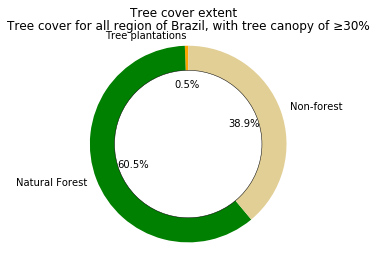

In [20]:
# Pie chart, where the slices will be ordered and plotted counter-clockwise:
if adm0 and not adm1 and not adm2:
    dynamic_sentence = (f"Tree cover for {location.lower()} of {iso_to_countries[adm0]}, "
                        f"with tree canopy of \u2265{threshold}%")
if adm0 and adm1 and not adm2: 
    dynamic_sentence = (f"Tree cover for {location.lower()} of {areaId_to_name[adm1]}, "
                        f"with tree canopy of \u2265{threshold}%")
if adm0 and adm1 and adm2:
    dynamic_sentence = (f"Tree cover for {location.lower()} of {areaId_to_name[adm2]}, "
                        f"with tree canopy of \u2265{threshold}%")


if location in ['All Region']: 
    labels = ['Tree plantations', 'Natural Forest', 'Non-forest']
    sizes = [plantations, tree_cover_extent_2010 - plantations, total_area - tree_cover_extent_2010]
    colors = ['orange','green','#E2CF96']
else: 
    labels = ['Tree cover', 'Non-forest']
    sizes = [tree_cover_extent_2010, total_area - tree_cover_extent_2010]
    colors = ['green','grey']
    
fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.1f%%',
        shadow=False, startangle=90, colors=colors)
ax1.axis('equal')
centre_circle = plt.Circle((0,0),0.75,color='black', fc='white',linewidth=0.5)
fig1 = plt.gcf()
fig1.gca().add_artist(centre_circle)
plt.suptitle('Tree cover extent')
plt.title(dynamic_sentence)
plt.show()

In [21]:
if location == 'All Region':

    if adm2:
        print(f"All of {areaId_to_name[adm2]} ({extent_year}) ", end="")
    elif adm1: 
        print(f"All of {areaId_to_name[adm1]} ({extent_year}) ", end="")
    elif adm0:
        print(f"All of {iso_to_countries[adm0]} ({extent_year}) ", end="")
        
else:
    
    if adm2:
        print(f"{areaId_to_name[adm2]}, {location} ({extent_year}) ", end="")
    elif adm1: 
        print(f"{areaId_to_name[adm1]}, {location} ({extent_year}) ", end="")
    elif adm0:
        print(f"{iso_to_countries[adm0]}, {location} ({extent_year}) ", end="")

print(f"is mainly ", end="")

if tree_cover_extent_2010/total_area > 0.5:
    print(f"tree covered considering tree cover extent ", end="")
else:
     print(f"non-forest considering tree cover extent ", end="")
print(f"where tree canopy is greater than {threshold}%.")

All of Brazil (2000) is mainly tree covered considering tree cover extent where tree canopy is greater than 30%.


# Tree cover widget (IFL ver.)

The default view for the tree cover widget should be for 'All region'.
We provide a mapping between the text to select in the Location drop-down and the dataset IDs that need to be called in conjunction with a specific selection.

                'Intact Forest Landscapes':'ifl_2013',

## INTACT FOREST LAYER EXTENT 

If plantation country:

  * Intact Forest = ifl_2013 extent
  * Degraded Forest = gadm28 extent - ifl_2013 extent - plantations extent
  * Plantations = plantations extent
  * Non-Forest = gadm28 area - gadm28 extent

If not plantation country:

* Intact Forest = ifl_2013 extent
* Other Tree Cover = gadm28 extent - ifl_2013 extent
* Non-Forest = gadm28 area - gadm28 extent

#### Refine Location options:

The dropdown 'Refine Location within' menu should expose the following options:

* All Intact Forests (2013)  (default)
* Mining in Intact Forests
* Protected Areas in Intact Forests
* Indigenous lands in Intact Forests  (landmark data)

IMPORTANT: if a user selects one of the location refined areas, then all the queries
need to update. E.g. if a user had selected "Mining in Intact Forests" then the
donut data should be calculated as follows:

* Intact Forest = ifl_2013__mining extent
* Degraded Forest = mining extent - ifl_2013_mining extent - plantations_mining extent
* Plantations = plantations__mining extent
* Non-Forest = mining poly_area - mining extent

In [22]:
# VARIABLES FOR TREE COVER WIDGET
ds = '499682b1-3174-493f-ba1a-368b4636708e'
url = f"https://production-api.globalforestwatch.org/v1/query/{ds}"
adm0 = 'BRA'
threshold = 30
adm1 = None
adm2 = None
location = 'Intact Forest Landscapes'
extent_year = 2000

tags = ["land_cover"]
selectable_polynames = ['ifl_2013', 'ifl_2013__mining','ifl_2013__wdpa']

In [23]:
# get a human readable {id: name} json for either admin 1 or 2 level as needed:

areaId_to_name = None
if adm2:
    tmp = get_admin2_json(iso=adm0, adm1=adm1)
    areaId_to_name ={}
    for row in tmp:
        areaId_to_name[row.get('adm2')] = row.get('name')
if adm1 and not adm2:
    tmp = get_admin1_json(iso=adm0)
    areaId_to_name={}
    for row in tmp:
        areaId_to_name[row.get('adm1')] = row.get('name') 

In [24]:
# Get Intact Forest Landscapes extent and  region area

if location in ['Intact Forest Landscapes',
                'Protected Areas in Intact Forest Landscapes',
                'Mining in Intact Forest Landscapes']:
    sql = extent_queries(p_name=polynames['Intact Forest Landscapes'], adm0=adm0,
                         adm1=adm1, adm2=adm2, threshold=threshold)
    r = requests.get(url, params = {"sql": sql})

    print(r.url)
    print(f'Status: {r.status_code}')
    pprint(r.json())

    try:
        intact_forest = r.json().get('data')[0].get('value')
    except:
        intact_forest = 0.0
    print(f"\n{adm0} {adm1} {adm2} plantation area = {intact_forest} ha")
else:
    print(f"No data, for '{intact_forest}'")

    intact_forest = None

Request for  adm0 area
https://production-api.globalforestwatch.org/v1/query/499682b1-3174-493f-ba1a-368b4636708e?sql=SELECT+SUM%28area_extent%29+as+value%2C+SUM%28area_gadm28%29+as+total_area+FROM+data+WHERE+iso+%3D+%27BRA%27+AND+thresh+%3D+30+AND+polyname+%3D+%27ifl_2013%27
Status: 200
{'data': [{'total_area': 381399518.46484375, 'value': 229520380.42967987}],
 'meta': {'cloneUrl': {'body': {'dataset': {'application': ['your', 'apps'],
                                            'datasetUrl': '/v1/query/499682b1-3174-493f-ba1a-368b4636708e?sql=SELECT%20SUM%28area_extent%29%20as%20value%2C%20SUM%28area_gadm28%29%20as%20total_area%20FROM%20data%20WHERE%20iso%20%3D%20%27BRA%27%20AND%20thresh%20%3D%2030%20AND%20polyname%20%3D%20%27ifl_2013%27'}},
                       'http_method': 'POST',
                       'url': '/v1/dataset/499682b1-3174-493f-ba1a-368b4636708e/clone'}}}

BRA None None plantation area = 229520380.42967987 ha


In [25]:
# Get specific extent and area values for intersections (mining in intact forest etc)
url = f"https://production-api.globalforestwatch.org/v1/query/{ds}"

if location in ['Intact Forest Landscapes']:
    poly = polynames['All Region']
elif location in ['Protected Areas in Intact Forest Landscapes']:
    poly = polynames['Protected Areas']
elif location in ['Mining in Intact Forest Landscapes']:
    poly = polynames['Mining']
    
sql = extent_queries(p_name=poly, adm0=adm0, adm1=adm1, adm2=adm2, threshold=threshold)
r = requests.get(url, params = {"sql": sql})

print(r.url)
print(f'Status: {r.status_code}')
pprint(r.json())

try:
    tree_cover_extent_2010 = r.json().get('data')[0].get('value')
except:
    tree_cover_extent_2010 = 0.0
print(f"\n{adm0} {adm1} {adm2} Gadm28 Tree cover extent = {tree_cover_extent_2010} ha")

try:
    total_area = r.json().get('data')[0].get('total_area')
except:
    total_area = None
print(f"total area = {total_area} ha")

Request for  adm0 area
https://production-api.globalforestwatch.org/v1/query/499682b1-3174-493f-ba1a-368b4636708e?sql=SELECT+SUM%28area_extent%29+as+value%2C+SUM%28area_gadm28%29+as+total_area+FROM+data+WHERE+iso+%3D+%27BRA%27+AND+thresh+%3D+30+AND+polyname+%3D+%27gadm28%27
Status: 200
{'data': [{'total_area': 850033236.0091553, 'value': 519187505.155631}],
 'meta': {'cloneUrl': {'body': {'dataset': {'application': ['your', 'apps'],
                                            'datasetUrl': '/v1/query/499682b1-3174-493f-ba1a-368b4636708e?sql=SELECT%20SUM%28area_extent%29%20as%20value%2C%20SUM%28area_gadm28%29%20as%20total_area%20FROM%20data%20WHERE%20iso%20%3D%20%27BRA%27%20AND%20thresh%20%3D%2030%20AND%20polyname%20%3D%20%27gadm28%27'}},
                       'http_method': 'POST',
                       'url': '/v1/dataset/499682b1-3174-493f-ba1a-368b4636708e/clone'}}}

BRA None None Gadm28 Tree cover extent = 519187505.155631 ha
total area = 850033236.0091553 ha


In [26]:
# For some locations we will also need to retrieve an area for plantations
# If user is interested on subregion (i.e mining) then get plantations within that subregion

if adm0 in polyname_config.get('plantations'):
    if location in ['Protected Areas in Intact Forest Landscapes']:
        plantations_poly = polynames['Protected areas in Plantations']
    elif location in ['Mining in Intact Forest Landscapes']:
        plantations_poly = polynames['Mining in Plantation Areas']
    else:
        plantations_poly = polynames['Plantations']
        
    sql = extent_queries(p_name=plantations_poly, adm0=adm0,
                         adm1=adm1, adm2=adm2, threshold=threshold)
    r = requests.get(url, params = {"sql": sql})

    print(r.url)
    print(f'Status: {r.status_code}')
    pprint(r.json())

    try:
        plantations = r.json().get('data')[0].get('value')
    except:
        plantations = 0.0
    print(f"\n{adm0} {adm1} {adm2} plantation area = {plantations} ha")
else:
    print(f"No plantation datafor '{location}'")
    plantations = None

Request for  adm0 area
https://production-api.globalforestwatch.org/v1/query/499682b1-3174-493f-ba1a-368b4636708e?sql=SELECT+SUM%28area_extent%29+as+value%2C+SUM%28area_gadm28%29+as+total_area+FROM+data+WHERE+iso+%3D+%27BRA%27+AND+thresh+%3D+30+AND+polyname+%3D+%27plantations%27
Status: 200
{'data': [{'total_area': 660671465.5681152, 'value': 4660023.699318573}],
 'meta': {'cloneUrl': {'body': {'dataset': {'application': ['your', 'apps'],
                                            'datasetUrl': '/v1/query/499682b1-3174-493f-ba1a-368b4636708e?sql=SELECT%20SUM%28area_extent%29%20as%20value%2C%20SUM%28area_gadm28%29%20as%20total_area%20FROM%20data%20WHERE%20iso%20%3D%20%27BRA%27%20AND%20thresh%20%3D%2030%20AND%20polyname%20%3D%20%27plantations%27'}},
                       'http_method': 'POST',
                       'url': '/v1/dataset/499682b1-3174-493f-ba1a-368b4636708e/clone'}}}

BRA None None plantation area = 4660023.699318573 ha


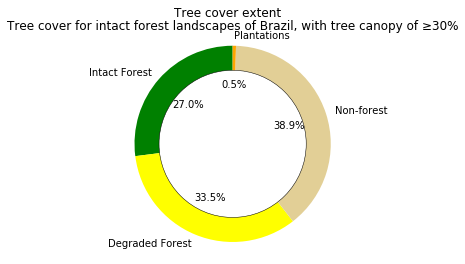

In [27]:
# Pie chart, where the slices will be ordered and plotted counter-clockwise:
if adm0 and not adm1 and not adm2:
    dynamic_sentence = (f"Tree cover for {location.lower()} of {iso_to_countries[adm0]}, "
                        f"with tree canopy of \u2265{threshold}%")
if adm0 and adm1 and not adm2: 
    dynamic_sentence = (f"Tree cover for {location.lower()} of {areaId_to_name[adm1]}, "
                        f"with tree canopy of \u2265{threshold}%")
if adm0 and adm1 and adm2:
    dynamic_sentence = (f"Tree cover for {location.lower()} of {areaId_to_name[adm2]}, "
                        f"with tree canopy of \u2265{threshold}%")

if location in ['Protected Areas in Intact Forest Landscapes', 'Mining in Intact Forest Landscapes']:
        labels = ['Intact Forest', 'Degraded Forest', 'Non-forest']
        sizes = [intact_forest, total_area - intact_forest, total_area - tree_cover_extent_2010]
        colors = ['green', 'yellow','#E2CF96']
        
        if adm0 in polyname_config.get('plantations') and plantations != 0:
            
            labels.append('Plantations')
            sizes.append(plantations)
            colors.append('orange')
            sizes[1] = sizes[1] - plantations

elif location in ['Intact Forest Landscapes']: 
    labels = ['Intact Forest', 'Degraded Forest', 'Non-forest']
    sizes = [intact_forest, tree_cover_extent_2010 - intact_forest, total_area - tree_cover_extent_2010]
    colors = ['green', 'yellow','#E2CF96']
    
    if adm0 in polyname_config.get('plantations') and plantations != 0:

        labels.append('Plantations')
        sizes.append(plantations)
        colors.append('orange')
        sizes[1] = sizes[1] - plantations


fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.1f%%',
        shadow=False, startangle=90, colors=colors)
ax1.axis('equal')
centre_circle = plt.Circle((0,0),0.75,color='black', fc='white',linewidth=0.5)
fig1 = plt.gcf()
fig1.gca().add_artist(centre_circle)
plt.suptitle('Tree cover extent')
plt.title(dynamic_sentence)
plt.show()

In [28]:
if adm0 not in polyname_config.get('plantations'):
    plantations = 0

if adm2:
    print(f"In {areaId_to_name[adm2]} ({extent_year}) ", end="")
elif adm1: 
    print(f"In {areaId_to_name[adm1]} ({extent_year}) ", end="")
elif adm0:
    print(f"In {iso_to_countries[adm0]} ({extent_year}) ", end="")

if intact_forest/tree_cover_extent_2010 > 0.5:
    print(f"the majority of tree cover extent is found in areas with {location.lower()}, ", end="")
elif (tree_cover_extent_2010 - intact_forest - plantations)/tree_cover_extent_2010 > 0.5:
    print(f"the majority of tree cover extent is found in degraded forests, ", end="")
else:
    print(f"the majority of tree cover extent is found in plantations, ", end="")
print(f"where tree canopy is greater than {threshold}%.")


In Brazil (2000) the majority of tree cover extent is found in degraded forests, where tree canopy is greater than 30%.


# Tree cover widget (Primary Forests ver.)

The default view for the tree cover widget should be for 'All region'.
We provide a mapping between the text to select in the Location drop-down and the dataset IDs that need to be called in conjunction with a specific selection.

If plantation country:

* Primary Forest = primary_forest extent
* Secondary Forest = gadm28 extent - primary_forest extent - plantations extent
* Plantations = plantations extent
* Non-Forest = gadm28 area - gadm28 extent

If not plantation country:

* Primary Forest = primary_forest extent
* Other Tree Cover = gadm28 extent - primary_forest extent
* Non-Forest = gadm28 area - gadm28 extent

#### Refine Location Options:

The dropdown 'Refine Location within' menu should expose the following options:

* All Primary Forests (default)
* Mining areas in Primary Forests
* Protected areas in Primary Forests
* Indigenous lands in Primary Forests (landmark data)




In [29]:
# VARIABLES FOR TREE COVER WIDGET
ds = '499682b1-3174-493f-ba1a-368b4636708e'
url = f"https://production-api.globalforestwatch.org/v1/query/{ds}"
adm0 = 'BRA'
threshold = 30
adm1 = None
adm2 = None
location = 'Primary Forests'
year = 2000

tags = ["land_cover"]
selectable_polynames = ['gadm28', 'primary_forest', 'primary_forest__mining', 
                        'primary_forest__wdpa','primary_forest__landmark']

In [30]:
# get a human readable {id: name} json for either admin 1 or 2 level as needed:

areaId_to_name = None
if adm2:
    tmp = get_admin2_json(iso=adm0, adm1=adm1)
    areaId_to_name ={}
    for row in tmp:
        areaId_to_name[row.get('adm2')] = row.get('name')
if adm1 and not adm2:
    tmp = get_admin1_json(iso=adm0)
    areaId_to_name={}
    for row in tmp:
        areaId_to_name[row.get('adm1')] = row.get('name') 

In [31]:
# Get extent and area of region
url = f"https://production-api.globalforestwatch.org/v1/query/{ds}"

if location in ['Primary Forests']:
    poly = polynames['All Region']
elif location in ['Protected Areas in Primary Forests']:
    poly = polynames['Protected Areas']
elif location in ['Mining in Primary Forests']:
    poly = polynames['Mining']
elif location in ['Indigenous Lands in Primary Forests']:
    poly = polynames['Indigenous Lands']
    
sql = extent_queries(p_name=poly, adm0=adm0, adm1=adm1, adm2=adm2, threshold=threshold)
r = requests.get(url, params = {"sql": sql})

print(r.url)
print(f'Status: {r.status_code}')
pprint(r.json())

try:
    tree_cover_extent_2010 = r.json().get('data')[0].get('value')
except:
    tree_cover_extent_2010 = 0.0
print(f"\n{adm0} {adm1} {adm2} Gadm28 Tree cover extent = {tree_cover_extent_2010} ha")

try:
    total_area = r.json().get('data')[0].get('total_area')
except:
    total_area = None
print(f"total area = {total_area} ha")

Request for  adm0 area
https://production-api.globalforestwatch.org/v1/query/499682b1-3174-493f-ba1a-368b4636708e?sql=SELECT+SUM%28area_extent%29+as+value%2C+SUM%28area_gadm28%29+as+total_area+FROM+data+WHERE+iso+%3D+%27BRA%27+AND+thresh+%3D+30+AND+polyname+%3D+%27gadm28%27
Status: 200
{'data': [{'total_area': 850033236.0091553, 'value': 519187505.155631}],
 'meta': {'cloneUrl': {'body': {'dataset': {'application': ['your', 'apps'],
                                            'datasetUrl': '/v1/query/499682b1-3174-493f-ba1a-368b4636708e?sql=SELECT%20SUM%28area_extent%29%20as%20value%2C%20SUM%28area_gadm28%29%20as%20total_area%20FROM%20data%20WHERE%20iso%20%3D%20%27BRA%27%20AND%20thresh%20%3D%2030%20AND%20polyname%20%3D%20%27gadm28%27'}},
                       'http_method': 'POST',
                       'url': '/v1/dataset/499682b1-3174-493f-ba1a-368b4636708e/clone'}}}

BRA None None Gadm28 Tree cover extent = 519187505.155631 ha
total area = 850033236.0091553 ha


In [32]:
# get primary forests extent and area

if location in ['Primary Forests', 'Mining in Primary Forests',
                'Protected Areas in Primary Forests','Indigenous Lands in Primary Forests']:
    sql = extent_queries(p_name=polynames['Primary Forests'], adm0=adm0,
                         adm1=adm1, adm2=adm2, threshold=threshold)
    r = requests.get(url, params = {"sql": sql})

    print(r.url)
    print(f'Status: {r.status_code}')
    pprint(r.json())

    try:
        primary_forest = r.json().get('data')[0].get('value')
    except:
        primary_forest = 0.0
    print(f"\n{adm0} {adm1} {adm2} plantation area = {primary_forest} ha")
else:
    print(f"No data, for '{prime_forest}'")
    primary_forest = None

Request for  adm0 area
https://production-api.globalforestwatch.org/v1/query/499682b1-3174-493f-ba1a-368b4636708e?sql=SELECT+SUM%28area_extent%29+as+value%2C+SUM%28area_gadm28%29+as+total_area+FROM+data+WHERE+iso+%3D+%27BRA%27+AND+thresh+%3D+30+AND+polyname+%3D+%27primary_forest%27
Status: 200
{'data': [{'total_area': 577934483.182251, 'value': 343232410.75174}],
 'meta': {'cloneUrl': {'body': {'dataset': {'application': ['your', 'apps'],
                                            'datasetUrl': '/v1/query/499682b1-3174-493f-ba1a-368b4636708e?sql=SELECT%20SUM%28area_extent%29%20as%20value%2C%20SUM%28area_gadm28%29%20as%20total_area%20FROM%20data%20WHERE%20iso%20%3D%20%27BRA%27%20AND%20thresh%20%3D%2030%20AND%20polyname%20%3D%20%27primary_forest%27'}},
                       'http_method': 'POST',
                       'url': '/v1/dataset/499682b1-3174-493f-ba1a-368b4636708e/clone'}}}

BRA None None plantation area = 343232410.75174 ha


In [33]:
# Get plantation extent within the region

if adm0 in polyname_config.get('plantations'):
    if location in ['Protected Areas in Primary Forests']:
        plantations_poly = polynames['Protected areas in Plantations']
    elif location in ['Indigenous Lands in Primary Forests']:
        plantations_poly = polynames['Indigenous Lands in Plantations']
    elif location in ['Mining in Primary Forests']:
        plantations_poly = polynames['Mining in Plantation Areas']
    else:
        plantations_poly = polynames['Plantations']
        
    sql = extent_queries(p_name=plantations_poly, adm0=adm0,
                         adm1=adm1, adm2=adm2, threshold=threshold)
    r = requests.get(url, params = {"sql": sql})

    print(r.url)
    print(f'Status: {r.status_code}')
    pprint(r.json())

    try:
        plantations = r.json().get('data')[0].get('value')
    except:
        plantations = 0.0
    print(f"\n{adm0} {adm1} {adm2} plantation area = {plantations} ha")
else:
    print(f"No plantation data for '{location}'")
    plantations = None

Request for  adm0 area
https://production-api.globalforestwatch.org/v1/query/499682b1-3174-493f-ba1a-368b4636708e?sql=SELECT+SUM%28area_extent%29+as+value%2C+SUM%28area_gadm28%29+as+total_area+FROM+data+WHERE+iso+%3D+%27BRA%27+AND+thresh+%3D+30+AND+polyname+%3D+%27plantations%27
Status: 200
{'data': [{'total_area': 660671465.5681152, 'value': 4660023.699318573}],
 'meta': {'cloneUrl': {'body': {'dataset': {'application': ['your', 'apps'],
                                            'datasetUrl': '/v1/query/499682b1-3174-493f-ba1a-368b4636708e?sql=SELECT%20SUM%28area_extent%29%20as%20value%2C%20SUM%28area_gadm28%29%20as%20total_area%20FROM%20data%20WHERE%20iso%20%3D%20%27BRA%27%20AND%20thresh%20%3D%2030%20AND%20polyname%20%3D%20%27plantations%27'}},
                       'http_method': 'POST',
                       'url': '/v1/dataset/499682b1-3174-493f-ba1a-368b4636708e/clone'}}}

BRA None None plantation area = 4660023.699318573 ha


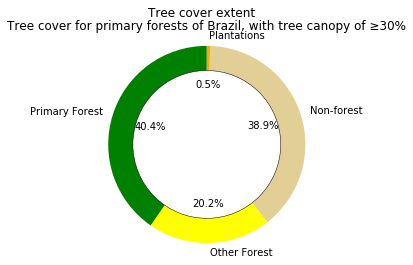

In [34]:
# Pie chart, where the slices will be ordered and plotted counter-clockwise:
if adm0 and not adm1 and not adm2:
    dynamic_sentence = (f"Tree cover for {location.lower()} of {iso_to_countries[adm0]}, "
                        f"with tree canopy of \u2265{threshold}%")
if adm0 and adm1 and not adm2: 
    dynamic_sentence = (f"Tree cover for {location.lower()} of {areaId_to_name[adm1]}, "
                        f"with tree canopy of \u2265{threshold}%")
if adm0 and adm1 and adm2:
    dynamic_sentence = (f"Tree cover for {location.lower()} of {areaId_to_name[adm2]}, "
                        f"with tree canopy of \u2265{threshold}%")

if location in ['Mining in Primary Forests',
                'Protected Areas in Primary Forests','Indigenous Lands in Primary Forests']:
        labels = ['Primary Forest', 'Other Forest', 'Non-forest']
        sizes = [primary_forest, total_area - primary_forest, total_area - super_location]
        colors = ['green', 'yellow','#E2CF96']
        
        if adm0 in polyname_config.get('plantations') and plantations != 0:
            
            labels.append('Plantations')
            sizes.append(plantations)
            colors.append('orange')
            sizes[1] = sizes[1] - plantations

elif location in ['Primary Forests']: 
    labels = ['Primary Forest', 'Other Forest', 'Non-forest']
    sizes = [primary_forest, tree_cover_extent_2010 - primary_forest, total_area - tree_cover_extent_2010]
    colors = ['green', 'yellow','#E2CF96']
    
    if adm0 in polyname_config.get('plantations') and plantations != 0:

        labels.append('Plantations')
        sizes.append(plantations)
        colors.append('orange')
        sizes[1] = sizes[1] - plantations
    
fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.1f%%',
        shadow=False, startangle=90, colors=colors)
ax1.axis('equal')
centre_circle = plt.Circle((0,0),0.75,color='black', fc='white',linewidth=0.5)
fig1 = plt.gcf()
fig1.gca().add_artist(centre_circle)
plt.suptitle('Tree cover extent')
plt.title(dynamic_sentence)
plt.show()

In [35]:
if adm0 not in polyname_config.get('plantations'):
    plantations = 0

if adm2:
    print(f"In {areaId_to_name[adm2]} ({extent_year}) ", end="")
elif adm1: 
    print(f"In {areaId_to_name[adm1]} ({extent_year}) ", end="")
elif adm0:
    print(f"In {iso_to_countries[adm0]} ({extent_year}) ", end="")

if primary_forest/tree_cover_extent_2010 > 0.5:
    print(f"the majority of tree cover extent is found in areas with {location.lower()}, ", end="")
elif (tree_cover_extent_2010 - primary_forest - plantations)/tree_cover_extent_2010 > 0.5:
    print(f"the majority of tree cover extent is found in other forests, ", end="")
else:
    print(f"the majority of tree cover extent is found in plantations, ", end="")
print(f"where tree canopy is greater than {threshold}%.")


In Brazil (2000) the majority of tree cover extent is found in areas with primary forests, where tree canopy is greater than 30%.


<a id='s2'></a>
## FAO FOREST Widget

This widget should include 'FOREST COVER ' in the title - note the distinction, that the Hansen data relate to tree cover, and FAO relate to forest cover...

An FAO-based forest widget can be calcuated based on data in a carto table `https://wri-01.carto.com/tables/gfw2_countries`

It will take a little work, as the data stored in the carto table is % of primary, regenerated and planted forest. Therefore we must 1) get an area (ha) extent of the forest, 2) obtain the % values of various FAO forest statistics from the carto table, 3) derrive the real (ha) area of FAO forest for each category, and 4) get a value of absolute area of the country and subtract the values caluclated in step 3 from the total area to get non-forest. 

** Pie categories **

* Primary Forest
* Naturally Regenerated Forest
* Planted Forest
* Non-forest

**Notes** 

1. These data (and therefore this widget) is only avaiable at the NATIONAL (ADMIN 0) level. And should dissapear from the pages if any other area is selected.

1. These data have no threshold selection.

1. As these data are only national, we can simply rely on the `umd_nat_staging` table to provide areas directly, rather than needing to dynamically calculate the areas.

In [36]:
# For FAO data, only country (admin0) level data are avaiable. No other options on selector.

# Variables
adm0 = 'BRA'

tags = ["forest_change", "land_cover"]
selectable_polynames = []

In [37]:
# First, get the FAO data from a carto table

sql = ("SELECT fao.iso, fao.name,forest_planted, forest_primary, "
         "forest_regenerated, fao.forest_primary, fao.extent, a.land as area_ha "
         "FROM gfw2_countries as fao "
         "INNER JOIN umd_nat_staging as a "
         "ON fao.iso=a.iso "
         "WHERE fao.forest_primary is not null "
         f"AND fao.iso = '{adm0}' "
         "AND a.year = 2001 "
         "AND a.thresh = 30 "
        )

account = 'wri-01'
urlCarto = "https://{0}.carto.com/api/v2/sql".format(account)

sql = {"q": sql}
r = requests.get(urlCarto, params=sql)
print(r.url,'\n')
pprint(r.json())

try:
    fao_percent = r.json().get('rows')[0]
except:
    fao_percent = None

https://wri-01.carto.com/api/v2/sql?q=SELECT+fao.iso%2C+fao.name%2Cforest_planted%2C+forest_primary%2C+forest_regenerated%2C+fao.forest_primary%2C+fao.extent%2C+a.land+as+area_ha+FROM+gfw2_countries+as+fao+INNER+JOIN+umd_nat_staging+as+a+ON+fao.iso%3Da.iso+WHERE+fao.forest_primary+is+not+null+AND+fao.iso+%3D+%27BRA%27+AND+a.year+%3D+2001+AND+a.thresh+%3D+30+ 

{'fields': {'area_ha': {'type': 'number'},
            'extent': {'type': 'number'},
            'forest_planted': {'type': 'number'},
            'forest_primary': {'type': 'number'},
            'forest_regenerated': {'type': 'number'},
            'iso': {'type': 'string'},
            'name': {'type': 'string'}},
 'rows': [{'area_ha': 853281125.672,
           'extent': 492968489,
           'forest_planted': 2,
           'forest_primary': 41,
           'forest_regenerated': 57,
           'iso': 'BRA',
           'name': 'Brazil'}],
 'time': 0.007,
 'total_rows': 1}


In [38]:
# How to calculate the statitics needed based on the CARTO responses
if fao_percent:
    
    naturally_regenerated =  fao_percent['extent']/ 100 *  fao_percent['forest_regenerated']
    primary_forest = fao_percent['extent']/100 *  fao_percent['forest_primary']
    planted_forest = fao_percent['extent']/100 * fao_percent['forest_planted']
    non_forest = fao_percent['area_ha'] - (naturally_regenerated + primary_forest + planted_forest)

else:
    print(f"No data for {adm0}")


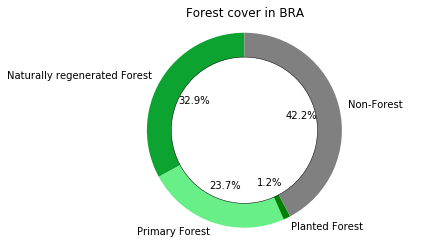

In [39]:
if fao_percent:
    # FAO donut chart 
    # NOTE - THE COLOURS ARE NOT NECESSARILY THOSE NEEDED FOR PRODUCTION
    labels = ['Naturally regenerated Forest', 'Primary Forest', 'Planted Forest', 'Non-Forest']
    sizes = [naturally_regenerated, primary_forest, planted_forest, non_forest]

    fig1, ax1 = plt.subplots()
    ax1.pie(sizes, labels=labels, autopct='%1.1f%%',
            shadow=False, startangle=90, colors=['#0da330', '#69ef88','green','grey'])
    ax1.axis('equal')
    centre_circle = plt.Circle((0,0),0.75,color='black', fc='white',linewidth=0.5)
    fig1 = plt.gcf()
    fig1.gca().add_artist(centre_circle)
    plt.title(f'Forest cover in {adm0}')
    plt.show()
    
else:
    print(f"No data for {adm0}")

In [40]:
## RANK ALL COUNTRIES RELATIVE AMOUNT OF PRIMARY FOREST in 2015 and report that value for a dynamic sentence

sql = ("WITH mytable AS (SELECT fao.iso, fao.name, fao.forest_primary, fao.extent forest_extent, a.land as area_ha "
"FROM gfw2_countries as fao "
"INNER JOIN umd_nat_staging as a "
"ON fao.iso=a.iso "
"WHERE fao.forest_primary > 0 "
"AND a.year = 2001 "
"AND a.thresh = 30), "
"rank AS ( "
"SELECT forest_extent * (forest_primary/100)/area_ha * 100 as percent_primary ,iso "
"from mytable "
"ORDER BY percent_primary DESC), "
f"item as (select percent_primary from rank where iso = '{adm0}') "
"select count(*) as rank "
"from rank "
"WHERE percent_primary > (select percent_primary from item) ")

account = 'wri-01'
urlCarto = "https://{0}.carto.com/api/v2/sql".format(account)

sql = {"q": sql}
r = requests.get(urlCarto, params=sql)
print(r.url,'\n')
pprint(r.json())

rank = r.json().get('rows')[0].get('rank')
print(rank)

https://wri-01.carto.com/api/v2/sql?q=WITH+mytable+AS+%28SELECT+fao.iso%2C+fao.name%2C+fao.forest_primary%2C+fao.extent+forest_extent%2C+a.land+as+area_ha+FROM+gfw2_countries+as+fao+INNER+JOIN+umd_nat_staging+as+a+ON+fao.iso%3Da.iso+WHERE+fao.forest_primary+%3E+0+AND+a.year+%3D+2001+AND+a.thresh+%3D+30%29%2C+rank+AS+%28+SELECT+forest_extent+%2A+%28forest_primary%2F100%29%2Farea_ha+%2A+100+as+percent_primary+%2Ciso+from+mytable+ORDER+BY+percent_primary+DESC%29%2C+item+as+%28select+percent_primary+from+rank+where+iso+%3D+%27BRA%27%29+select+count%28%2A%29+as+rank+from+rank+WHERE+percent_primary+%3E+%28select+percent_primary+from+item%29+ 

{'fields': {'rank': {'type': 'number'}},
 'rows': [{'rank': 27}],
 'time': 0.038,
 'total_rows': 1}
27


In [41]:
# Dyanmic sentence for FAO plot
if fao_percent:
    print(f"FAO data from 2015 shows that {iso_to_countries[adm0]} is ", end="")

    if  non_forest/fao_percent['area_ha'] > 0.5:
        print('mostly non-forest. ', end="")
    else:
        print('mostly forest. ',end="")

    if primary_forest > 0:
        print(f"Primary forest occupies {primary_forest/fao_percent['area_ha']*100:3.1f}% of the country. ", end="")
        print(f"This gives {iso_to_countries[adm0]} a rank of {rank}th out of 110 countries in terms of ", end="")
        print("its relative amount of primary forest.")
    
else:
    print(f"No data for {adm0}")

FAO data from 2015 shows that Brazil is mostly forest. Primary forest occupies 23.7% of the country. This gives Brazil a rank of 27th out of 110 countries in terms of its relative amount of primary forest.


<a id='s3'></a>
## TREE COVER LOSS WIDGET 

The UMD/Hansen Tree cover loss widget should be a bar chart, with time as the x-axis, and loss (ha) as the y-axis, on hover it should show the year, ha loss, and % loss relative to 2000 tree cover extent *for the data table of interest*.

** Notes ** 

* Loss data tables have loss units in both area (ha) and emissions (t co2/ha). The emissions units will only be used in the loss widget to add contextual info to the dynamic sentence.

* It is probably best to always request the full time period of data from the table, and then subset it client-side, as we will always need to know the last year of loss to construct the dynamic sentence.

* In settings, the users should be able to change the data sources, when they do you will need to query different data tables both for calculating loss and extent (to calculate relative loss):
    - All region (default) view: gadm28 table
    - all other data tables currently created should be selectable too
    
*more info - not needed for front-end devs*
- for refrence in testing adm0 = BRA, adm1 = 12, adm2 = 1434 is Mato Grosso, Cáceres


** WHen plantations are selected the user should see a stacked bar chart  from 2013 onwards **
More details of this to follow below.


In [42]:
# Variables

threshold=30
adm0 = 'BRA'
adm1 = None
adm2 = None
start=2000
end=2016
location = "All Region"

tags = ["forest_change", "land_cover", "conservation", "people", "land_use"]
selectable_polynames = ['gadm28',
                        'bra_biomes',
                        'mining',
                        'wdpa',
                        'primary_forest',
                        'ifl_2013']

In [43]:
# get a human readable {id: name} json for either admin 1 or 2 level as needed:

areaId_to_name = None
if adm2:
    tmp = get_admin2_json(iso=adm0, adm1=adm1)
    areaId_to_name ={}
    for row in tmp:
        areaId_to_name[row.get('adm2')] = row.get('name')
if adm1 and not adm2:
    tmp = get_admin1_json(iso=adm0)
    areaId_to_name={}
    for row in tmp:
        areaId_to_name[row.get('adm1')] = row.get('name')

In [44]:
def loss_queries(p_name, adm0, adm1=None, adm2=None, threshold=30):
    if adm2:
        print(f'Request for adm2 area')
        sql = (f"SELECT polyname, year_data.year as year, "
               f"SUM(year_data.area_loss) as area, "
               f"SUM(year_data.emissions) as emissions "
               f"FROM data "
               f"WHERE polyname = '{p_name}' "
               f"AND iso = '{adm0}' "
               f"AND adm1 = {adm1} "
               f"AND adm2 = {adm2} "
               f"AND thresh= {threshold} "
               f"GROUP BY polyname, iso, nested(year_data.year)")
        return sql
    elif adm1:
        print('Request for  adm1 area')
        sql = (f"SELECT polyname, year_data.year as year, "
               f"SUM(year_data.area_loss) as area, "
               f"SUM(year_data.emissions) as emissions "
               f"FROM data "
               f"WHERE polyname = '{p_name}' "
               f"AND iso = '{adm0}' "
               f"AND adm1 = {adm1} "
               f"AND thresh= {threshold} "
               f"GROUP BY polyname, iso, nested(year_data.year)")
        return sql
    elif adm0:
        print('Request for  adm0 area')
        sql = (f"SELECT polyname, year_data.year as year, "
               f"SUM(year_data.area_loss) as area, "
               f"SUM(year_data.emissions) as emissions "
               f"FROM data "
               f"WHERE polyname = '{p_name}' " 
               f"AND iso = '{adm0}' "
               f"AND thresh= {threshold} "
               f"GROUP BY polyname, iso, nested(year_data.year)")
        return sql



Loss on hover should show % loss relative to Tree cover extent of the location selected in the year 2010. I.e. if someone is interested in the 'All region' default view, then the loss should come from the `gadm28 loss` table, and the extent (to calculate the relative loss) should come from the `gadm28 extent` table.

Therefore we must calculate loss % also, for this we will need the tree cover extent data too.

In [45]:
# First, get the extent of tree cover over your area of interest (to work out relative loss)
sql = extent_queries(p_name=polynames[location], adm0=adm0, 
                   adm1=adm1, adm2=adm2, threshold=threshold)    
print(sql) # loss query
properties = {"sql": sql}
r = requests.get(url, params = properties)
print(r.url)
print(f'Status: {r.status_code}')
pprint(r.json())
y2010_relative_extent = r.json().get('data')[0].get('total_area')

Request for  adm0 area
SELECT SUM(area_extent) as value, SUM(area_gadm28) as total_area FROM data WHERE iso = 'BRA' AND thresh = 30 AND polyname = 'gadm28'
https://production-api.globalforestwatch.org/v1/query/499682b1-3174-493f-ba1a-368b4636708e?sql=SELECT+SUM%28area_extent%29+as+value%2C+SUM%28area_gadm28%29+as+total_area+FROM+data+WHERE+iso+%3D+%27BRA%27+AND+thresh+%3D+30+AND+polyname+%3D+%27gadm28%27
Status: 200
{'data': [{'total_area': 850033236.0091553, 'value': 519187505.155631}],
 'meta': {'cloneUrl': {'body': {'dataset': {'application': ['your', 'apps'],
                                            'datasetUrl': '/v1/query/499682b1-3174-493f-ba1a-368b4636708e?sql=SELECT%20SUM%28area_extent%29%20as%20value%2C%20SUM%28area_gadm28%29%20as%20total_area%20FROM%20data%20WHERE%20iso%20%3D%20%27BRA%27%20AND%20thresh%20%3D%2030%20AND%20polyname%20%3D%20%27gadm28%27'}},
                       'http_method': 'POST',
                       'url': '/v1/dataset/499682b1-3174-493f-ba1a-368b46

In [46]:
#ds = '499682b1-3174-493f-ba1a-368b4636708e'
url = f"https://production-api.globalforestwatch.org/v1/query/{ds}"

print(adm0)

# Next, get the loss data grouped by year
sql = loss_queries(p_name=polynames[location], adm0=adm0, 
                   adm1=adm1, adm2=adm2, threshold=threshold)    
print(sql) # loss query
properties = {"sql": sql}
r = requests.get(url, params = properties)
print(r.url)
print(f'Status: {r.status_code}')
pprint(r.json())


# # Extract the year, and loss in hectares, and emissions units, and calculate the relative loss in %
d = {}
for row in r.json().get('data'):
    tmp_yr = float(row.get('year'))
    if tmp_yr > 2000:
        try:
            tmp_area = float(row.get('area'))
        except:
            tmp_area = None
            
        try:
            tmp_area_pcnt = (tmp_area / y2010_relative_extent) * 100
        except:
            tmp_area_pcnt = None
            
        try:
            tmp_emiss = float(row.get('emissions'))
        except:
            tmp_emiss = None
            
        d[int(tmp_yr)] = {'area_ha': tmp_area,
                              'area_%': tmp_area_pcnt,
                              'emissions': tmp_emiss,
                               }
pprint(d)

BRA
Request for  adm0 area
SELECT polyname, year_data.year as year, SUM(year_data.area_loss) as area, SUM(year_data.emissions) as emissions FROM data WHERE polyname = 'gadm28' AND iso = 'BRA' AND thresh= 30 GROUP BY polyname, iso, nested(year_data.year)
https://production-api.globalforestwatch.org/v1/query/499682b1-3174-493f-ba1a-368b4636708e?sql=SELECT+polyname%2C+year_data.year+as+year%2C+SUM%28year_data.area_loss%29+as+area%2C+SUM%28year_data.emissions%29+as+emissions+FROM+data+WHERE+polyname+%3D+%27gadm28%27+AND+iso+%3D+%27BRA%27+AND+thresh%3D+30+GROUP+BY+polyname%2C+iso%2C+nested%28year_data.year%29
Status: 200
{'data': [{'area': 2746361.4890696183,
           'emissions': 451665397.0006001,
           'iso': 'BRA',
           'polyname': 'gadm28',
           'year': 2001},
          {'area': 3507049.430043675,
           'emissions': 599107237.3975263,
           'iso': 'BRA',
           'polyname': 'gadm28',
           'year': 2002},
          {'area': 3248526.7289099023,
      

Use the `start` and `end` variables to filter the time-range on the front-end.

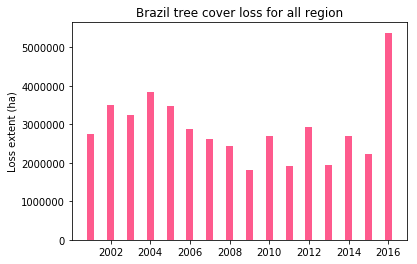

In [47]:
if adm0 and not adm1 and not adm2:
    dynamic_title = (f'{iso_to_countries[adm0]} tree cover loss for {location.lower()}')
if adm0 and adm1 and not adm2: 
    dynamic_title = (f"{areaId_to_name[adm1]} tree cover loss for {location.lower()}")
if adm0 and adm1 and adm2:
    dynamic_title = (f"{areaId_to_name[adm2]} tree cover loss for {location.lower()}")


loss = []
for val in d.values():
    if val.get('area_ha'):
        loss.append(val.get('area_ha'))
    else:
        loss.append(0)

years = d.keys()
width = 0.35
fig, ax = plt.subplots()
rects1 = ax.bar(years, loss, width, color='#FE5A8D')


# add some text for labels, title and axes ticks
ax.set_ylabel('Loss extent (ha)')
ax.set_title(dynamic_title)
plt.show()

#### Dynamic sentence 

For the loss widget we also need a dynamic sentence.

In [48]:
for year in d:
    print(year, d.get(year).get('emissions'), d.get(year).get('area_ha'))

2001 451665397.0006001 2746361.4890696183
2002 599107237.3975263 3507049.430043675
2003 540574861.4785872 3248526.7289099023
2004 676408980.2036796 3848770.7972362638
2005 644553412.0320137 3486562.714630291
2006 513807720.2924354 2876804.669658102
2007 437504684.6362488 2621820.242933862
2008 421136841.3216598 2444308.1962688714
2009 309401955.17921805 1817901.2345727086
2010 455313700.8952615 2688896.1758544967
2011 323015090.3335359 1923363.68953944
2012 464007720.51890945 2918633.138893433
2013 299307098.087373 1945506.2521234453
2014 414300626.2159879 2693134.2983764634
2015 347409489.11158633 2222772.419181913
2016 961585493.266664 5378844.035288975


In [49]:
# First find total emissions, and loss, and also the last year of emissions and loss

total_emissions = 0
total_loss = 0
for year in d:
    total_loss += d.get(year).get('area_ha')
    total_emissions += d.get(year).get('emissions')

print([total_emissions, total_loss])

[7859100307.971289, 46369255.51258146]


In [50]:
# Dynamic sentence construction

if adm0 and not adm1 and not adm2:
    print(f"Between {start} and {end}, {iso_to_countries[adm0]} ({location.lower()}) ", end="")
if adm0 and adm1 and not adm2: 
    print(f"Between {start} and {end},  {location} of {areaId_to_name[adm1].lower()} ", end="")
if adm0 and adm1 and adm2:
    print(f"Between {start} and {end}, {location} of {areaId_to_name[adm2].lower()} ", end="")
    
print(f"lost {total_loss:,.0f} ha of tree cover: ", end="")
print(f"This loss is equal to {total_loss / y2010_relative_extent * 100:3.2f}% of the total ", end="")
print(f"{location.lower()} tree cover extent in 2010, ", end="")
print(f"and equivalent to {total_emissions:,.0f} tonnes of CO\u2082 emissions. ", end="")

Between 2000 and 2016, Brazil (all region) lost 46,369,256 ha of tree cover: This loss is equal to 5.45% of the total all region tree cover extent in 2010, and equivalent to 7,859,100,308 tonnes of CO₂ emissions. 

<a id='s4'></a>
## Loss extra: stacked bars plantation widget

If a user has selected a country where Plantation data is available, then they should see an extra plot - it will be a stacked bar that distinguishes loss inside and outside of plantations.

**Again, this is only possible for certain countries, the Plantation option should not appear in the menu unless a user is in a country with Plantation data**

Also, a key thing to note here. The raw data has values back to 2000, HOWEVER, for plantation data, we must not show anything earlier than 2013 in the figure.

Note the below area for BRA has the largest extent of plantations:
* adm1: 16,
* adm2: 3135,

In [51]:
# Variables

threshold=30
adm0 = 'BRA'
adm1 = 16
adm2 = None
start=2013
end=2016


tags = ["forest_change", "land_cover", "conservation", "people", "land_use"]
selectable_polynames = ['gadm28', 'plantations']

In [52]:
# get a human readable {id: name} json for either admin 1 or 2 level as needed:

areaId_to_name = None
if adm2:
    tmp = get_admin2_json(iso=adm0, adm1=adm1)
    areaId_to_name ={}
    for row in tmp:
        areaId_to_name[row.get('adm2')] = row.get('name')
if adm1 and not adm2:
    tmp = get_admin1_json(iso=adm0)
    areaId_to_name={}
    for row in tmp:
        areaId_to_name[row.get('adm1')] = row.get('name')

In [53]:
# We need two sets of loss data to calculate this widget (plantation and gadm28)

sql = loss_queries(p_name=polynames['Plantations'], adm0=adm0,
             adm1=adm1, adm2=adm2, threshold=threshold)
print(sql) # loss query
properties = {"sql": sql}
r = requests.get(url, params = properties)
print(r.url)
print(f'Status: {r.status_code}')
plantation_loss_raw =  r.json()


sql = loss_queries(p_name=polynames['All Region'], adm0=adm0,
             adm1=adm1, adm2=adm2, threshold=threshold)
print(sql) # loss query
properties = {"sql": sql}
r = requests.get(url, params = properties)
print(r.url)
print(f'Status: {r.status_code}')
all_loss_raw =  r.json()

Request for  adm1 area
SELECT polyname, year_data.year as year, SUM(year_data.area_loss) as area, SUM(year_data.emissions) as emissions FROM data WHERE polyname = 'plantations' AND iso = 'BRA' AND adm1 = 16 AND thresh= 30 GROUP BY polyname, iso, nested(year_data.year)
https://production-api.globalforestwatch.org/v1/query/499682b1-3174-493f-ba1a-368b4636708e?sql=SELECT+polyname%2C+year_data.year+as+year%2C+SUM%28year_data.area_loss%29+as+area%2C+SUM%28year_data.emissions%29+as+emissions+FROM+data+WHERE+polyname+%3D+%27plantations%27+AND+iso+%3D+%27BRA%27+AND+adm1+%3D+16+AND+thresh%3D+30+GROUP+BY+polyname%2C+iso%2C+nested%28year_data.year%29
Status: 200
Request for  adm1 area
SELECT polyname, year_data.year as year, SUM(year_data.area_loss) as area, SUM(year_data.emissions) as emissions FROM data WHERE polyname = 'gadm28' AND iso = 'BRA' AND adm1 = 16 AND thresh= 30 GROUP BY polyname, iso, nested(year_data.year)
https://production-api.globalforestwatch.org/v1/query/499682b1-3174-493f-ba1

In [54]:
def find_values_for_year(year, raw_json, keys):
    """Look in a returned raw json object for a row of
        a specific year, and return some elements of data.
    """
    tmp = {}
    for row in raw_json.get('data'):
        if year == row.get('year'):
            for key in keys:
                tmp[key]=row.get(key)
            return tmp
        

plantation_loss_d = {}
for year in range(start, end+1):
    tmp_gadm28_loss = find_values_for_year(year, all_loss_raw, ['area','emissions'])
    tmp_plantation_loss = find_values_for_year(year, plantation_loss_raw, ['area','emissions'])
    plantation_loss_d[year] = {'plantation_ha':tmp_plantation_loss.get('area'),
                               'plantation_co2':tmp_plantation_loss.get('emissions'),
                               'outside_ha':tmp_gadm28_loss.get('area') - tmp_plantation_loss.get('area'),
                               'outside_co2':tmp_gadm28_loss.get('emissions') -tmp_plantation_loss.get('emissions'),
                                }

plantation_loss_d

{2013: {'outside_co2': 4174565.325224638,
  'outside_ha': 34409.70245333761,
  'plantation_co2': 3102098.5174250603,
  'plantation_ha': 25506.401173613966},
 2014: {'outside_co2': 4174491.988687277,
  'outside_ha': 35922.8106591776,
  'plantation_co2': 3208121.8227026463,
  'plantation_ha': 26627.899772256613},
 2015: {'outside_co2': 2504388.8389742374,
  'outside_ha': 21914.877830423415,
  'plantation_co2': 2467902.3691403866,
  'plantation_ha': 21297.13095678389},
 2016: {'outside_co2': 4648410.706295252,
  'outside_ha': 41410.54088755697,
  'plantation_co2': 3123386.467946768,
  'plantation_ha': 28289.675099410117}}

In [55]:
#print(outside_loss)
#print(plantation_loss)

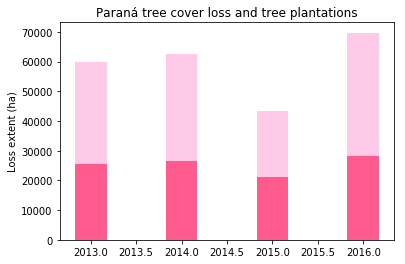

In [56]:
if adm0 and not adm1 and not adm2:
    dynamic_title = (f'{iso_to_countries[adm0]} tree cover loss and tree plantations')
if adm0 and adm1 and not adm2: 
    dynamic_title = (f"{areaId_to_name[adm1]} tree cover loss and tree plantations")
if adm0 and adm1 and adm2:
    dynamic_title = (f"{areaId_to_name[adm2]} tree cover loss and tree plantations")


plantation_loss = []
for val in plantation_loss_d.values():
    if val.get('plantation_ha'):
        plantation_loss.append(val.get('plantation_ha'))
    else:
        plantation_loss.append(0)
plantation_loss = np.array(plantation_loss)

outside_loss = []
for val in plantation_loss_d.values():
    if val.get('outside_ha'):
        outside_loss.append(val.get('outside_ha'))
    else:
        outside_loss.append(0)
outside_loss = np.array(outside_loss)       

years = plantation_loss_d.keys()
width = 0.35
fig, ax = plt.subplots()
rects1 = ax.bar(years, plantation_loss, width, color='#FE5A8D')
rects2 = ax.bar(years, outside_loss, width, bottom=plantation_loss, color='#ffc9e7')


# add some text for labels, title and axes ticks
ax.set_ylabel('Loss extent (ha)')
ax.set_title(dynamic_title)
plt.show()

<a id='s5'></a>
#### Dynamic sentence for plantation loss widget:

The majority of tree cover loss from xxx-year to xxx-year within X-location is driven by loss xx inside/outside 
xx of tree plantations. Over that time, loss outside of plantations was equivalent to an estimated XX tones of CO2 emissions.

In [57]:
total_plantation_loss = np.sum(plantation_loss)
total_outside_loss = np.sum(outside_loss)

total_co2_over_start_end = 0
for row in plantation_loss_d:
    total_co2_over_start_end += plantation_loss_d[row].get('plantation_co2')
    total_co2_over_start_end += plantation_loss_d[row].get('outside_co2')

print('total plantation loss ',total_plantation_loss)
print('total outside loss ',total_outside_loss)
print('total co2 over start end', total_co2_over_start_end)

total plantation loss  101721.107002
total outside loss  133657.93183
total co2 over start end 27403366.036396265


In [58]:
# Dynamic sentence construction

print(f"The majority of tree cover loss from {start} to {end} ", end="")

if adm2:
    print(f"in {areaId_to_name[adm2]} ", end="")
elif adm1: 
    print(f"in {areaId_to_name[adm1]} ", end="")
elif adm0:
    print(f"in {iso_to_countries[adm0]} ", end="")

if total_plantation_loss > total_outside_loss:
    print(f"occured within plantations. ", end="")
else:
    print(f"occured outside of plantations. ")


print(f"The total loss is roughly equivalent to {total_co2_over_start_end:,.0f} ", end="")
print(f"tonnes of CO\u2082 emissions. ", end="")



The majority of tree cover loss from 2013 to 2016 in Paraná occured outside of plantations. 
The total loss is roughly equivalent to 27,403,366 tonnes of CO₂ emissions. 

<a id='s6'></a>
## HEADER DYNAMIC SENTENCE

The page header needs to contain a dynamic sentence; this sentence is built from the same data tables (and most of the same queries) that we have already used. (Which is why I am describing it here, rather than at the start of the notebook.)

The sentence should be able to account for edge cases where no loss occured (as people will end up looking at admin 2 areas) which may be relativley small, and possibly have no loss.

Be prepared for the need to increase the complexity/comprehensivness of the header sentence over time.

In [59]:
def extract_loss(json_data, last_year=2016):
    """Grab the last loss year of data for area and emissions"""
    for row in json_data:
        if row.get('year') == last_year:
            last_loss = row.get('area')
            last_emissions = row.get('emissions')
    return {'area':last_loss, 'emissions':last_emissions}

In [60]:
last_year = 2016
threshold = 30
adm0 = 'BRA'
adm1 = None
adm2 = None


tags = ["forest_change", "land_cover", "conservation", "people", "land_use"]
selectable_polynames = ['gadm28',
                        'bra_biomes',
                        'mining',
                        'wdpa',
                        'primary_forest',
                        'ifl_2013']

In [61]:
# get a human readable {id: name} json for either admin 1 or 2 level as needed:

areaId_to_name = None
if adm2:
    tmp = get_admin2_json(iso=adm0, adm1=adm1)
    areaId_to_name ={}
    for row in tmp:
        areaId_to_name[row.get('adm2')] = row.get('name')
if adm1 and not adm2:
    tmp = get_admin1_json(iso=adm0)
    areaId_to_name={}
    for row in tmp:
        areaId_to_name[row.get('adm1')] = row.get('name') 

In [62]:
# Get the plantation last year data for the region of interest

sql = loss_queries(p_name=polynames['Plantations'], adm0=adm0, adm1=adm1, adm2=adm2,
             threshold=threshold)

properties = {"sql": sql}
r = requests.get(url, params = properties)
print(r.url)
print(f'Status: {r.status_code}')

plantation_loss_json = r.json().get('data')
plantation_values = extract_loss(plantation_loss_json, last_year=last_year)
print(plantation_values)

Request for  adm0 area
https://production-api.globalforestwatch.org/v1/query/499682b1-3174-493f-ba1a-368b4636708e?sql=SELECT+polyname%2C+year_data.year+as+year%2C+SUM%28year_data.area_loss%29+as+area%2C+SUM%28year_data.emissions%29+as+emissions+FROM+data+WHERE+polyname+%3D+%27plantations%27+AND+iso+%3D+%27BRA%27+AND+thresh%3D+30+GROUP+BY+polyname%2C+iso%2C+nested%28year_data.year%29
Status: 200
{'area': 154472.9096068442, 'emissions': 16645906.638489366}


In [63]:
# Get the gadm28 loss 

sql = loss_queries(p_name=polynames['All Region'], adm0=adm0, adm1=adm1, adm2=adm2,
             threshold=threshold)

properties = {"sql": sql}
r = requests.get(url, params = properties)
print(r.url)
print(f'Status: {r.status_code}')

plantation_loss_json = r.json().get('data')
gadm28_values = extract_loss(plantation_loss_json, last_year=last_year)
print(gadm28_values)

Request for  adm0 area
https://production-api.globalforestwatch.org/v1/query/499682b1-3174-493f-ba1a-368b4636708e?sql=SELECT+polyname%2C+year_data.year+as+year%2C+SUM%28year_data.area_loss%29+as+area%2C+SUM%28year_data.emissions%29+as+emissions+FROM+data+WHERE+polyname+%3D+%27gadm28%27+AND+iso+%3D+%27BRA%27+AND+thresh%3D+30+GROUP+BY+polyname%2C+iso%2C+nested%28year_data.year%29
Status: 200
{'area': 5378844.035288975, 'emissions': 961585493.266664}


In [64]:
url = f"https://production-api.globalforestwatch.org/v1/query/{ds}"

sql = extent_queries(p_name=polynames[location], adm0=adm0, adm1=adm1, adm2=adm2, threshold=threshold)
r = requests.get(url, params = {"sql": sql})

print(r.url)
print(f'Status: {r.status_code}')
pprint(r.json())

total_area =r.json().get('data')[0].get('total_area')
print(total_area)

Request for  adm0 area
https://production-api.globalforestwatch.org/v1/query/499682b1-3174-493f-ba1a-368b4636708e?sql=SELECT+SUM%28area_extent%29+as+value%2C+SUM%28area_gadm28%29+as+total_area+FROM+data+WHERE+iso+%3D+%27BRA%27+AND+thresh+%3D+30+AND+polyname+%3D+%27gadm28%27
Status: 200
{'data': [{'total_area': 850033236.0091553, 'value': 519187505.155631}],
 'meta': {'cloneUrl': {'body': {'dataset': {'application': ['your', 'apps'],
                                            'datasetUrl': '/v1/query/499682b1-3174-493f-ba1a-368b4636708e?sql=SELECT%20SUM%28area_extent%29%20as%20value%2C%20SUM%28area_gadm28%29%20as%20total_area%20FROM%20data%20WHERE%20iso%20%3D%20%27BRA%27%20AND%20thresh%20%3D%2030%20AND%20polyname%20%3D%20%27gadm28%27'}},
                       'http_method': 'POST',
                       'url': '/v1/dataset/499682b1-3174-493f-ba1a-368b4636708e/clone'}}}
850033236.0091553


In [65]:
# Get 2010 tree cover extent of selected area from gadm28 table 

sql = extent_queries(p_name=polynames[location],
                     adm0=adm0, adm1=adm1, adm2=adm2, threshold=threshold)
r = requests.get(url, params = {"sql": sql})

print(r.url)
print(f'Status: {r.status_code}')
pprint(r.json())

try:
    tree_cover_extent_2010 = r.json().get('data')[0].get('value')
except:
    tree_cover_extent_2010 = 0.0
print(f"\n{adm0} {adm1} {adm2} Gadm28 Tree cover extent = {tree_cover_extent_2010} ha")


Request for  adm0 area
https://production-api.globalforestwatch.org/v1/query/499682b1-3174-493f-ba1a-368b4636708e?sql=SELECT+SUM%28area_extent%29+as+value%2C+SUM%28area_gadm28%29+as+total_area+FROM+data+WHERE+iso+%3D+%27BRA%27+AND+thresh+%3D+30+AND+polyname+%3D+%27gadm28%27
Status: 200
{'data': [{'total_area': 850033236.0091553, 'value': 519187505.155631}],
 'meta': {'cloneUrl': {'body': {'dataset': {'application': ['your', 'apps'],
                                            'datasetUrl': '/v1/query/499682b1-3174-493f-ba1a-368b4636708e?sql=SELECT%20SUM%28area_extent%29%20as%20value%2C%20SUM%28area_gadm28%29%20as%20total_area%20FROM%20data%20WHERE%20iso%20%3D%20%27BRA%27%20AND%20thresh%20%3D%2030%20AND%20polyname%20%3D%20%27gadm28%27'}},
                       'http_method': 'POST',
                       'url': '/v1/dataset/499682b1-3174-493f-ba1a-368b4636708e/clone'}}}

BRA None None Gadm28 Tree cover extent = 519187505.155631 ha


In [66]:
# DYNAMIC SENTENCE

if adm0 and not adm1 and not adm2:
    print(f"In 2010, {iso_to_countries[adm0]} had {int(tree_cover_extent_2010):,.0f} ha of tree cover", end="")     
if adm0 and adm1 and not adm2: 
    print(f"In 2010, {areaId_to_name[adm1]} had {int(tree_cover_extent_2010):,.0f} ha of tree cover", end="")
if adm0 and adm1 and adm2:
    print(f"In 2010, {areaId_to_name[adm2]} had {int(tree_cover_extent_2010):,.0f} ha of tree cover", end="")

percent_cover = tree_cover_extent_2010/total_area*100
if percent_cover > 0:
    print(f", extending over {percent_cover:3.1f}% of its land area. ", end="")
else:
    print(". ")

# beware we could have areas with no plantations
try:
    loss_area = int(gadm28_values['area'] - plantation_values['area'])
except:
    loss_area = 0
    
print(f"In {last_year}, ",end="")

if loss_area > 0:
    print(f"it lost {loss_area:,.0f} ha "
          "of forest excluding tree plantations, equivalent to "
          f"{int(gadm28_values['emissions'] - plantation_values['emissions']):,.0f} "
          "tonnes of CO\u2082 of emissions.")
else:
    print("it lost no tree cover (excluding tree plantations).")

In 2010, Brazil had 519,187,505 ha of tree cover, extending over 61.1% of its land area. In 2016, it lost 5,224,371 ha of forest excluding tree plantations, equivalent to 944,939,586 tonnes of CO₂ of emissions.


<a id='s7'></a>
# Tree Cover gain widget and Ranked List

1. Widgets made from a dynamic sentence
2. User Variables (admin0 to admin1 and location)

** LOCATION Area Selectors **

    - All region
    - Biodiversity Hotspots
    - Protected Areas
    - Plantations
    - Managed Forests
    - Primary Forests
    - Intact Forests (2000/2013)

** Notes **

- AOI (area of interest) is the gadm region (admin0-2)
- location is the subset of that (i.e protected areas)
- Threshold is not a variable in this widget (it should be hardcoded in the queries and must be set to `thresh = 0`)

In [67]:
# Variables
adm0 = 'BRA'
adm1 = 1
adm2 = None
p_name = "All Region"

url = f"https://production-api.globalforestwatch.org/v1/query/{ds}"


tags = ["forest_change", "land_cover"]
selectable_polynames = ['gadm28', 'wdpa', 'primary_forest', 'ifl_2013', 'plantations']

In [68]:
# get admin 1 or 2 level human-readable name info as needed:
areaId_to_name = None
if adm2:
    tmp = get_admin2_json(iso=adm0, adm1=adm1)
    areaId_to_name ={}
    for row in tmp:
        areaId_to_name[row.get('adm2')] = row.get('name')
if adm1 and not adm2:
    tmp = get_admin1_json(iso=adm0)
    areaId_to_name={}
    for row in tmp:
        areaId_to_name[row.get('adm1')] = row.get('name') 

In [69]:
#GAIN QUERY

def gain_query(p_name, adm0, adm1=None, adm2 = None):
    """Queries for the gain tables. Note, threshold must be hardcoded to 0
        and that will not change.
    """
    if adm2:
        print('Request for  adm2 area')
        sql = (f"SELECT area_gain as value FROM data WHERE iso = '{adm0}' "
               f"AND polyname = '{p_name}' "
               f"AND adm1 = {adm1} AND adm2 = {adm2} AND thresh = 0") 

    elif adm1:
        print('Request for  adm1 area')
        sql = (f"SELECT SUM(area_gain) as value FROM data WHERE iso = '{adm0}' "
               f"AND polyname = '{p_name}' "
               f"AND adm1 = {adm1} AND thresh = 0")
    elif adm0:
        print('Request for adm0 area')
        sql = (f"SELECT SUM(area_gain) as value FROM data WHERE iso = '{adm0}' "
               f"AND polyname = '{p_name}' "
               f"AND thresh = 0")
    return sql


In [70]:
# gain query
sql = gain_query(p_name=polynames[location], adm0=adm0, adm1=adm1, adm2=adm2)
r1 = requests.get(url, params = {"sql": sql})

try:
    tree_cover_gain_2010 = r1.json().get('data')[0].get('value')
except:
    tree_cover_gain_2010 = 0.0
    
print(r1.url)    
pprint(r1.json())


# Total Extent query
sql = extent_queries(p_name=polynames[location], adm0=adm0, adm1=adm1, adm2=adm2)
r2 = requests.get(url, params = {"sql": sql})

try:
    extent_area = r2.json().get('data')[0].get('value')
except:
    extent_area = 0.0

print(r2.url)
pprint(r2.json())

area_percent = (100 * tree_cover_gain_2010 / extent_area)

Request for  adm1 area
https://production-api.globalforestwatch.org/v1/query/499682b1-3174-493f-ba1a-368b4636708e?sql=SELECT+SUM%28area_gain%29+as+value+FROM+data+WHERE+iso+%3D+%27BRA%27+AND+polyname+%3D+%27gadm28%27+AND+adm1+%3D+1+AND+thresh+%3D+0
{'data': [{'value': 38508.07257080078}],
 'meta': {'cloneUrl': {'body': {'dataset': {'application': ['your', 'apps'],
                                            'datasetUrl': '/v1/query/499682b1-3174-493f-ba1a-368b4636708e?sql=SELECT%20SUM%28area_gain%29%20as%20value%20FROM%20data%20WHERE%20iso%20%3D%20%27BRA%27%20AND%20polyname%20%3D%20%27gadm28%27%20AND%20adm1%20%3D%201%20AND%20thresh%20%3D%200'}},
                       'http_method': 'POST',
                       'url': '/v1/dataset/499682b1-3174-493f-ba1a-368b4636708e/clone'}}}
Request for  adm1 area
https://production-api.globalforestwatch.org/v1/query/499682b1-3174-493f-ba1a-368b4636708e?sql=SELECT+SUM%28area_extent%29+as+value%2C+SUM%28area_gadm28%29+as+total_area+FROM+data+WHERE+i

In [71]:
#Dynamic sentence

# we may need to modify the way we describe the location to fit gramatically
if location == 'All Region':
    region_phrase = 'region-wide'
else:
    region_phrase = 'in ' + location.lower()


print(f"From 2001 to 2012, ", end="")

if(not adm1 and not adm2):
    print(f"{iso_to_countries[adm0]} gained {extent_area:,.0f} ha of tree cover ", end="")
    print(f"{region_phrase}, equivalent to a {area_percent}% ",end="")
    print(f"increase relative to 2010 tree cover extent.", end="")
elif(not adm2):
    print(f"{areaId_to_name[adm1]} gained {extent_area:,.0f} ha of tree cover ", end="")
    print(f"{region_phrase}, equivalent to a {area_percent}% ",end="")
    print(f"increase relative to 2010 tree cover extent.", end="")
else:
    print(f"{areaId_to_name[adm2]} gained {extent_area:,.0f} ha of tree cover ", end="")
    print(f"{region_phrase}, equivalent to a {area_percent}% ", end="")
    print(f"increase relative to 2010 tree cover extent.", end="")


From 2001 to 2012, Acre gained 11,405,929 ha of tree cover region-wide, equivalent to a 0.33761452619138477% increase relative to 2010 tree cover extent.

### Ranked List

Shows a ranked list of regions ranked by either:

- Gain (ha)
- Gain relative to extent (%)

The list will show the selected region and regions with similar ranks

In [72]:
#Gathers all data required to rank regions. NOTE: adm0 querys are slow.

def ranking_gain_query(p_name, adm0, adm1=None, adm2 = None):
    """Queries for the gain tables. Note, threshold must be hardcoded to 0
        and that will not change.
    """
    if adm2:
        print('Request for  adm2 area')
        sql = (f"SELECT adm2 as region, area_gain AS value, area_extent AS extent FROM data "
               f"WHERE iso = '{adm0}' "
               f"AND adm1 = {adm1} "
               f"AND polyname = '{p_name}' "
               f"AND thresh = 0") 

    elif adm1:
        print('Request for  adm1 area')
        sql = (f"SELECT adm1 as region, area_gain AS value, area_extent AS extent FROM data "
               f"WHERE iso = '{adm0}' "
               f"AND polyname = '{p_name}' "
               f"AND thresh = 0")
    elif adm0:
        print('Request for adm0 area')
        sql = (f"SELECT iso as region, area_gain AS value, area_extent AS extent FROM data "
               f"WHERE polyname = '{p_name}' "
               f"AND thresh = 0")
    return sql


In [73]:
#Sql query

sql = ranking_gain_query(polynames[location], adm0, adm1, adm2)
    
r = requests.get(url, params = {"sql": sql})

print(r.url)    
pprint(r.json())

try:
    data = r.json().get('data')
except:
    print('No data')


Request for  adm1 area
https://production-api.globalforestwatch.org/v1/query/499682b1-3174-493f-ba1a-368b4636708e?sql=SELECT+adm1+as+region%2C+area_gain+AS+value%2C+area_extent+AS+extent+FROM+data+WHERE+iso+%3D+%27BRA%27+AND+polyname+%3D+%27gadm28%27+AND+thresh+%3D+0
{'data': [{'_id': 'AWB1igpBhRfkUZCTIlNy',
           'extent': 8790.41457274,
           'region': 8,
           'value': 1365.92827081},
          {'_id': 'AWB1igpBhRfkUZCTIlN7',
           'extent': 10108.2437116,
           'region': 8,
           'value': 1233.59313698},
          {'_id': 'AWB1igpBhRfkUZCTIlOC',
           'extent': 26815.8219183,
           'region': 8,
           'value': 4278.81259081},
          {'_id': 'AWB1igpBhRfkUZCTIlOE',
           'extent': 9630.28323273,
           'region': 8,
           'value': 771.311967531},
          {'_id': 'AWB1igpBhRfkUZCTIlOF',
           'extent': 16837.8415652,
           'region': 8,
           'value': 401.23168241699994},
          {'_id': 'AWB1igpBhRfkUZCTIl

           'extent': 63531.6960852,
           'region': 9,
           'value': 493.989648513},
          {'_id': 'AWB1igpChRfkUZCTIlUX',
           'extent': 139756.6938,
           'region': 9,
           'value': 946.87855538},
          {'_id': 'AWB1igpChRfkUZCTIlUe',
           'extent': 2495.3106577,
           'region': 9,
           'value': 96.87960084459999},
          {'_id': 'AWB1igpChRfkUZCTIlUk',
           'extent': 22272.7615902,
           'region': 9,
           'value': 54.2933069175},
          {'_id': 'AWB1igpChRfkUZCTIlUw',
           'extent': 27159.3812463,
           'region': 5,
           'value': 9321.57233258},
          {'_id': 'AWB1igpChRfkUZCTIlU4',
           'extent': 26789.375780500002,
           'region': 5,
           'value': 5586.91030692},
          {'_id': 'AWB1igpChRfkUZCTIlU5',
           'extent': 24620.493324400002,
           'region': 5,
           'value': 306.42463934799997},
          {'_id': 'AWB1igpChRfkUZCTIlU9',
           'extent'

           'value': 859.4256120760001},
          {'_id': 'AWB1igpChRfkUZCTIlbw',
           'extent': 23623.9270248,
           'region': 13,
           'value': 528.048908424},
          {'_id': 'AWB1igpChRfkUZCTIlby',
           'extent': 3529.97860195,
           'region': 13,
           'value': 100.50001059799999},
          {'_id': 'AWB1igpChRfkUZCTIlb8',
           'extent': 6003.81642385,
           'region': 13,
           'value': 622.962954287},
          {'_id': 'AWB1igpChRfkUZCTIlcA',
           'extent': 3432.82170728,
           'region': 13,
           'value': 338.914415015},
          {'_id': 'AWB1igpChRfkUZCTIlcE',
           'extent': 18026.2857512,
           'region': 13,
           'value': 2784.91082155},
          {'_id': 'AWB1igpChRfkUZCTIlcF',
           'extent': 4558.7100373,
           'region': 13,
           'value': 235.240096474},
          {'_id': 'AWB1igpChRfkUZCTIlcQ',
           'extent': 16438.452814700002,
           'region': 13,
           'va

          {'_id': 'AWB1igpDhRfkUZCTIliM',
           'extent': 5034.46934058,
           'region': 13,
           'value': 319.681945521},
          {'_id': 'AWB1igpDhRfkUZCTIliQ',
           'extent': 3482.36509561,
           'region': 13,
           'value': 24.979228290300004},
          {'_id': 'AWB1igpDhRfkUZCTIliT',
           'extent': 10210.973920999999,
           'region': 13,
           'value': 538.3260822340001},
          {'_id': 'AWB1igpDhRfkUZCTIlic',
           'extent': 9923.94509633,
           'region': 13,
           'value': 378.060888336},
          {'_id': 'AWB1igpDhRfkUZCTIlin',
           'extent': 17666.666385599998,
           'region': 10,
           'value': 217.516827242},
          {'_id': 'AWB1igpDhRfkUZCTIlis',
           'extent': 34628.8443477,
           'region': 10,
           'value': 759.894702066},
          {'_id': 'AWB1igpDhRfkUZCTIliw',
           'extent': 93869.1436301,
           'region': 10,
           'value': 708.625556075},
        

           'region': 12,
           'value': 250.351215373},
          {'_id': 'AWB1igpDhRfkUZCTIlpN',
           'extent': 213047.439374,
           'region': 11,
           'value': 78511.9423335},
          {'_id': 'AWB1igpDhRfkUZCTIlpP',
           'extent': 420353.85167,
           'region': 12,
           'value': 1836.10414594},
          {'_id': 'AWB1igpDhRfkUZCTIlpW',
           'extent': 23090.621660599998,
           'region': 12,
           'value': 410.931826634},
          {'_id': 'AWB1igpDhRfkUZCTIlpX',
           'extent': 1525425.9787700002,
           'region': 12,
           'value': 2356.19583812},
          {'_id': 'AWB1igpEhRfkUZCTIl4b',
           'extent': 626771.7590130001,
           'region': 1,
           'value': 2813.2591261},
          {'_id': 'AWB1igpEhRfkUZCTIl4e',
           'extent': 435432.187278,
           'region': 1,
           'value': 587.872634541},
          {'_id': 'AWB1igpEhRfkUZCTIl4f',
           'extent': 365638.87733499997,
           '

          {'_id': 'AWB1ilrQhRfkUZCTI3Zp',
           'extent': 2374.8983459,
           'region': 24,
           'value': 308.970883486},
          {'_id': 'AWB1ilrQhRfkUZCTI3Zz',
           'extent': 74566.6073325,
           'region': 22,
           'value': 1819.81544569},
          {'_id': 'AWB1ilrRhRfkUZCTI3Z6',
           'extent': 4004.79920671,
           'region': 21,
           'value': 203.801234155},
          {'_id': 'AWB1ilrRhRfkUZCTI3Z8',
           'extent': 6832.72320347,
           'region': 21,
           'value': 219.76597625099998},
          {'_id': 'AWB1ilrRhRfkUZCTI3Z9',
           'extent': 2485.03040687,
           'region': 21,
           'value': 7.969622984960001},
          {'_id': 'AWB1ilrRhRfkUZCTI3aA',
           'extent': 4652.67824244,
           'region': 21,
           'value': 150.427030908},
          {'_id': 'AWB1ilrRhRfkUZCTI3aE',
           'extent': 3023.77985846,
           'region': 21,
           'value': 15.134298340299999},
          {'_i

           'value': 629.060272559},
          {'_id': 'AWB1ilrRhRfkUZCTI3gw',
           'extent': 25655.595273400002,
           'region': 21,
           'value': 400.509554385},
          {'_id': 'AWB1ilrRhRfkUZCTI3g7',
           'extent': 8803.48720027,
           'region': 21,
           'value': 345.206982855},
          {'_id': 'AWB1ilrRhRfkUZCTI3hD',
           'extent': 5627.39870098,
           'region': 21,
           'value': 185.995304106},
          {'_id': 'AWB1ilrRhRfkUZCTI3hF',
           'extent': 22641.3210476,
           'region': 21,
           'value': 3675.2326695},
          {'_id': 'AWB1ilrRhRfkUZCTI3hL',
           'extent': 4689.69480761,
           'region': 21,
           'value': 55.135715158800004},
          {'_id': 'AWB1ilrRhRfkUZCTI3hM',
           'extent': 3216.57099143,
           'region': 20,
           'value': 50.7025894916},
          {'_id': 'AWB1ilrRhRfkUZCTI3hZ',
           'extent': 4865.19193947,
           'region': 20,
           'value'

          {'_id': 'AWB1inJ2hRfkUZCTI3vM',
           'extent': 4649.39441397,
           'region': 24,
           'value': 302.964664848},
          {'_id': 'AWB1inJ2hRfkUZCTI3vQ',
           'extent': 846.643647215,
           'region': 24,
           'value': 19.3971496664},
          {'_id': 'AWB1inJ2hRfkUZCTI3vW',
           'extent': 2680.51106634,
           'region': 24,
           'value': 66.9684553395},
          {'_id': 'AWB1inJ2hRfkUZCTI3vq',
           'extent': 2570.14370913,
           'region': 24,
           'value': 121.56059474},
          {'_id': 'AWB1inJ2hRfkUZCTI3vr',
           'extent': 1706.53377577,
           'region': 24,
           'value': 44.936916830200005},
          {'_id': 'AWB1inJ2hRfkUZCTI3vv',
           'extent': 10923.9434893,
           'region': 24,
           'value': 2056.76704538},
          {'_id': 'AWB1inJ2hRfkUZCTI3v7',
           'extent': 678.040706109,
           'region': 24,
           'value': 10.474072119199999},
          {'_id': 

           'value': 1594.2053048},
          {'_id': 'AWB1inJ2hRfkUZCTI367',
           'extent': 13090.276032,
           'region': 13,
           'value': 394.483627511},
          {'_id': 'AWB1inJ2hRfkUZCTI368',
           'extent': 5716.34919459,
           'region': 13,
           'value': 505.097507898},
          {'_id': 'AWB1inJ2hRfkUZCTI36-',
           'extent': 3722.61949392,
           'region': 13,
           'value': 131.142875063},
          {'_id': 'AWB1inJ2hRfkUZCTI36_',
           'extent': 11607.2531854,
           'region': 13,
           'value': 2493.58982459},
          {'_id': 'AWB1inJ2hRfkUZCTI37C',
           'extent': 30747.029444200005,
           'region': 13,
           'value': 930.8190065660001},
          {'_id': 'AWB1inJ2hRfkUZCTI37Q',
           'extent': 4950.95823242,
           'region': 13,
           'value': 284.10063348200003},
          {'_id': 'AWB1inJ2hRfkUZCTI37X',
           'extent': 10175.7353438,
           'region': 13,
           'val

           'region': 19,
           'value': 14.1463772194},
          {'_id': 'AWB1inJ3hRfkUZCTI4Hy',
           'extent': 50955.0465452,
           'region': 19,
           'value': 307.167861181},
          {'_id': 'AWB1inJ3hRfkUZCTI4H2',
           'extent': 1587.22028457,
           'region': 20,
           'value': 9.255532481889999},
          {'_id': 'AWB1inJ3hRfkUZCTI4H4',
           'extent': 48346.401459199995,
           'region': 19,
           'value': 71.8677263297},
          {'_id': 'AWB1inJ3hRfkUZCTI4H6',
           'extent': 3781.76270333,
           'region': 20,
           'value': 16.2119978709},
          {'_id': 'AWB1inJ3hRfkUZCTI4H9',
           'extent': 2386.28773564,
           'region': 20,
           'value': 10.1071720271},
          {'_id': 'AWB1inJ3hRfkUZCTI4IA',
           'extent': 3991.61872189,
           'region': 20,
           'value': 108.392640249},
          {'_id': 'AWB1inJ3hRfkUZCTI4IB',
           'extent': 6207.22667379,
           'region

          {'_id': 'AWB1igpBhRfkUZCTIlPb',
           'extent': 26427.5226919,
           'region': 8,
           'value': 2571.65779791},
          {'_id': 'AWB1igpBhRfkUZCTIlPl',
           'extent': 4027.01209789,
           'region': 6,
           'value': 16.4904185195},
          {'_id': 'AWB1igpChRfkUZCTIlPv',
           'extent': 9803.16771763,
           'region': 6,
           'value': 43.845096757600004},
          {'_id': 'AWB1igpChRfkUZCTIlP1',
           'extent': 11598.937963200002,
           'region': 6,
           'value': 9.276512175239999},
          {'_id': 'AWB1igpChRfkUZCTIlP4',
           'extent': 15533.7842433,
           'region': 6,
           'value': 304.706235377},
          {'_id': 'AWB1igpChRfkUZCTIlQA',
           'extent': 13426.4428223,
           'region': 6,
           'value': 24.9318438184},
          {'_id': 'AWB1igpChRfkUZCTIlQC',
           'extent': 40204.53186519999,
           'region': 6,
           'value': 23.000587240100003},
          {

           'region': 13,
           'value': 147.364378425},
          {'_id': 'AWB1igpChRfkUZCTIlcc',
           'extent': 16817.002593200003,
           'region': 13,
           'value': 1773.88133803},
          {'_id': 'AWB1igpChRfkUZCTIlci',
           'extent': 37764.2136621,
           'region': 13,
           'value': 132.495329429},
          {'_id': 'AWB1igpChRfkUZCTIlcp',
           'extent': 2842.42483525,
           'region': 13,
           'value': 87.5597534899},
          {'_id': 'AWB1igpChRfkUZCTIlcr',
           'extent': 30583.963218700002,
           'region': 13,
           'value': 3483.41706609},
          {'_id': 'AWB1igpChRfkUZCTIlcs',
           'extent': 6392.96812423,
           'region': 13,
           'value': 546.58590204},
          {'_id': 'AWB1igpChRfkUZCTIlcv',
           'extent': 27713.202204600002,
           'region': 13,
           'value': 578.799997967},
          {'_id': 'AWB1igpChRfkUZCTIlcw',
           'extent': 1509.70224621,
           'r

           'region': 5,
           'value': 117.009392655},
          {'_id': 'AWB1igpEhRfkUZCTIl4L',
           'extent': 228768.57148400001,
           'region': 1,
           'value': 354.20830001},
          {'_id': 'AWB1igpEhRfkUZCTIl4X',
           'extent': 293849.925877,
           'region': 1,
           'value': 1768.87198814},
          {'_id': 'AWB1igpEhRfkUZCTIl4d',
           'extent': 1925204.1624,
           'region': 1,
           'value': 3478.49005102},
          {'_id': 'AWB1igpEhRfkUZCTIl4j',
           'extent': 174988.867626,
           'region': 1,
           'value': 1965.42391414},
          {'_id': 'AWB1igpEhRfkUZCTIl6v',
           'extent': 600538.744307,
           'region': 1,
           'value': 4759.99783117},
          {'_id': 'AWB1igpEhRfkUZCTIl6x',
           'extent': 564150.8892430001,
           'region': 4,
           'value': 10287.6377436},
          {'_id': 'AWB1igpEhRfkUZCTIl68',
           'extent': 147369.614306,
           'region': 4,
   

           'extent': 20856.073168799998,
           'region': 20,
           'value': 1633.88961615},
          {'_id': 'AWB1ilrRhRfkUZCTI3gz',
           'extent': 3058.93206369,
           'region': 20,
           'value': 14.310369536800001},
          {'_id': 'AWB1ilrRhRfkUZCTI3g0',
           'extent': 5513.76379985,
           'region': 20,
           'value': 24.8701012498},
          {'_id': 'AWB1ilrRhRfkUZCTI3g1',
           'extent': 13034.522088400001,
           'region': 20,
           'value': 66.0040025506},
          {'_id': 'AWB1ilrRhRfkUZCTI3g6',
           'extent': 1044.40025301,
           'region': 20,
           'value': 15.142411590999998},
          {'_id': 'AWB1ilrRhRfkUZCTI3g_',
           'extent': 96044.1635156,
           'region': 21,
           'value': 4559.23959908},
          {'_id': 'AWB1ilrRhRfkUZCTI3hA',
           'extent': 4642.27897837,
           'region': 21,
           'value': 44.6376299138},
          {'_id': 'AWB1ilrRhRfkUZCTI3hG',
       

           'extent': 2604.7994155,
           'region': 24,
           'value': 28.606254607399997},
          {'_id': 'AWB1inJ2hRfkUZCTI3uG',
           'extent': 1105.46683613,
           'region': 24,
           'value': 64.0934384481},
          {'_id': 'AWB1inJ2hRfkUZCTI3uH',
           'extent': 4496.56736432,
           'region': 24,
           'value': 67.9317972388},
          {'_id': 'AWB1inJ2hRfkUZCTI3uX',
           'extent': 5369.37891232,
           'region': 24,
           'value': 267.430586651},
          {'_id': 'AWB1inJ2hRfkUZCTI3uY',
           'extent': 12385.941496200001,
           'region': 24,
           'value': 698.537656505},
          {'_id': 'AWB1inJ2hRfkUZCTI3uZ',
           'extent': 2414.22508157,
           'region': 24,
           'value': 77.27617879},
          {'_id': 'AWB1inJ2hRfkUZCTI3uj',
           'extent': 23194.242288799996,
           'region': 24,
           'value': 15.7503640486},
          {'_id': 'AWB1inJ2hRfkUZCTI3up',
           'ext

           'value': 5228.15883657},
          {'_id': 'AWB1inJ2hRfkUZCTI38C',
           'extent': 5060.59300642,
           'region': 13,
           'value': 7.394936157180001},
          {'_id': 'AWB1inJ2hRfkUZCTI38E',
           'extent': 12731.1944642,
           'region': 13,
           'value': 16.352891878},
          {'_id': 'AWB1inJ2hRfkUZCTI38H',
           'extent': 4218.45047828,
           'region': 13,
           'value': 219.44519606},
          {'_id': 'AWB1inJ2hRfkUZCTI38K',
           'extent': 5084.32519354,
           'region': 13,
           'value': 224.877753975},
          {'_id': 'AWB1inJ2hRfkUZCTI38N',
           'extent': 14433.303063100002,
           'region': 13,
           'value': 1675.5963313},
          {'_id': 'AWB1inJ2hRfkUZCTI38O',
           'extent': 6564.36329164,
           'region': 13,
           'value': 284.816256301},
          {'_id': 'AWB1inJ2hRfkUZCTI38Q',
           'extent': 64510.27256209999,
           'region': 13,
           'value

           'region': 16,
           'value': 531.6014173890001},
          {'_id': 'AWB1inJ3hRfkUZCTI4Jd',
           'extent': 6725.96960335,
           'region': 16,
           'value': 237.915781739},
          {'_id': 'AWB1inJ3hRfkUZCTI4Ju',
           'extent': 3543.0090857,
           'region': 16,
           'value': 99.9761490243},
          {'_id': 'AWB1inJ3hRfkUZCTI4J0',
           'extent': 55111.697182,
           'region': 16,
           'value': 746.992203073},
          {'_id': 'AWB1inJ3hRfkUZCTI4KA',
           'extent': 7013.6278308,
           'region': 16,
           'value': 175.465787982},
          {'_id': 'AWB1inJ3hRfkUZCTI4KD',
           'extent': 11139.1858994,
           'region': 16,
           'value': 196.57875967900003},
          {'_id': 'AWB1inJ3hRfkUZCTI4KG',
           'extent': 30856.4999222,
           'region': 16,
           'value': 2954.5502516999995},
          {'_id': 'AWB1inJ3hRfkUZCTI4KI',
           'extent': 4672.21369242,
           'regi

          {'_id': 'AWB1igpChRfkUZCTIlWY',
           'extent': 6771.98604681,
           'region': 5,
           'value': 60.95783148899999},
          {'_id': 'AWB1igpChRfkUZCTIlWa',
           'extent': 14639.500038600001,
           'region': 5,
           'value': 120.783667884},
          {'_id': 'AWB1igpChRfkUZCTIlWn',
           'extent': 77948.7932895,
           'region': 5,
           'value': 2517.00083566},
          {'_id': 'AWB1igpChRfkUZCTIlWt',
           'extent': 8699.7450923,
           'region': 5,
           'value': 30.1514532346},
          {'_id': 'AWB1igpChRfkUZCTIlW5',
           'extent': 4161.64148199,
           'region': 5,
           'value': 25.0122132174},
          {'_id': 'AWB1igpChRfkUZCTIlW7',
           'extent': 117788.316832,
           'region': 5,
           'value': 14397.493105200001},
          {'_id': 'AWB1igpChRfkUZCTIlW8',
           'extent': 12624.5103321,
           'region': 5,
           'value': 497.75453154699994},
          {'_id'

          {'_id': 'AWB1igpDhRfkUZCTIllH',
           'extent': 147343.143822,
           'region': 10,
           'value': 1104.51859662},
          {'_id': 'AWB1igpDhRfkUZCTIllN',
           'extent': 192300.882329,
           'region': 10,
           'value': 12556.0683366},
          {'_id': 'AWB1igpDhRfkUZCTIllR',
           'extent': 46628.052636,
           'region': 10,
           'value': 831.003927953},
          {'_id': 'AWB1igpDhRfkUZCTIllS',
           'extent': 37106.7124849,
           'region': 10,
           'value': 151.629608313},
          {'_id': 'AWB1igpDhRfkUZCTIllc',
           'extent': 33662.3702578,
           'region': 10,
           'value': 274.48761669099997},
          {'_id': 'AWB1igpDhRfkUZCTIllk',
           'extent': 68830.64419400001,
           'region': 10,
           'value': 831.5718068130001},
          {'_id': 'AWB1igpDhRfkUZCTIlln',
           'extent': 65813.75992519999,
           'region': 10,
           'value': 773.930597916},
          {

           'region': 24,
           'value': 285.856343542},
          {'_id': 'AWB1ilrRhRfkUZCTI3br',
           'extent': 1828.3486508,
           'region': 24,
           'value': 159.036182366},
          {'_id': 'AWB1ilrRhRfkUZCTI3bs',
           'extent': 2252.30922022,
           'region': 24,
           'value': 26.2153803912},
          {'_id': 'AWB1ilrRhRfkUZCTI3by',
           'extent': 4712.70629229,
           'region': 24,
           'value': 59.5717551468},
          {'_id': 'AWB1ilrRhRfkUZCTI3b5',
           'extent': 23606.8670342,
           'region': 24,
           'value': 5253.60649339},
          {'_id': 'AWB1ilrRhRfkUZCTI3b6',
           'extent': 4945.4282376,
           'region': 24,
           'value': 326.189322808},
          {'_id': 'AWB1ilrRhRfkUZCTI3cH',
           'extent': 12425.659371,
           'region': 24,
           'value': 2218.86396773},
          {'_id': 'AWB1ilrRhRfkUZCTI3cN',
           'extent': 4441.57888896,
           'region': 24,
     

           'extent': 17168.6267621,
           'region': 25,
           'value': 2173.18639282},
          {'_id': 'AWB1ilrRhRfkUZCTI3ov',
           'extent': 15288.9953284,
           'region': 25,
           'value': 2368.93861142},
          {'_id': 'AWB1ilrRhRfkUZCTI3pA',
           'extent': 4116.62656942,
           'region': 25,
           'value': 288.348990705},
          {'_id': 'AWB1ilrRhRfkUZCTI3pI',
           'extent': 4964.28640428,
           'region': 25,
           'value': 399.141452559},
          {'_id': 'AWB1ilrRhRfkUZCTI3pJ',
           'extent': 11081.799936700001,
           'region': 25,
           'value': 688.219319668},
          {'_id': 'AWB1ilrRhRfkUZCTI3pS',
           'extent': 2828.079958,
           'region': 25,
           'value': 744.033187231},
          {'_id': 'AWB1ilrRhRfkUZCTI3pV',
           'extent': 10193.871076700001,
           'region': 25,
           'value': 911.354267575},
          {'_id': 'AWB1ilrRhRfkUZCTI3pe',
           'extent'

           'extent': 66057.551513,
           'region': 14,
           'value': 4825.20556435},
          {'_id': 'AWB1inJ2hRfkUZCTI32a',
           'extent': 5606.27394166,
           'region': 15,
           'value': 190.56777979700001},
          {'_id': 'AWB1inJ2hRfkUZCTI32b',
           'extent': 13288.4146205,
           'region': 15,
           'value': 77.7405481456},
          {'_id': 'AWB1inJ2hRfkUZCTI32i',
           'extent': 2584.95682337,
           'region': 15,
           'value': 7.627848938039999},
          {'_id': 'AWB1inJ2hRfkUZCTI32o',
           'extent': 61.323308197299994,
           'region': 15,
           'value': 2.36732495473},
          {'_id': 'AWB1inJ2hRfkUZCTI32u',
           'extent': 437.342196759,
           'region': 15,
           'value': 0.305723761977},
          {'_id': 'AWB1inJ2hRfkUZCTI32z',
           'extent': 25649.9633453,
           'region': 14,
           'value': 2149.30480683},
          {'_id': 'AWB1inJ2hRfkUZCTI321',
           'e

           'region': 18,
           'value': 19.868479861300003},
          {'_id': 'AWB1inJ2hRfkUZCTI4CI',
           'extent': 20674.5970768,
           'region': 18,
           'value': 5.55708375412},
          {'_id': 'AWB1inJ2hRfkUZCTI4CL',
           'extent': 4443.03203721,
           'region': 18,
           'value': 8.190567777130001},
          {'_id': 'AWB1inJ2hRfkUZCTI4CR',
           'extent': 1261.19900449,
           'region': 18,
           'value': 0.07629953118869999},
          {'_id': 'AWB1inJ3hRfkUZCTI4Ca',
           'extent': 95838.4150621,
           'region': 18,
           'value': 285.38953965},
          {'_id': 'AWB1inJ3hRfkUZCTI4Cc',
           'extent': 85102.92280580002,
           'region': 18,
           'value': 1262.35950197},
          {'_id': 'AWB1inJ3hRfkUZCTI4Cf',
           'extent': 36833.1359597,
           'region': 18,
           'value': 6.63821702155},
          {'_id': 'AWB1inJ3hRfkUZCTI4Cl',
           'extent': 223454.35451,
          

           'region': 17,
           'value': 251.251223484},
          {'_id': 'AWB1inJ3hRfkUZCTI4NW',
           'extent': 8978.12537457,
           'region': 17,
           'value': 92.3187999352},
          {'_id': 'AWB1inJ3hRfkUZCTI4Nb',
           'extent': 10257.491885700001,
           'region': 17,
           'value': 44.503244398999996},
          {'_id': 'AWB1inJ3hRfkUZCTI4Nd',
           'extent': 15225.0056704,
           'region': 17,
           'value': 158.597795657},
          {'_id': 'AWB1inJ3hRfkUZCTI4Nj',
           'extent': 11348.1240706,
           'region': 17,
           'value': 208.251365574},
          {'_id': 'AWB1inJ3hRfkUZCTI4Nq',
           'extent': 6531.83011822,
           'region': 17,
           'value': 49.870112525299994},
          {'_id': 'AWB1inJ3hRfkUZCTI4Nr',
           'extent': 20851.6364355,
           'region': 17,
           'value': 366.48391717},
          {'_id': 'AWB1inJ3hRfkUZCTI4Nu',
           'extent': 25724.710215400002,
        

           'extent': 10451.866802,
           'region': 6,
           'value': 11.1192720796},
          {'_id': 'AWB1igpChRfkUZCTIlZJ',
           'extent': 24301.9891957,
           'region': 6,
           'value': 480.112721559},
          {'_id': 'AWB1igpChRfkUZCTIlZM',
           'extent': 6816.34290283,
           'region': 6,
           'value': 91.0694676247},
          {'_id': 'AWB1igpChRfkUZCTIlZN',
           'extent': 21540.6108313,
           'region': 6,
           'value': 46.068828851800006},
          {'_id': 'AWB1igpChRfkUZCTIlZb',
           'extent': 11757.8240702,
           'region': 6,
           'value': 260.087292792},
          {'_id': 'AWB1igpChRfkUZCTIlZj',
           'extent': 40678.8830048,
           'region': 6,
           'value': 168.550088854},
          {'_id': 'AWB1igpChRfkUZCTIlZo',
           'extent': 2015.07423765,
           'region': 6,
           'value': 27.2819115704},
          {'_id': 'AWB1igpChRfkUZCTIlZp',
           'extent': 16735.264

           'value': 294.233455531},
          {'_id': 'AWB1igpDhRfkUZCTIllf',
           'extent': 53281.8084889,
           'region': 10,
           'value': 595.1679638530001},
          {'_id': 'AWB1igpDhRfkUZCTIllg',
           'extent': 61494.529323,
           'region': 10,
           'value': 947.1140555630001},
          {'_id': 'AWB1igpDhRfkUZCTIlli',
           'extent': 27948.064516000002,
           'region': 10,
           'value': 229.25577891700001},
          {'_id': 'AWB1igpDhRfkUZCTIllp',
           'extent': 23094.2888525,
           'region': 10,
           'value': 202.87627924400002},
          {'_id': 'AWB1igpDhRfkUZCTIllr',
           'extent': 31116.1985375,
           'region': 10,
           'value': 385.667400144},
          {'_id': 'AWB1igpDhRfkUZCTIlls',
           'extent': 95129.7407364,
           'region': 10,
           'value': 616.595108556},
          {'_id': 'AWB1igpDhRfkUZCTIllu',
           'extent': 118172.52768900001,
           'region': 10,


           'value': 168.15344819},
          {'_id': 'AWB1ilrRhRfkUZCTI3ej',
           'extent': 2018.1388491,
           'region': 24,
           'value': 52.8457854665},
          {'_id': 'AWB1ilrRhRfkUZCTI3ek',
           'extent': 1625.69126975,
           'region': 24,
           'value': 354.52983840400003},
          {'_id': 'AWB1ilrRhRfkUZCTI3em',
           'extent': 15488.4803232,
           'region': 24,
           'value': 3099.59025071},
          {'_id': 'AWB1ilrRhRfkUZCTI3er',
           'extent': 318.055755615,
           'region': 24,
           'value': 1.7644683968500001},
          {'_id': 'AWB1ilrRhRfkUZCTI3eu',
           'extent': 870.676792383,
           'region': 24,
           'value': 67.682931988},
          {'_id': 'AWB1ilrRhRfkUZCTI3ex',
           'extent': 3095.44924205,
           'region': 24,
           'value': 85.68299684670001},
          {'_id': 'AWB1ilrRhRfkUZCTI3ez',
           'extent': 273.91678911599996,
           'region': 24,
           

           'region': 27,
           'value': 247.34684486900002},
          {'_id': 'AWB1inJ2hRfkUZCTI3sJ',
           'extent': 32131.789044099998,
           'region': 27,
           'value': 31.794311679499998},
          {'_id': 'AWB1inJ2hRfkUZCTI3sW',
           'extent': 68349.7271806,
           'region': 27,
           'value': 317.22339789299997},
          {'_id': 'AWB1inJ2hRfkUZCTI3sY',
           'extent': 29234.248594599998,
           'region': 27,
           'value': 184.73961804900003},
          {'_id': 'AWB1inJ2hRfkUZCTI3sf',
           'extent': 71648.88308099999,
           'region': 27,
           'value': 139.541907698},
          {'_id': 'AWB1inJ2hRfkUZCTI3sk',
           'extent': 107865.926516,
           'region': 27,
           'value': 263.776580022},
          {'_id': 'AWB1inJ2hRfkUZCTI3sp',
           'extent': 69304.53110379999,
           'region': 27,
           'value': 262.113109383},
          {'_id': 'AWB1inJ2hRfkUZCTI3s0',
           'extent': 4271

           'value': 96.947244091},
          {'_id': 'AWB1inJ2hRfkUZCTI36s',
           'extent': 84562.99869660001,
           'region': 13,
           'value': 15359.555203999998},
          {'_id': 'AWB1inJ2hRfkUZCTI36x',
           'extent': 56906.6024582,
           'region': 13,
           'value': 240.986354036},
          {'_id': 'AWB1inJ2hRfkUZCTI365',
           'extent': 22744.900038099997,
           'region': 13,
           'value': 3325.23157421},
          {'_id': 'AWB1inJ2hRfkUZCTI369',
           'extent': 85556.781698,
           'region': 13,
           'value': 5334.70831721},
          {'_id': 'AWB1inJ2hRfkUZCTI37E',
           'extent': 7152.29256059,
           'region': 13,
           'value': 739.169498075},
          {'_id': 'AWB1inJ2hRfkUZCTI37K',
           'extent': 7874.88690406,
           'region': 13,
           'value': 264.568312465},
          {'_id': 'AWB1inJ2hRfkUZCTI37P',
           'extent': 7071.98046179,
           'region': 13,
           'val

          {'_id': 'AWB1inJ3hRfkUZCTI4Jm',
           'extent': 2061.71811747,
           'region': 16,
           'value': 57.03501593560001},
          {'_id': 'AWB1inJ3hRfkUZCTI4Js',
           'extent': 3042.86622079,
           'region': 16,
           'value': 202.35470354400002},
          {'_id': 'AWB1inJ3hRfkUZCTI4Jy',
           'extent': 7132.68549232,
           'region': 16,
           'value': 221.82143836400002},
          {'_id': 'AWB1inJ3hRfkUZCTI4Jz',
           'extent': 1813.61903184,
           'region': 16,
           'value': 167.306488153},
          {'_id': 'AWB1inJ3hRfkUZCTI4J1',
           'extent': 5563.08610745,
           'region': 16,
           'value': 106.129886445},
          {'_id': 'AWB1inJ3hRfkUZCTI4J5',
           'extent': 8401.98249787,
           'region': 16,
           'value': 1323.50024697},
          {'_id': 'AWB1inJ3hRfkUZCTI4KE',
           'extent': 10643.2744066,
           'region': 16,
           'value': 608.832510447},
          {'_

           'extent': 53659.957544,
           'region': 9,
           'value': 1452.75912839},
          {'_id': 'AWB1igpChRfkUZCTIlUG',
           'extent': 16611.1797223,
           'region': 9,
           'value': 76.173969989},
          {'_id': 'AWB1igpChRfkUZCTIlUH',
           'extent': 2124.56258948,
           'region': 9,
           'value': 16.8817497925},
          {'_id': 'AWB1igpChRfkUZCTIlUI',
           'extent': 6198.38812593,
           'region': 9,
           'value': 10.4149899171},
          {'_id': 'AWB1igpChRfkUZCTIlUN',
           'extent': 10938.357537,
           'region': 9,
           'value': 24.0147816592},
          {'_id': 'AWB1igpChRfkUZCTIlUW',
           'extent': 85404.5281498,
           'region': 9,
           'value': 720.3049727010001},
          {'_id': 'AWB1igpChRfkUZCTIlUY',
           'extent': 34973.9711925,
           'region': 9,
           'value': 118.70681861799999},
          {'_id': 'AWB1igpChRfkUZCTIlUb',
           'extent': 36890.5

           'region': 13,
           'value': 330.820378405},
          {'_id': 'AWB1igpChRfkUZCTIlg7',
           'extent': 10217.1582991,
           'region': 13,
           'value': 314.383675945},
          {'_id': 'AWB1igpChRfkUZCTIlhA',
           'extent': 29557.112317400002,
           'region': 13,
           'value': 102.788878099},
          {'_id': 'AWB1igpChRfkUZCTIlhG',
           'extent': 35724.306671499995,
           'region': 13,
           'value': 9530.9954661},
          {'_id': 'AWB1igpChRfkUZCTIlhO',
           'extent': 6802.46421026,
           'region': 13,
           'value': 11.682276493},
          {'_id': 'AWB1igpChRfkUZCTIlhP',
           'extent': 75846.8915612,
           'region': 13,
           'value': 158.14119189},
          {'_id': 'AWB1igpChRfkUZCTIlhS',
           'extent': 6346.48777076,
           'region': 13,
           'value': 210.59092855900002},
          {'_id': 'AWB1igpDhRfkUZCTIlhZ',
           'extent': 1755.97825401,
           'reg

           'region': 21,
           'value': 157.142444549},
          {'_id': 'AWB1ilrRhRfkUZCTI3aw',
           'extent': 550398.317842,
           'region': 22,
           'value': 6647.97143719},
          {'_id': 'AWB1ilrRhRfkUZCTI3ax',
           'extent': 22692.051610900002,
           'region': 22,
           'value': 283.819677097},
          {'_id': 'AWB1ilrRhRfkUZCTI3ay',
           'extent': 60073.5319133,
           'region': 22,
           'value': 695.3046620660001},
          {'_id': 'AWB1ilrRhRfkUZCTI3az',
           'extent': 87685.14001989999,
           'region': 22,
           'value': 1582.41196911},
          {'_id': 'AWB1ilrRhRfkUZCTI3a2',
           'extent': 26841.8147646,
           'region': 22,
           'value': 591.916241956},
          {'_id': 'AWB1ilrRhRfkUZCTI3a5',
           'extent': 369638.553616,
           'region': 22,
           'value': 4156.69571205},
          {'_id': 'AWB1ilrRhRfkUZCTI3a9',
           'extent': 42981.4790829,
           're

          {'_id': 'AWB1ilrRhRfkUZCTI3ne',
           'extent': 278.998573957,
           'region': 26,
           'value': 12.1201276124},
          {'_id': 'AWB1ilrRhRfkUZCTI3nf',
           'extent': 5708.03551306,
           'region': 26,
           'value': 97.1595898228},
          {'_id': 'AWB1ilrRhRfkUZCTI3ng',
           'extent': 2878.09198853,
           'region': 26,
           'value': 15.8687250609},
          {'_id': 'AWB1ilrRhRfkUZCTI3nh',
           'extent': 7619.50860772,
           'region': 26,
           'value': 569.676013624},
          {'_id': 'AWB1ilrRhRfkUZCTI3ns',
           'extent': 121610.79196199999,
           'region': 25,
           'value': 28324.6543363},
          {'_id': 'AWB1ilrRhRfkUZCTI3nu',
           'extent': 2219.38154234,
           'region': 25,
           'value': 213.265606794},
          {'_id': 'AWB1ilrRhRfkUZCTI3n7',
           'extent': 1329.93235341,
           'region': 25,
           'value': 74.81878262779999},
          {'_id': 

          {'_id': 'AWB1inJ2hRfkUZCTI30j',
           'extent': 957.714982342,
           'region': 15,
           'value': 22.2954046954},
          {'_id': 'AWB1inJ2hRfkUZCTI30q',
           'extent': 13105.9191176,
           'region': 15,
           'value': 62.97709069890001},
          {'_id': 'AWB1inJ2hRfkUZCTI30v',
           'extent': 4262.45977863,
           'region': 15,
           'value': 73.6913962124},
          {'_id': 'AWB1inJ2hRfkUZCTI30x',
           'extent': 1121.10105988,
           'region': 15,
           'value': 7.79745182624},
          {'_id': 'AWB1inJ2hRfkUZCTI305',
           'extent': 4206.34659125,
           'region': 15,
           'value': 50.1082867977},
          {'_id': 'AWB1inJ2hRfkUZCTI31B',
           'extent': 1962.05027063,
           'region': 15,
           'value': 1.22160625915},
          {'_id': 'AWB1inJ2hRfkUZCTI31C',
           'extent': 10674.7459825,
           'region': 15,
           'value': 247.37260899700001},
          {'_id': 

           'region': 13,
           'value': 32571.7995635},
          {'_id': 'AWB1inJ2hRfkUZCTI3-3',
           'extent': 25345.3186547,
           'region': 13,
           'value': 390.722307867},
          {'_id': 'AWB1inJ2hRfkUZCTI3_B',
           'extent': 25116.3570205,
           'region': 14,
           'value': 1737.14350998},
          {'_id': 'AWB1inJ2hRfkUZCTI3_D',
           'extent': 177443.586239,
           'region': 14,
           'value': 5422.98369577},
          {'_id': 'AWB1inJ2hRfkUZCTI3_T',
           'extent': 933024.7000959999,
           'region': 14,
           'value': 1232.64153493},
          {'_id': 'AWB1inJ2hRfkUZCTI3_Y',
           'extent': 44138.9303115,
           'region': 14,
           'value': 6587.08533256},
          {'_id': 'AWB1inJ2hRfkUZCTI3_b',
           'extent': 182251.217779,
           'region': 14,
           'value': 763.996149018},
          {'_id': 'AWB1inJ2hRfkUZCTI3_l',
           'extent': 901322.151951,
           'region': 14

          {'_id': 'AWB1inJ3hRfkUZCTI4MT',
           'extent': 38626.1120992,
           'region': 17,
           'value': 40.8262997748},
          {'_id': 'AWB1inJ3hRfkUZCTI4MX',
           'extent': 15460.285984900001,
           'region': 17,
           'value': 137.81474058},
          {'_id': 'AWB1inJ3hRfkUZCTI4Ma',
           'extent': 1451.61252784,
           'region': 16,
           'value': 78.727108813},
          {'_id': 'AWB1inJ3hRfkUZCTI4Mb',
           'extent': 6505.85463243,
           'region': 17,
           'value': 33.3747456522},
          {'_id': 'AWB1inJ3hRfkUZCTI4Mc',
           'extent': 7274.40929829,
           'region': 17,
           'value': 4.27001797177},
          {'_id': 'AWB1inJ3hRfkUZCTI4Md',
           'extent': 18018.0356299,
           'region': 17,
           'value': 77.3788934826},
          {'_id': 'AWB1inJ3hRfkUZCTI4Mj',
           'extent': 25807.94079,
           'region': 17,
           'value': 119.462797635},
          {'_id': 'AWB1inJ

In [74]:
unique_regions = []
for d in data:
    if d.get('region') not in unique_regions:
        unique_regions.append(d.get('region'))

unique_regions[0:5]

[8, 6, 9, 5, 10]

In [75]:
gain_list = []
for u in unique_regions:
    tmp_gain = 0
    tmp_extent = 0
    for d in data:
        if d.get('region') == u and d.get('extent') != -9999:
            tmp_gain += d.get('value')
            tmp_extent += d.get('extent')
    if adm1 or adm2:
        u = areaId_to_name[u]
    try:
        gain_list.append({'region': u, 'gain': tmp_gain, 'relative': 100*tmp_gain/tmp_extent})
    except:
        gain_list.append({'region': u, 'gain': tmp_gain, 'relative': 0.0})
    
        
gain_list[0:5]    

[{'gain': 214351.53987149044,
  'region': 'Espírito Santo',
  'relative': 12.290122817572104},
 {'gain': 40006.76507653912,
  'region': 'Ceará',
  'relative': 0.9423627012748184},
 {'gain': 122692.03157379608, 'region': 'Goiás', 'relative': 1.59589957257593},
 {'gain': 450082.78809640487,
  'region': 'Bahia',
  'relative': 2.404877698771071},
 {'gain': 305459.0332505841,
  'region': 'Maranhão',
  'relative': 1.6634001426050278}]

In [76]:
sorted_rel = sorted(gain_list, key=lambda k: k['relative'], reverse=True)
sorted_rel[0:5]

if adm2:
    region = areaId_to_name[adm2]
elif adm1:
    region = areaId_to_name[adm1]
elif adm0:
    region = adm0

rank_rel = 1
for s in sorted_rel:
    if s.get('region') == region:
        break
    else:
        rank_rel += 1      

if rank_rel == 1:
    bottom_bound = -1
    upper_bound = 4
elif rank_rel == 2:
    bottom_bound = -2
    upper_bound = 3    
elif rank_rel == len(sorted_rel):
    bottom_bound = -5
    upper_bound = 0   
elif rank_rel == len(sorted_rel)-1:
    bottom_bound = -4
    upper_bound = 1 
else:
    bottom_bound = -3
    upper_bound = 2 
    
rank_rel, sorted_rel[rank_rel+bottom_bound:rank_rel+upper_bound]        


(26,
 [{'gain': 55393.725793964004,
   'region': 'Amapá',
   'relative': 0.5402726607791251},
  {'gain': 58602.9672260788,
   'region': 'Piauí',
   'relative': 0.5251329407249468},
  {'gain': 50338.61321989901,
   'region': 'Roraima',
   'relative': 0.34135712138358315},
  {'gain': 38508.07244910899,
   'region': 'Acre',
   'relative': 0.33440224339748925},
  {'gain': 176664.827995798,
   'region': 'Amazonas',
   'relative': 0.144453330018305}])

In [77]:
sorted_gain = sorted(gain_list, key=lambda k: k['gain'], reverse=True)
sorted_gain[0:5]

if adm2:
    region = areaId_to_name[adm2]
elif adm1:
    region = areaId_to_name[adm1]
elif adm0:
    region = adm0

rank_gain = 1
for s in sorted_gain:
    if s.get('region') == region:
        break
    else:
        rank_gain += 1
        
if rank_gain == 1:
    bottom_bound = -1
    upper_bound = 4
elif rank_gain == 2:
    bottom_bound = -2
    upper_bound = 3    
elif rank_gain == len(sorted_gain):
    bottom_bound = -5
    upper_bound = 0   
elif rank_gain == len(sorted_gain)-1:
    bottom_bound = -4
    upper_bound = 1 
else:
    bottom_bound = -3
    upper_bound = 2 
    
rank_gain, sorted_gain[rank_gain+bottom_bound:rank_gain+upper_bound]      

(20,
 [{'gain': 50338.61321989901,
   'region': 'Roraima',
   'relative': 0.34135712138358315},
  {'gain': 40006.76507653912,
   'region': 'Ceará',
   'relative': 0.9423627012748184},
  {'gain': 38508.07244910899,
   'region': 'Acre',
   'relative': 0.33440224339748925},
  {'gain': 18906.553239169985,
   'region': 'Sergipe',
   'relative': 3.696961276888732},
  {'gain': 18290.27636394393,
   'region': 'Pernambuco',
   'relative': 0.9116761362000209}])

<a id='s8'></a>
# Rate of Reforestation widget

Dynamic Sentence based on FAO data in a Carto table. Only works for admin-0 (countries). Also ranks countries by rate of regrowth (ha/year) or relative rate (% of extent / year) and displays the country in a list similarly ranked countries. (e.g. if the selected country is ranked 5th, the list should show 3rd, 4th, 5th, 6th, 7th)


e.g. dynamic sentences:

"Between `X` and `Y` years, the rate of reforestation in `country name` was `X` ha/year."


** Options**

Users should be able to select period from a dropdown menu in the settings:
* Period: ['1990–2000', '2000–2005', '2005–2010', '2010–2015']

** Notes**

- Default should be the most recent period (`2010–2015`).
- The value that comes back from the query is kha not ha : i.e. it is in ha/1000 by default.

In [78]:
# Human readable option for the Period selector, and a key that it should relate to for its query.
fao_periods = {'1990–2000': 1990, '2000–2005':2000, '2005–2010':2005, '2010–2015':2010}


# Variables
adm0 = 'BRA'
period = '2010–2015'


tags = ["forest_change"]
selectable_polynames = []

In [79]:
# First, get the FAO data from a carto table. Note that extent is multiplied by 1000.

sql = ("SELECT country AS iso, name, year, reforest AS rate, forest*1000 AS extent "
         "FROM table_1_forest_area_and_characteristics as fao "
         f"WHERE fao.year = {fao_periods[period]} "
         f"AND fao.country = '{adm0}'"
        )

account = 'wri-01'
urlCarto = "https://{0}.carto.com/api/v2/sql".format(account)

sql = {"q": sql}
r = requests.get(urlCarto, params=sql)
print(r.url,'\n')
pprint(r.json())

data = r.json().get('rows')[0]

https://wri-01.carto.com/api/v2/sql?q=SELECT+country+AS+iso%2C+name%2C+year%2C+reforest+AS+rate%2C+forest%2A1000+AS+extent+FROM+table_1_forest_area_and_characteristics+as+fao+WHERE+fao.year+%3D+2010+AND+fao.country+%3D+%27BRA%27 

{'fields': {'extent': {'type': 'number'},
            'iso': {'type': 'string'},
            'name': {'type': 'string'},
            'rate': {'type': 'number'},
            'year': {'type': 'number'}},
 'rows': [{'extent': 498458000,
           'iso': 'BRA',
           'name': 'Brazil',
           'rate': 519,
           'year': 2010}],
 'time': 0.002,
 'total_rows': 1}


In [80]:
#Dynamic sentence

print(f"From {period}, the rate of reforestation in {data['name']} was {data['rate']*1000:,.0f} ha/year. ", end="")

From 2010–2015, the rate of reforestation in Brazil was 519,000 ha/year. 

### Rank countries by rate of reforestation (ha/year)

In [81]:
## RANK BY RATE

sql = ("WITH mytable AS (SELECT country AS iso, name, year, reforest AS rate, forest*1000 AS extent "
        "FROM table_1_forest_area_and_characteristics as fao "
        f"WHERE fao.year = {fao_periods[period]}),"
        "rank AS ( "
        "SELECT rate ,iso "
        "from mytable "
        "ORDER BY rate DESC), "
        f"item as (select rate from rank where iso = '{adm0}') "
        "select count(*) as rank "
        "from rank "
        "WHERE rate > (select rate from item) ")

account = 'wri-01'
urlCarto = "https://{0}.carto.com/api/v2/sql".format(account)

sql = {"q": sql}
r = requests.get(urlCarto, params=sql)
print(r.url,'\n')
pprint(r.json())

rank = r.json().get('rows')[0].get('rank') + 1
print(rank)

https://wri-01.carto.com/api/v2/sql?q=WITH+mytable+AS+%28SELECT+country+AS+iso%2C+name%2C+year%2C+reforest+AS+rate%2C+forest%2A1000+AS+extent+FROM+table_1_forest_area_and_characteristics+as+fao+WHERE+fao.year+%3D+2010%29%2Crank+AS+%28+SELECT+rate+%2Ciso+from+mytable+ORDER+BY+rate+DESC%29%2C+item+as+%28select+rate+from+rank+where+iso+%3D+%27BRA%27%29+select+count%28%2A%29+as+rank+from+rank+WHERE+rate+%3E+%28select+rate+from+item%29+ 

{'fields': {'rank': {'type': 'number'}},
 'rows': [{'rank': 6}],
 'time': 0.003,
 'total_rows': 1}
7


In [82]:
## RANK BY RATE

sql = ("SELECT country AS iso, name, year, reforest AS rate, forest*1000 AS extent "
       "FROM table_1_forest_area_and_characteristics as fao "
       f"WHERE fao.year = {fao_periods[period]} "
       f"AND reforest > 0 "
       "ORDER BY rate DESC")

account = 'wri-01'
urlCarto = "https://{0}.carto.com/api/v2/sql".format(account)

sql = {"q": sql}
r = requests.get(urlCarto, params=sql)
print(r.url,'\n')
pprint(r.json())

rank_list = r.json().get('rows')


https://wri-01.carto.com/api/v2/sql?q=SELECT+country+AS+iso%2C+name%2C+year%2C+reforest+AS+rate%2C+forest%2A1000+AS+extent+FROM+table_1_forest_area_and_characteristics+as+fao+WHERE+fao.year+%3D+2010+AND+reforest+%3E+0+ORDER+BY+rate+DESC 

{'fields': {'extent': {'type': 'number'},
            'iso': {'type': 'string'},
            'name': {'type': 'string'},
            'rate': {'type': 'number'},
            'year': {'type': 'number'}},
 'rows': [{'extent': 13039200,
           'iso': 'MNG',
           'name': 'Mongolia',
           'rate': 9167,
           'year': 2010},
          {'extent': 20082012,
           'iso': 'SDN',
           'name': 'Sudan',
           'rate': 5940,
           'year': 2010},
          {'extent': 2605000,
           'iso': 'CRI',
           'name': 'Costa Rica',
           'rate': 4130.96,
           'year': 2010},
          {'extent': 308720000,
           'iso': 'USA',
           'name': 'United States of America',
           'rate': 2900,
           'yea

           'year': 2010},
          {'extent': 9028000,
           'iso': 'ITA',
           'name': 'Italy',
           'rate': 5.7,
           'year': 2010},
          {'extent': 4230000,
           'iso': 'KEN',
           'name': 'Kenya',
           'rate': 5.4,
           'year': 2010},
          {'extent': 253000,
           'iso': 'BDI',
           'name': 'Burundi',
           'rate': 5.4,
           'year': 2010},
          {'extent': 47505000,
           'iso': 'VEN',
           'name': 'Venezuela',
           'rate': 4.215,
           'year': 2010},
          {'extent': 992896,
           'iso': 'FJI',
           'name': 'Fiji',
           'rate': 3.956,
           'year': 2010},
          {'extent': 3237000,
           'iso': 'MWI',
           'name': 'Malawi',
           'rate': 3,
           'year': 2010},
          {'extent': 56209000,
           'iso': 'BOL',
           'name': 'Bolivia',
           'rate': 3,
           'year': 2010},
          {'extent': 587100,
      

In [83]:
if rank == 1:
    bottom_bound = 1
    upper_bound = 4
elif rank == 2:
    bottom_bound = 2
    upper_bound = 3    
elif rank == len(rank_list):
    bottom_bound = 5
    upper_bound = -1   
elif rank == len(rank_list)-1:
    bottom_bound = 4
    upper_bound = 0 
else:
    bottom_bound = -2
    upper_bound = 2 
    
rank_list[rank-bottom_bound:rank+upper_bound]

[]

In [84]:
### Rank countries by relative rate of reforestation (%/year)

In [85]:
## RANK BY RATE RELATIVE TO EXTENT

sql = ("WITH mytable AS (SELECT country AS iso, name, year, reforest AS rate, forest*1000 AS extent "
        "FROM table_1_forest_area_and_characteristics as fao "
        f"WHERE fao.year = {fao_periods[period]} "
        "AND forest > 0),"
        "rank AS ( "
        "SELECT rate, extent ,iso "
        "from mytable "
        "ORDER BY (rate/extent) DESC), "
        f"item as (select rate, extent from rank where iso = '{adm0}') "
        "select count(*) as rank "
        "from rank "
        "WHERE (rate/extent) > (select (rate/extent) from item) ")

account = 'wri-01'
urlCarto = "https://{0}.carto.com/api/v2/sql".format(account)

sql = {"q": sql}
r = requests.get(urlCarto, params=sql)
print(r.url,'\n')
pprint(r.json())

rank = r.json().get('rows')[0].get('rank') + 1
print(rank)

https://wri-01.carto.com/api/v2/sql?q=WITH+mytable+AS+%28SELECT+country+AS+iso%2C+name%2C+year%2C+reforest+AS+rate%2C+forest%2A1000+AS+extent+FROM+table_1_forest_area_and_characteristics+as+fao+WHERE+fao.year+%3D+2010+AND+forest+%3E+0%29%2Crank+AS+%28+SELECT+rate%2C+extent+%2Ciso+from+mytable+ORDER+BY+%28rate%2Fextent%29+DESC%29%2C+item+as+%28select+rate%2C+extent+from+rank+where+iso+%3D+%27BRA%27%29+select+count%28%2A%29+as+rank+from+rank+WHERE+%28rate%2Fextent%29+%3E+%28select+%28rate%2Fextent%29+from+item%29+ 

{'fields': {'rank': {'type': 'number'}},
 'rows': [{'rank': 68}],
 'time': 0.002,
 'total_rows': 1}
69


In [86]:
## RANK BY RATE RELATIVE TO EXTENT

sql = ("SELECT country AS iso, name, year, reforest AS rate, forest*1000 AS extent "
       "FROM table_1_forest_area_and_characteristics as fao "
       f"WHERE fao.year = {fao_periods[period]} "
       f"AND reforest > 0 "
       "ORDER BY (reforest/forest) DESC")

account = 'wri-01'
urlCarto = "https://{0}.carto.com/api/v2/sql".format(account)

sql = {"q": sql}
r = requests.get(urlCarto, params=sql)
print(r.url,'\n')
pprint(r.json())

rank_list = r.json().get('rows')


https://wri-01.carto.com/api/v2/sql?q=SELECT+country+AS+iso%2C+name%2C+year%2C+reforest+AS+rate%2C+forest%2A1000+AS+extent+FROM+table_1_forest_area_and_characteristics+as+fao+WHERE+fao.year+%3D+2010+AND+reforest+%3E+0+ORDER+BY+%28reforest%2Fforest%29+DESC 

{'fields': {'extent': {'type': 'number'},
            'iso': {'type': 'string'},
            'name': {'type': 'string'},
            'rate': {'type': 'number'},
            'year': {'type': 'number'}},
 'rows': [{'extent': 2605000,
           'iso': 'CRI',
           'name': 'Costa Rica',
           'rate': 4130.96,
           'year': 2010},
          {'extent': 13039200,
           'iso': 'MNG',
           'name': 'Mongolia',
           'rate': 9167,
           'year': 2010},
          {'extent': 20082012,
           'iso': 'SDN',
           'name': 'Sudan',
           'rate': 5940,
           'year': 2010},
          {'extent': 1918000,
           'iso': 'DZA',
           'name': 'Algeria',
           'rate': 46,
           'year'

In [87]:
if rank == 1:
    bottom_bound = 1
    upper_bound = 4
elif rank == 2:
    bottom_bound = 2
    upper_bound = 3    
elif rank == len(rank_list):
    bottom_bound = 5
    upper_bound = -1   
elif rank == len(rank_list)-1:
    bottom_bound = 4
    upper_bound = 0 
else:
    bottom_bound = -2
    upper_bound = 2 
    
rank_list[rank-bottom_bound:rank+upper_bound]

[]

### Note

Here relative rate (%/year) is calculated by:

    100* (rate / extent)

<a id='s9'></a>
# "Where are Forests Located?" Widget

This widget is a mix of a donut chart and a ranked list. It shows tree cover extent by admin region. On hover the pie chart segments display the extent, in ha and %, for that region.

The donut chart should display data for the top few admin regions, and group the rest together as 'Other Districts'

Displayed data, ordered by DESC area(ha). 

1. Admin-2 or -1 name
2. % of total extent
3. Area of extent (ha)

User Variables:

1. Hanson extent ('Gadm28'), IFL2013, Plantations or Intact forest
2. Admin-0 and -1 region



In [88]:
#DATASET (CONTAINS EVERYTHING NOW)

ds = '499682b1-3174-493f-ba1a-368b4636708e'  # ADMIN 2 level data

In [89]:
# VARIABLES

location = 'All Region'   # 'plantations', 'ifl_2013', or 'primary_forests'... here 'gadm28'=default
threshold = 0             # 0,10,15,20,25,30,50,75,100 
adm0 = 'GBR'
adm1 = 1            # To rank admin 1 areas, set to None
                      # To rank admin 2 areas, specify an admin 1 level
    

tags = ["forest_change", "land_cover"]
selectable_polynames = ['gadm28',
            'wdpa',
            'primary_forest',
            'ifl_2013']

In [90]:
# get admin 1 or 2 level human-readable name info as needed:
adm1_to_name = None
adm2_to_name = None

if adm1:
    
    tmp = get_admin2_json(iso=adm0, adm1=adm1)
    adm2_to_name ={}
    for row in tmp:
        adm2_to_name[row.get('adm2')] = row.get('name')

tmp = get_admin1_json(iso=adm0)
adm1_to_name={}
for row in tmp:
    adm1_to_name[row.get('adm1')] = row.get('name') 

In [91]:
# Returns json object containing admin-codes, total area and extent (both in ha)
# If adm1 is not specified, it returns the total values for each adm1 region
# Else, returns the adm2 values within that adm1 region
# You may also specify a polyname (intersecting area) e.g. 'extent and % of plantations only'
# By default polyname is 'gadm28' (all forest extent)

def multiregion_extent_queries(adm0, adm1=None, p_name='gadm28', threshold=30):
    if adm0 and not adm1:
        print('Request for adm1 areas')
        sql = ("SELECT adm1 as region, sum(area_extent) as extent, sum(area_gadm28) as total "
               f"FROM {ds} "
               f"WHERE iso = '{adm0}' "
               f"AND thresh = {threshold} "
               f"AND polyname = '{p_name}' "
               f"GROUP BY adm1 "
               f"ORDER BY adm1")
    elif adm0 and adm1:
        print('Request for adm2 areas')
        sql = ("SELECT adm2 as region, area_extent as extent, area_gadm28 as total "
                f"FROM {ds} "
                f"WHERE iso = '{adm0}' "
                f"AND thresh = {threshold} "
                f"AND polyname = '{p_name}' "
                f"AND adm1 = '{adm1}' ")
    return sql

In [92]:
# Takes the data from the above api call and generates a list containing the relevant data: 
# Admin-Code, Forest Extent Area, Percentage of Admin region
# NOTE that 'area_percent' is the forest extent area relative to teh area of its admin-region.

def data_output(data, adm1=None):
    
    output = []
    for d in range(0, len(data)):
        tmp_ = {

            'region': data[d]['region'],
            'area_percent': (100*data[d]['extent']/data[d]['total']),
            'area_ha': data[d]['extent']

        }
        output.append(tmp_)

    return output

In [93]:
# Example sql and returned data


url = f"https://production-api.globalforestwatch.org/v1/query/{ds}"
sql = multiregion_extent_queries(adm0, adm1, polynames[location], threshold)


properties = {"sql": sql}
r = requests.get(url, params = properties)
print(r.url)
print(f'Status: {r.status_code}')

data = r.json()['data']

data[0:3]

Request for adm2 areas
https://production-api.globalforestwatch.org/v1/query/499682b1-3174-493f-ba1a-368b4636708e?sql=SELECT+adm2+as+region%2C+area_extent+as+extent%2C+area_gadm28+as+total+FROM+499682b1-3174-493f-ba1a-368b4636708e+WHERE+iso+%3D+%27GBR%27+AND+thresh+%3D+0+AND+polyname+%3D+%27gadm28%27+AND+adm1+%3D+%271%27+
Status: 200


[{'_id': 'AWBQUkRMJ0wPeEVRkCSN',
  'extent': 70194.294502,
  'region': 94,
  'total': 167991.495674},
 {'_id': 'AWBQUkRMJ0wPeEVRkCSQ',
  'extent': 5921.32468756,
  'region': 85,
  'total': 56777.939606199994},
 {'_id': 'AWBQUkRMJ0wPeEVRkCSV',
  'extent': 48933.3635532,
  'region': 90,
  'total': 260687.085466}]

In [94]:
# After generating list return wanted metrics
# (NOTE! This is not sorted.)

extent_json = data_output(data, adm1)
extent_json[0:3]


[{'area_ha': 70194.294502, 'area_percent': 41.784433325254305, 'region': 94},
 {'area_ha': 5921.32468756, 'area_percent': 10.428917866039308, 'region': 85},
 {'area_ha': 48933.3635532, 'area_percent': 18.770919727660278, 'region': 90}]

In [95]:
#Sort regions by area of loss (DESC)

newlist = sorted(extent_json, key=lambda k: k['area_ha'], reverse=True) 
newlist[0:3]


[{'area_ha': 156889.08125999998,
  'area_percent': 19.683208734271197,
  'region': 69},
 {'area_ha': 125626.054, 'area_percent': 19.009059899765408, 'region': 22},
 {'area_ha': 110681.998869, 'area_percent': 16.1445199625583, 'region': 18}]

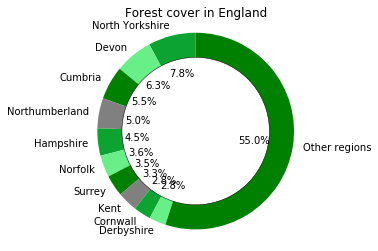

In [96]:
# Example donut chart 
# NOTE - THE COLOURS ARE NOT NECESSARILY THOSE NEEDED FOR PRODUCTION
  
limit = 0
sizes = []
labels = [] 

for r in range(0,10):
    
    try:
        if adm1:
            labels.append(adm2_to_name[newlist[r].get('region')])
        elif adm0:
            labels.append(adm1_to_name[newlist[r].get('region')])
        sizes.append(newlist[r].get('area_ha'))
        
    except:
        break
    limit += 1
      
other_regions=0

for rows in range(limit+1,len(newlist)):
    other_regions += newlist[rows].get('area_ha')

if other_regions != 0:
    labels.append('Other regions')
    sizes.append(other_regions)
            
if adm1:
    title = adm1_to_name[adm1]
elif adm0:
    title = iso_to_countries[adm0]

fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.1f%%',
        shadow=False, startangle=90, colors=['#0da330', '#69ef88','green','grey'])
ax1.axis('equal')
centre_circle = plt.Circle((0,0),0.75,color='black', fc='white',linewidth=0.5)
fig1 = plt.gcf()
fig1.gca().add_artist(centre_circle)
plt.title(f'Forest cover in {title}')
plt.show()

<a id='s10'></a>
### Dynamic Sentence for "Where are Forests Located?" Widget

1. Returns the no of regions responsible for >50% of the regions tree cover extent (adm1)
     - or, the extent (%) that the top 10% of regions are responsible for (adm2)
2. Max and Min extent (%) in that region
3. Average extent (%) that each region contributes to the total

In [97]:
#Calculate total three cover loss at this threshold
total = 0

for i in range(0,len(extent_json)):
    total += newlist[i]['area_ha']

In [98]:
# Calculate % extent for the sub-region (relative to total extent) Also filters out incorrect/duplicated data

correct_list = []
for i in range(0,len(extent_json)):
    if(i != 0 and newlist[i]['region'] != newlist[i-1]['region']):
        correct_list.append(100*newlist[i]['area_ha']/total)
    elif i == 0:
        correct_list.append(100*newlist[i]['area_ha']/total)
correct_list[0:3]

[7.622505706683136, 6.1035816248815475, 5.377519972902983]

In [99]:
#Calculate the mean extent

mean=0
for i in range(0, len(correct_list)):
    
    mean += correct_list[i]
    
mean = mean/len(correct_list)

In [100]:
# Percentile calcs: work out how many regions are responsible for >50% loss
# x is no. of adm regions.
tenth_percentile = int(len(correct_list)/10)
if adm1:
    top_ten_index = tenth_percentile
    total = np.sum(correct_list[0: top_ten_index+1])
     
accumulated_percent = 0
for n, item in enumerate(correct_list):
    accumulated_percent += item
    if accumulated_percent >= 50:
        lower_fity_percentile_regions = n +1
        break

In [101]:
#Extent Stats
extent_stats = { 'max': correct_list[0], 'min': correct_list[len(correct_list)-1], 'avg': mean}
extent_stats

{'avg': 0.8928571428571431,
 'max': 7.622505706683136,
 'min': 0.00012430832888495695}

In [102]:
#Dynamic sentence. For adm2.

if adm1:
    if len(correct_list) > 10:
        print(f"The top {tenth_percentile} sub-regions are responsible for ", end="")
        print(f"{total:,.0f}% of {adm1_to_name[adm1]}'s ", end="")

        if location == 'All Region':
            print(f"regional treecover. ", end="")
        elif (location == 'Mining' or 'Mining in Intact Forest Landscapes' or 'Mining in Plantation Areas'):
             print(f"treecover in areas with {location.lower()}. ", end="")
        else:
            print(f"treecover found in {location.lower()}. ", end="")
   
    print(f"{adm2_to_name[newlist[0].get('region')]} has the largest relative tree cover ", end="")
    print(f"in {adm1_to_name[adm1]}, at {extent_stats['max']:,.0f}% compared to an average ", end="")
    print(f"of {extent_stats['avg']:,.1f}%. ", end="")
    
    
else:
    
#Dynamic sentence. For adm1.
    if len(correct_list) > 10:
        print(f"In {iso_to_countries[adm0]}, {lower_fity_percentile_regions} ", end="")
        print(f"regions represent more than half ({accumulated_percent:,.0f}%) ",end="")

        print(f"of all treecover extent ", end="")
        if location == 'All Region':
            print(f"country-wide. ", end="")
        elif (location == 'Mining' or 'Mining in Intact Forest Landscapes' or 'Mining in Plantation Areas'):
            print(f"in areas with {location.lower()}. ", end="")
        else:
            print(f"found in {location.lower()}. ", end="")
            
    print(f"{adm1_to_name[newlist[0].get('region')]} has the largest relative tree cover ", end="")
    print(f"in {iso_to_countries[adm0]}, at {extent_stats['max']:,.0f}% compared to an average ", end="")
    print(f"of {extent_stats['avg']:,.1f}%. ", end="")

The top 11 sub-regions are responsible for 49% of England's regional treecover. North Yorkshire has the largest relative tree cover in England, at 8% compared to an average of 0.9%. 

<a id='s11'></a>
# WHERE IS THE MOST LOSS OCCURING? Widget

This widget is a mix of a donut chart and a ranked list. It shows tree cover loss by admin region. On hover the pie chart segments display the loss, in ha, for that region.

The time period over which the loss is shown is controlled by the user in the settings. By default it will be set to cover the whole data period (e.g. 2001 - 2016).

The donut chart should display data for the top few admin regions, and group the rest together as 'Other Districts'.

Data:

1. admn-1 and -2 codes
2. forest loss
3. extent

User Variables:

1. year range
2. unit (ha/% of regions extent)
3. locations (all)
4. canopy threshold


In [103]:
# VARIABLES
location = 'All Region'
thresh = 30
adm0 = 'BRA'
adm1 = None
start = 2001     
end = 2016


tags = ["forest_change"]
selectable_polynames = ['gadm28',
                        'mining',
                        'plantations']

In [104]:
# get admin 1 or 2 level human-readable name info as needed:
adm1_to_name = None
adm2_to_name = None

if adm1:
    
    tmp = get_admin2_json(iso=adm0, adm1=adm1)
    adm2_to_name ={}
    for row in tmp:
        adm2_to_name[row.get('adm2')] = row.get('name')

tmp = get_admin1_json(iso=adm0)
adm1_to_name={}
for row in tmp:
    adm1_to_name[row.get('adm1')] = row.get('name') 

In [105]:
def loss_by_multiregion(p_name, adm0, adm1=None, threshold=30):
    if adm1:
        print('Request for  admin-1 areas')
        sql = (f"SELECT adm2, year_data.year as year, "
               f"SUM(year_data.area_loss) as area_loss, "
               f"FROM data "
               f"WHERE polyname = '{p_name}' "
               f"AND iso = '{adm0}' "
               f"AND adm1 = {adm1} AS region"
               f"AND thresh= {threshold} "
               f"GROUP BY adm2, nested(year_data.year)"
               f"ORDER BY adm2")
        return sql
    elif adm0:
        print('Request for  national area')
        sql = (f"SELECT adm1 AS region, year_data.year as year, "
               f"SUM(year_data.area_loss) as area_loss, "
               f"FROM data "
               f"WHERE polyname = '{p_name}' " 
               f"AND iso = '{adm0}' "
               f"AND thresh= {threshold} "
               f"GROUP BY adm1 nested(year_data.year)"
               f"ORDER BY adm1")
        return sql


In [106]:
# Query for loss

url = f"https://production-api.globalforestwatch.org/v1/query/{ds}"
loss_sql = loss_by_multiregion(p_name=polynames[location], adm0=adm0, adm1=adm1, threshold=thresh)

properties = {"sql": loss_sql}
rl = requests.get(url, params = properties)
print(rl.url)
print(f'Status: {rl.status_code}')

loss_data = rl.json()['data']

#Example data structure
loss_data[0:3]

Request for  national area
https://production-api.globalforestwatch.org/v1/query/499682b1-3174-493f-ba1a-368b4636708e?sql=SELECT+adm1+AS+region%2C+year_data.year+as+year%2C+SUM%28year_data.area_loss%29+as+area_loss%2C+FROM+data+WHERE+polyname+%3D+%27gadm28%27+AND+iso+%3D+%27BRA%27+AND+thresh%3D+30+GROUP+BY+adm1+nested%28year_data.year%29ORDER+BY+adm1
Status: 200


[{'area_loss': 67309.77182006836, 'region': 1, 'year': 2001},
 {'area_loss': 68439.01933288574, 'region': 1, 'year': 2002},
 {'area_loss': 37665.79328918457, 'region': 1, 'year': 2003}]

In [107]:
#Query for extent (to calculate percentages)

url = f"https://production-api.globalforestwatch.org/v1/query/{ds}"
extent_sql = multiregion_extent_queries(adm0=adm0, adm1=adm1, p_name=polynames[location], threshold=thresh)

properties = {"sql": extent_sql}
re = requests.get(url, params = properties)
print(re.url)
print(f'Status: {re.status_code}')

extent_data = re.json()['data']

#Example data structure
extent_data[0:3]

Request for adm1 areas
https://production-api.globalforestwatch.org/v1/query/499682b1-3174-493f-ba1a-368b4636708e?sql=SELECT+adm1+as+region%2C+sum%28area_extent%29+as+extent%2C+sum%28area_gadm28%29+as+total+FROM+499682b1-3174-493f-ba1a-368b4636708e+WHERE+iso+%3D+%27BRA%27+AND+thresh+%3D+30+AND+polyname+%3D+%27gadm28%27+GROUP+BY+adm1+ORDER+BY+adm1
Status: 200


[{'extent': 14379381.2578125, 'region': 1, 'total': 15273286.984375},
 {'extent': 582992.8784446716, 'region': 2, 'total': 2775822.3068847656},
 {'extent': 12186407.07421875, 'region': 3, 'total': 14221825.859375}]

In [108]:
# for a specified start and an end year, end up with a json of admin_ID, and loss

# Find out the unique list of regions in the returned array
unique_regions = []
for row in loss_data:
    #print(row)
    tmp_region = row.get('region', None)
    if tmp_region not in unique_regions:
        unique_regions.append(tmp_region)
        
# Loop over that list of regions
loss_json = []
for region in unique_regions:
    tmp_loss = 0
    # gather all yearly data from the loss json object
    for row in loss_data:
        tmp_region = row.get('region', None)
        if tmp_region == region:
            if row.get('year', None) >= start and row.get('year', None) <= end:
                tmp_loss += row.get('area_loss', 0)
    # gather extent data from the extent json object
    tmp_extent = 0
    for row in extent_data:
        if row.get('region') == region:          
            tmp_extent = row.get('extent', None)
            break
    loss_in_percent = tmp_loss/tmp_extent * 100
    loss_json.append({'region':region,'area_loss_ha': tmp_loss, 'area_loss_%':loss_in_percent})
    #print(f"{areaId_to_name[region]} loss between {start} and {end} is {tmp_loss:,.0f}ha or {loss_in_percent:3.2f}%")

loss_json[0:3]

[{'area_loss_%': 6.7488465802538435,
  'area_loss_ha': 970442.380279541,
  'region': 1},
 {'area_loss_%': 11.667659283548259,
  'area_loss_ha': 68021.62270427495,
  'region': 2},
 {'area_loss_%': 2.1042150214087303,
  'area_loss_ha': 256428.20822572708,
  'region': 3}]

In [109]:
#Sort regions by area of loss (DESC)

newlist = sorted(loss_json, key=lambda k: k['area_loss_ha'], reverse=True) 
newlist[0]

{'area_loss_%': 10.302299524871357,
 'area_loss_ha': 11190882.038300753,
 'region': 14}

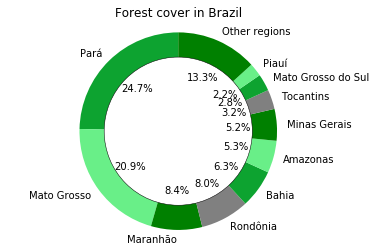

In [110]:
# Example donut chart 
# NOTE - THE COLOURS ARE NOT NECESSARILY THOSE NEEDED FOR PRODUCTION
  
limit = 0
sizes = []
labels = [] 

for r in range(0,10):
    
    try:
        if adm1:
            labels.append(adm2_to_name[newlist[r].get('region')])
        elif adm0:
            labels.append(adm1_to_name[newlist[r].get('region')])
        sizes.append(newlist[r].get('area_loss_ha'))
        
    except:
        break
    limit += 1
      
other_regions=0

for rows in range(limit+1,len(newlist)):
    other_regions += newlist[rows].get('area_loss_ha')

if other_regions != 0:
    labels.append('Other regions')
    sizes.append(other_regions)
            
if adm1:
    title = adm1_to_name[adm1]
elif adm0:
    title = iso_to_countries[adm0]

fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.1f%%',
        shadow=False, startangle=90, colors=['#0da330', '#69ef88','green','grey'])
ax1.axis('equal')
centre_circle = plt.Circle((0,0),0.75,color='black', fc='white',linewidth=0.5)
fig1 = plt.gcf()
fig1.gca().add_artist(centre_circle)
plt.title(f'Forest cover in {title}')
plt.show()

<a id='s12'></a>
### Dynamic Sentence for Loss widget

1. Returns the no of regions responsible for >50% of the regions tree cover loss (adm1)
     - or, the loss (%) that the top 10% of regions are responsible for (adm2)
2. Max and Min loss (%) in that region
3. Average loss (%) that each region contributes to the total

In [111]:
#Calculate total three cover loss at this threshold
total = 0

for i in range(0,len(loss_json)):
    total += newlist[i]['area_loss_ha']

In [112]:
# Calculate % loss for the region (relative to total loss). Also filters out incorrect/duplicated data

correct_list = []
for i in range(0,len(loss_json)):
    if(i != 0 and newlist[i]['region'] != newlist[i-1]['region']):
        correct_list.append(100*newlist[i]['area_loss_ha']/total)
    elif i == 0:
        correct_list.append(100*newlist[i]['area_loss_ha']/total)
correct_list[0:3]

[24.134271543920537, 20.456825325562612, 8.198747151674597]

In [113]:
#Calculate the mean loss

mean=0
for i in range(0, len(correct_list)):
    
    mean += correct_list[i]
    
mean = mean/len(correct_list)

In [114]:
correct_list[0:5]

[24.134271543920537,
 20.456825325562612,
 8.198747151674597,
 7.811200837670242,
 6.138152278215298]

In [115]:
# Percentile calcs: work out how many regions are responsible for >50% loss
# x is no. of adm regions.

if adm1:
    top_ten_index = int(len(correct_list)/10)
    total = np.sum(correct_list[0: top_ten_index+1])
     
accumulated_percent = 0
for n, item in enumerate(correct_list):
    accumulated_percent += item
    if accumulated_percent >= 50:
        lower_fity_percentile_regions = n +1
        break

In [116]:
#Loss Stats
loss_stats = { 'max': correct_list[0], 'min': correct_list[len(correct_list)-1], 'avg': mean}
loss_stats

{'avg': 3.703703703703704,
 'max': 24.134271543920537,
 'min': 0.00497740568918091}

In [117]:
#Dynamic sentence. For adm2.

if adm1:
    if len(correct_list) > 10:
        print(f"The top ten percent of sub-regions were responsible for ", end="")
        print(f"{total:,.0f}% of {areaId_to_name[adm1]}'s total treecover loss ", end="")

        if location == 'All Region':
            print(f"across the region. ", end="")
        elif (location == 'Mining' or 'Mining in Intact Forest Landscapes' or 'Mining in Plantation Areas'):
             print(f"in areas with {location.lower()}. ", end="")
        else:
            print(f"found in {location.lower()}. ", end="")
   
    print(f"{adm2_to_name[newlist[0].get('region')]} experienced the largest relative treecover loss ", end="")
    print(f"in {adm1_to_name[adm1]}, at {loss_stats['max']:,.0f}% compared to an average ", end="")
    print(f"of {loss_stats['avg']:,.1f}%. ", end="")
    
else:
    
#Dynamic sentence. For adm1.
    if len(correct_list) > 10:
        print(f"In {iso_to_countries[adm0]}, {lower_fity_percentile_regions} ", end="")
        print(f"regions were responsible for more than half ({accumulated_percent:,.0f}%) ",end="")

        print(f"of all treecover loss ", end="")
        if location == 'All Region':
            print(f"country-wide. ", end="")
        elif (location == 'Mining' or 'Mining in Intact Forest Landscapes' or 'Mining in Plantation Areas'):
            print(f"in areas with {location.lower()}. ", end="")
        else:
            print(f"found in {location.lower()}. ", end="")
            
    print(f"{adm1_to_name[newlist[0].get('region')]} has the largest relative treecover loss ", end="")
    print(f"in {iso_to_countries[adm0]}, at {loss_stats['max']:,.0f}% compared to an average ", end="")
    print(f"of {loss_stats['avg']:,.1f}%. ", end="")

In Brazil, 3 regions were responsible for more than half (53%) of all treecover loss country-wide. Pará has the largest relative treecover loss in Brazil, at 24% compared to an average of 3.7%. 

<a id='s13'></a>
# "Where is the Most Gain Happening?" Widget

This widget is a mix of a donut chart and a ranked list, similar to the previous extent ranking widget. It shows tree cover gain by admin region. On hover the pie chart segments display the gain, in ha, for that region.

The donut chart should display data for the top few admin regions, and group the rest together as 'Other Districts'.

Displayed data, ordered by DESC area(ha). 

1. Admin-2 or -1 name
2. % of total extent
3. Area of extent (ha)

User Variables:

1. Hanson extent ('Gadm28'), IFL2013, Plantations or Intact forest
2. Admin-0 and -1 region

In [118]:
#DATASET (CONTAINS EVERYTHING NOW)

ds = '499682b1-3174-493f-ba1a-368b4636708e'  # ADMIN 2 level data

In [119]:
# VARIABLES

location = 'All Region'   # 'plantations', 'ifl_2013', or 'primary_forests'... here 'gadm28'=default
threshold = 0             # 0,10,15,20,25,30,50,75,100 
adm0 = 'GBR'
adm1 = 1            # To rank admin 1 areas, set to None
                      # To rank admin 2 areas, specify an admin 1 level

tags = ["forest_change"]
selectable_polynames = ['gadm28',
                        'mining',
                        'plantations']


In [120]:
# get admin 1 or 2 level human-readable name info as needed:
adm1_to_name = None
adm2_to_name = None

if adm1:
    
    tmp = get_admin2_json(iso=adm0, adm1=adm1)
    adm2_to_name ={}
    for row in tmp:
        adm2_to_name[row.get('adm2')] = row.get('name')

tmp = get_admin1_json(iso=adm0)
adm1_to_name={}
for row in tmp:
    adm1_to_name[row.get('adm1')] = row.get('name') 

In [121]:
# Returns json object containing admin-codes, total area and extent (both in ha)
# If adm1 is not specified, it returns the total values for each adm1 region
# Else, returns the adm2 values within that adm1 region
# You may also specify a polyname (intersecting area) e.g. 'extent and % of plantations only'
# By default polyname is 'gadm28' (all forest extent)

def multiregion_gain_queries(adm0, adm1=None, p_name='gadm28', threshold=30):
    if adm0 and not adm1:
        print('Request for adm1 areas')
        sql = ("SELECT adm1 as region, sum(area_gain) as gain, sum(area_gadm28) as total "
               f"FROM {ds} "
               f"WHERE iso = '{adm0}' "
               f"AND thresh = {threshold} "
               f"AND polyname = '{p_name}' "
               f"GROUP BY adm1 "
               f"ORDER BY adm1")
    elif adm0 and adm1:
        print('Request for adm2 areas')
        sql = ("SELECT adm2 as region, area_gain as gain, area_gadm28 as total "
                f"FROM {ds} "
                f"WHERE iso = '{adm0}' "
                f"AND thresh = {threshold} "
                f"AND polyname = '{p_name}' "
                f"AND adm1 = '{adm1}' ")
    return sql

In [122]:
# Takes the data from the above api call and generates a list containing the relevant data: 
# Admin-Code, Forest Extent Area, Percentage of Admin region
# NOTE that 'area_percent' is the forest extent area relative to teh area of its admin-region.

def data_output(data, adm1=None):
    
    output = []
    for d in range(0, len(data)):
        tmp_ = {

            'region': data[d]['region'],
            'area_gain_percent': (100*data[d]['gain']/data[d]['total']),
            'area_gain_ha': data[d]['gain']

        }
        output.append(tmp_)

    return output

In [123]:
# Example sql and returned data


url = f"https://production-api.globalforestwatch.org/v1/query/{ds}"
sql = multiregion_gain_queries(adm0, adm1, polynames[location], threshold)


properties = {"sql": sql}
r = requests.get(url, params = properties)
print(r.url)
print(f'Status: {r.status_code}')

data = r.json()['data']

data[0:3]

Request for adm2 areas
https://production-api.globalforestwatch.org/v1/query/499682b1-3174-493f-ba1a-368b4636708e?sql=SELECT+adm2+as+region%2C+area_gain+as+gain%2C+area_gadm28+as+total+FROM+499682b1-3174-493f-ba1a-368b4636708e+WHERE+iso+%3D+%27GBR%27+AND+thresh+%3D+0+AND+polyname+%3D+%27gadm28%27+AND+adm1+%3D+%271%27+
Status: 200


[{'_id': 'AWBQUkRMJ0wPeEVRkCSN',
  'gain': 1564.92619773,
  'region': 94,
  'total': 167991.495674},
 {'_id': 'AWBQUkRMJ0wPeEVRkCSQ',
  'gain': 154.606269591,
  'region': 85,
  'total': 56777.939606199994},
 {'_id': 'AWBQUkRMJ0wPeEVRkCSV',
  'gain': 1415.2203164999999,
  'region': 90,
  'total': 260687.085466}]

In [124]:
# After generating list return wanted metrics
# (NOTE! This is not sorted.)

gain_json = data_output(data, adm1)
gain_json[0:3]


[{'area_gain_ha': 1564.92619773,
  'area_gain_percent': 0.9315508451492425,
  'region': 94},
 {'area_gain_ha': 154.606269591,
  'area_gain_percent': 0.2722998944014471,
  'region': 85},
 {'area_gain_ha': 1415.2203164999999,
  'area_gain_percent': 0.542880869595122,
  'region': 90}]

In [125]:
#Sort regions by area of loss (DESC)

newlist = sorted(gain_json, key=lambda k: k['area_gain_ha'], reverse=True) 
newlist[0:3]


[{'area_gain_ha': 10347.3066765,
  'area_gain_percent': 2.045651543674968,
  'region': 71},
 {'area_gain_ha': 5224.37817512,
  'area_gain_percent': 0.7620487396510351,
  'region': 18},
 {'area_gain_ha': 5154.67946192,
  'area_gain_percent': 0.6467029508515596,
  'region': 69}]

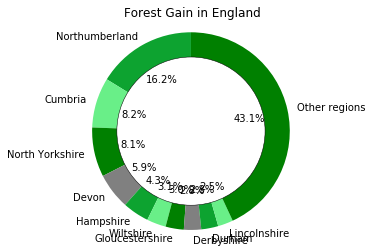

In [126]:
# Example donut chart 
# NOTE - THE COLOURS ARE NOT NECESSARILY THOSE NEEDED FOR PRODUCTION
  
limit = 0
sizes = []
labels = [] 

for r in range(0,10):
    
    try:
        if adm1:
            labels.append(adm2_to_name[newlist[r].get('region')])
        elif adm0:
            labels.append(adm1_to_name[newlist[r].get('region')])
        sizes.append(newlist[r].get('area_gain_ha'))
        
    except:
        break
    limit += 1
      
other_regions=0

for rows in range(limit+1,len(newlist)):
    other_regions += newlist[rows].get('area_gain_ha')

if other_regions != 0:
    labels.append('Other regions')
    sizes.append(other_regions)
            
if adm1:
    title = adm1_to_name[adm1]
elif adm0:
    title = iso_to_countries[adm0]

fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.1f%%',
        shadow=False, startangle=90, colors=['#0da330', '#69ef88','green','grey'])
ax1.axis('equal')
centre_circle = plt.Circle((0,0),0.75,color='black', fc='white',linewidth=0.5)
fig1 = plt.gcf()
fig1.gca().add_artist(centre_circle)
plt.title(f'Forest Gain in {title}')
plt.show()

<a id='s14'></a>
### Dynamic Sentence for "Where is forest gain Located?" Widget

1. Returns the no of regions responsible for >50% of the regions tree cover extent (adm1)
     - or, the extent (%) that the top 10% of regions are responsible for (adm2)
2. Max and Min extent (%) in that region
3. Average extent (%) that each region contributes to the total

In [127]:
#Calculate total three cover loss at this threshold
total = 0

for i in range(0,len(gain_json)):
    total += newlist[i]['area_gain_ha']

In [128]:
# Calculate % extent for the sub-region (relative to total extent) Also filters out incorrect/duplicated data

correct_list = []
for i in range(0,len(gain_json)):
    if(i != 0 and newlist[i]['region'] != newlist[i-1]['region']):
        correct_list.append(100*newlist[i]['area_gain_ha']/total)
    elif i == 0:
        correct_list.append(100*newlist[i]['area_gain_ha']/total)
correct_list[0:3]

[15.831588269839779, 7.993404160164861, 7.886763720790806]

In [129]:
#Calculate the mean extent

mean=0
for i in range(0, len(correct_list)):
    
    mean += correct_list[i]
    
mean = mean/len(correct_list)

In [130]:
# Percentile calcs: work out how many regions are responsible for >50% loss
# x is no. of adm regions.
tenth_percentile = int(len(correct_list)/10)
if adm1:
    top_ten_index = tenth_percentile
    total = np.sum(correct_list[0: top_ten_index+1])
     
accumulated_percent = 0
for n, item in enumerate(correct_list):
    accumulated_percent += item
    if accumulated_percent >= 50:
        lower_fity_percentile_regions = n +1
        break

In [131]:
#Extent Stats
gain_stats = { 'max': correct_list[0], 'min': correct_list[len(correct_list)-1], 'avg': mean}
gain_stats

{'avg': 0.892857142857143, 'max': 15.831588269839779, 'min': 0.0}

In [132]:
#Dynamic sentence. For adm2.

if adm1:
    if len(correct_list) > 10:
        print(f"The top {tenth_percentile} sub-regions were responsible for ", end="")
        print(f"{total:,.0f}% of {adm1_to_name[adm1]}'s ", end="")

        if location == 'All Region':
            print(f"regional treecover gain. ", end="")
        elif (location == 'Mining' or 'Mining in Intact Forest Landscapes' or 'Mining in Plantation Areas'):
             print(f"treecover gain in areas with {location.lower()}. ", end="")
        else:
            print(f"treecover gain found in {location.lower()}. ", end="")
   
    print(f"{adm2_to_name[newlist[0].get('region')]} experience the largest relative treecover gain ", end="")
    print(f"in {adm1_to_name[adm1]}, at {gain_stats['max']:,.0f}% compared to an average ", end="")
    print(f"of {gain_stats['avg']:,.1f}%. ", end="")
    
    
else:
    
#Dynamic sentence. For adm1.
    if len(correct_list) > 10:
        print(f"In {iso_to_countries[adm0]}, {lower_fity_percentile_regions} ", end="")
        print(f"regions represent more than half ({accumulated_percent:,.0f}%) ",end="")
        print(f"of all treecover gain ", end="")
        if location == 'All Region':
            print(f"country-wide. ", end="")
        elif (location == 'Mining' or 'Mining in Intact Forest Landscapes' or 'Mining in Plantation Areas'):
            print(f"in areas with {location.lower()}. ", end="")
        else:
            print(f"found in {location.lower()}. ", end="")
            
    print(f"{adm1_to_name[newlist[0].get('region')]} has the largest relative treecover gain ", end="")
    print(f"in {iso_to_countries[adm0]}, at {gain_stats['max']:,.0f}% compared to an average ", end="")
    print(f"of {gain_stats['avg']:,.1f}%. ", end="")

The top 11 sub-regions were responsible for 60% of England's regional treecover gain. Northumberland experience the largest relative treecover gain in England, at 16% compared to an average of 0.9%. 

<a id='s15'></a>
# Plantations Area widget

Shows the area of plantation in a country (adm0 level) visualised as a pie chart, where each type of plantation is represented as a different colour vs. non-plantation area. This widget only applies to a small number of countries. Plantations by SPECIES should be defauly

Data:

1. admn-0, -1, -2
2. polyname = 'plantations'
3. plantation type ('bound1') or species ('bound2')
4. plantation area (area_poly_aoi)
5. other areas (area_gadm28 - sum of others)

User Variables:

1. unit (ha/% of regions extent)
2. Adm0, 1, 2
3. Threshold

How to:

- collect gadm28 extent for region
- collect extent area for plantation subclasses
- Outside Plantations in ha = gadm28 - sum(plantation subclasses)
- Outside Plantations in % = 100 * { gadm28 - sum(plantation subclasses) / gadm28 }

In [133]:
# VARIABLES

thresh = 0            # 0,10,15,20,25,30,50,75,100 

adm0 = 'BRA'          # 'BRA', 'IDN', 'MYS', 'COL', 'KHM', 'LBR', 'PER'
adm1 = None             # To rank admin 1 areas, set to None
adm2 = None                     # To rant admin 2 areas, specify an admin 1 level

tags = ["land_cover", "land_use"]
selectable_polynames = ['gadm28', 'plantations']

# By Plantation *Type*

In [134]:
def plantations_type_queries(adm0, adm1=None, adm2=None, threshold=30):
    if adm2:
        print('Request for adm2 area')
        sql = (f"SELECT SUM(area_extent) AS plantation_extent "
               f"FROM data "
               f"WHERE iso = '{adm0}' "
               f"AND adm1 = {adm1} "
               f"AND adm2 = {adm2}"
               f"AND thresh = {threshold} "
               f"AND polyname = 'plantations' "
               f"GROUP BY bound1 "
               f"ORDER BY plantation_extent DESC")
        return sql
    elif adm1:
        print('Request for  adm1 area')
        sql = (f"SELECT SUM(area_extent) AS plantation_extent "
               f"FROM data "
               f"WHERE iso = '{adm0}' "
               f"AND adm1 = {adm1} "
               f"AND thresh = {threshold} "
               f"AND polyname = 'plantations' "
               f"GROUP BY bound1 "
               f"ORDER BY plantation_extent DESC")
        return sql
    elif adm0:
        print('Request for  adm0 area')
        sql = (f"SELECT SUM(area_extent) AS plantation_extent "
               f"FROM data "
               f"WHERE iso = '{adm0}' "
               f"AND thresh = {threshold} "
               f"AND polyname = 'plantations' "
               f"GROUP BY bound1 "
               f"ORDER BY plantation_extent DESC")
        return sql

In [135]:
# Get the sum of extent in region, grouped by TYPE
url = f"https://production-api.globalforestwatch.org/v1/query/{ds}"

sql = plantations_type_queries(adm0=adm0, adm1=adm1, adm2=adm2, threshold=thresh)

properties = {"sql": sql}
r = requests.get(url, params = properties)
print(r.url)
print(f'Status: {r.status_code}')

plantations_ha = r.json().get('data')
plantations_ha


Request for  adm0 area
https://production-api.globalforestwatch.org/v1/query/499682b1-3174-493f-ba1a-368b4636708e?sql=SELECT+SUM%28area_extent%29+AS+plantation_extent+FROM+data+WHERE+iso+%3D+%27BRA%27+AND+thresh+%3D+0+AND+polyname+%3D+%27plantations%27+GROUP+BY+bound1+ORDER+BY+plantation_extent+DESC
Status: 200


[{'bound1': 'Large industrial plantation',
  'plantation_extent': 4781184.802494563},
 {'bound1': 'Clearing/ very young plantation',
  'plantation_extent': 415829.0335399434},
 {'bound1': 'Mosaic of medium-sized plantations',
  'plantation_extent': 45769.13921111822},
 {'bound1': 'Mosaic of small-sized plantations',
  'plantation_extent': 2381.0843410491943}]

In [136]:
# Get total extent (using gadm28 p_name)
url = f"https://production-api.globalforestwatch.org/v1/query/{ds}"
sql = extent_queries('gadm28', adm0, adm1=None, adm2 = None, threshold=thresh)

properties = {"sql": sql}
r = requests.get(url, params = properties)
print(r.url)
print(f'Status: {r.status_code}')
extent = r.json().get('data')
extent

Request for  adm0 area
https://production-api.globalforestwatch.org/v1/query/499682b1-3174-493f-ba1a-368b4636708e?sql=SELECT+SUM%28area_extent%29+as+value%2C+SUM%28area_gadm28%29+as+total_area+FROM+data+WHERE+iso+%3D+%27BRA%27+AND+thresh+%3D+0+AND+polyname+%3D+%27gadm28%27
Status: 200


[{'total_area': 850033236.0091553, 'value': 566751560.1416798}]

In [137]:
#Calculate the cpombined plantation area, and populate size(ha) and label arrays

total_plantation_area = 0
sizes = []
labels = []

for p in plantations_ha:
    if p.get('plantation_extent') != 0:
        total_plantation_area += p.get('plantation_extent')
        sizes.append(p.get('plantation_extent'))
        labels.append(p.get('bound1'))
total_plantation_area


5245164.059586674

In [138]:
# calculate percentages relative to total plantation extent
plantation_percent = []

for s in sizes:
    if s != 0:
        plantation_percent.append(100*s/total_plantation_area)
plantation_percent

[91.1541516753115, 7.927855617402963, 0.8725969043325766, 0.04539580295295524]

In [139]:
#Calculate extent outside of plantations

other_areas = extent[0].get('value') - total_plantation_area
other_areas

561506396.0820931

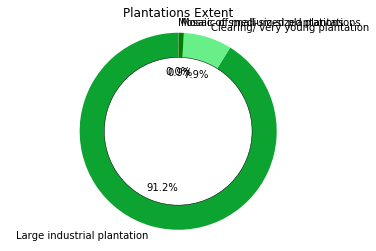

In [140]:
# Example donut chart 
# NOTE - THE COLOURS ARE NOT NECESSARILY THOSE NEEDED FOR PRODUCTION
            
# Use the below if you wish to include 'Other areas' data (doesn't look great in most cases!)

"""
labels.append('Other areas')
sizes.append(other_areas)
"""

fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.1f%%',
        shadow=False, startangle=90, colors=['#0da330', '#69ef88','green','grey'])
ax1.axis('equal')
centre_circle = plt.Circle((0,0),0.75,color='black', fc='white',linewidth=0.5)
fig1 = plt.gcf()
fig1.gca().add_artist(centre_circle)
plt.title('Plantations Extent')
plt.show()

<a id='s16'></a>
### Dynamic Sentence for TYPE

In [141]:
# get admin 1 or 2 level human-readable name info as needed:
adm1_to_name = None
adm2_to_name = None

if adm2:
    
    tmp = get_admin2_json(iso=adm0, adm1=adm1)
    adm2_to_name ={}
    for row in tmp:
        adm2_to_name[row.get('adm2')] = row.get('name')
elif adm1:

    tmp = get_admin1_json(iso=adm0)
    adm1_to_name={}
    for row in tmp:
        adm1_to_name[row.get('adm1')] = row.get('name') 

In [142]:
#Dynamic sentence. For type.
if adm2:
    region_name = adm2_to_name[adm2]
elif adm1:
    region_name = adm1_to_name[adm1]
elif adm0:
    region_name = iso_to_countries[adm0]

print(f"The largest plantation type in {region_name} by area are ", end="")
print(f"{plantation_type_dict[plantations_ha[0].get('bound1')]} plantations, ", end="")
print(f"containing {plantations_ha[0].get('plantation_extent'):,.0f}ha of tree cover. ", end="")

print(f"This represents {100*plantations_ha[0].get('plantation_extent')/ extent[0].get('value'):.2f}% ", end="")
print(f"of {region_name}'s total tree cover extent. ", end="")


The largest plantation type in Brazil by area are large industrial plantations, containing 4,781,185ha of tree cover. This represents 0.84% of Brazil's total tree cover extent. 

<a id='s17'></a>
# By Plantation *Species* (default)

In [143]:
# VARIABLES

thresh = 0            # 0,10,15,20,25,30,50,75,100 

adm0 = 'BRA'          # 'BRA', 'IDN', 'MYS', 'COL', 'KHM', 'LBR', 'PER'
adm1 = None             # To rank admin 1 areas, set to None
adm2 = None                     # To rant admin 2 areas, specify an admin 1 level

tags = ["land_cover", "land_use"]
selectable_polynames = ['gadm28', 'plantations']

In [144]:
def plantations_species_queries(adm0, adm1=None, adm2=None, threshold=30):
    if adm2:
        print('Request for adm2 area')
        sql = (f"SELECT SUM(area_extent) AS plantation_extent "
               f"FROM data "
               f"WHERE iso = '{adm0}' "
               f"AND adm1 = {adm1} "
               f"AND adm2 = {adm2}"
               f"AND thresh = {threshold} "
               f"AND polyname = 'plantations' "
               f"GROUP BY bound2 "
               f"ORDER BY plantation_extent DESC")
        return sql
    elif adm1:
        print('Request for  adm1 area')
        sql = (f"SELECT SUM(area_extent) AS plantation_extent "
               f"FROM data "
               f"WHERE iso = '{adm0}' "
               f"AND adm1 = {adm1} "
               f"AND thresh = {threshold} "
               f"AND polyname = 'plantations' "
               f"GROUP BY bound2 "
               f"ORDER BY plantation_extent DESC")
        return sql
    elif adm0:
        print('Request for  adm0 area')
        sql = (f"SELECT SUM(area_extent) AS plantation_extent "
               f"FROM data "
               f"WHERE iso = '{adm0}' "
               f"AND thresh = {threshold} "
               f"AND polyname = 'plantations' "
               f"GROUP BY bound2 "
               f"ORDER BY plantation_extent DESC")
        return sql

In [145]:
# Get the sum of extent in region, grouped by TYPE
url = f"https://production-api.globalforestwatch.org/v1/query/{ds}"

sql = plantations_species_queries(adm0=adm0, adm1=adm1, adm2=adm2, threshold=thresh)

properties = {"sql": sql}
r = requests.get(url, params = properties)
print(r.url)
print(f'Status: {r.status_code}')

plantations_ha = r.json().get('data')
plantations_ha


Request for  adm0 area
https://production-api.globalforestwatch.org/v1/query/499682b1-3174-493f-ba1a-368b4636708e?sql=SELECT+SUM%28area_extent%29+AS+plantation_extent+FROM+data+WHERE+iso+%3D+%27BRA%27+AND+thresh+%3D+0+AND+polyname+%3D+%27plantations%27+GROUP+BY+bound2+ORDER+BY+plantation_extent+DESC
Status: 200


[{'bound2': 'Wood fiber / timber', 'plantation_extent': 4251017.472964287},
 {'bound2': 'Recently cleared', 'plantation_extent': 415829.0335399434},
 {'bound2': 'Unknown', 'plantation_extent': 244621.9651652798},
 {'bound2': 'Fruit', 'plantation_extent': 151119.37168298662},
 {'bound2': 'Oil palm', 'plantation_extent': 88222.76972579956},
 {'bound2': 'Other mix', 'plantation_extent': 58905.92364119738},
 {'bound2': 'Rubber', 'plantation_extent': 35447.52286718041}]

In [146]:
# Get total extent (using gadm28 p_name)
url = f"https://production-api.globalforestwatch.org/v1/query/{ds}"
sql = extent_queries('gadm28', adm0, adm1=None, adm2 = None, threshold=thresh)

properties = {"sql": sql}
r = requests.get(url, params = properties)
print(r.url)
print(f'Status: {r.status_code}')
extent = r.json().get('data')
extent

Request for  adm0 area
https://production-api.globalforestwatch.org/v1/query/499682b1-3174-493f-ba1a-368b4636708e?sql=SELECT+SUM%28area_extent%29+as+value%2C+SUM%28area_gadm28%29+as+total_area+FROM+data+WHERE+iso+%3D+%27BRA%27+AND+thresh+%3D+0+AND+polyname+%3D+%27gadm28%27
Status: 200


[{'total_area': 850033236.0091553, 'value': 566751560.1416798}]

In [147]:
#Calculate the cpombined plantation area, and populate size(ha) and label arrays

total_plantation_area = 0
sizes = []
labels = []

for p in plantations_ha:
    if p.get('plantation_extent') != 0:
        total_plantation_area += p.get('plantation_extent')
        sizes.append(p.get('plantation_extent'))
        labels.append(p.get('bound2'))
total_plantation_area


5245164.059586674

In [148]:
# calculate percentages relative to total plantation extent
plantation_percent = []

for s in sizes:
    if s != 0:
        plantation_percent.append(100*s/total_plantation_area)
plantation_percent

[81.04641579694025,
 7.927855617402963,
 4.663761941214787,
 2.8811181112015594,
 1.6819830366326356,
 1.1230520718133505,
 0.675813424794452]

In [149]:
#Calculate extent outside of plantations

other_areas = extent[0].get('value') - total_plantation_area
other_areas

561506396.0820931

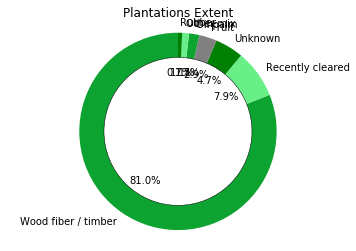

In [150]:
# Example donut chart 
# NOTE - THE COLOURS ARE NOT NECESSARILY THOSE NEEDED FOR PRODUCTION
            
# Use the below if you wish to include 'Other areas' data (doesn't look great in most cases!)

"""
labels.append('Other areas')
sizes.append(other_areas)
"""

fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.1f%%',
        shadow=False, startangle=90, colors=['#0da330', '#69ef88','green','grey'])
ax1.axis('equal')
centre_circle = plt.Circle((0,0),0.75,color='black', fc='white',linewidth=0.5)
fig1 = plt.gcf()
fig1.gca().add_artist(centre_circle)
plt.title('Plantations Extent')
plt.show()

<a id='s18'></a>
### Dynamic Sentence for SPECIES

In [151]:
# get admin 1 or 2 level human-readable name info as needed:
adm1_to_name = None
adm2_to_name = None

if adm2:
    
    tmp = get_admin2_json(iso=adm0, adm1=adm1)
    adm2_to_name ={}
    for row in tmp:
        adm2_to_name[row.get('adm2')] = row.get('name')
elif adm1:

    tmp = get_admin1_json(iso=adm0)
    adm1_to_name={}
    for row in tmp:
        adm1_to_name[row.get('adm1')] = row.get('name') 

In [152]:
#Dynamic sentence. For species.
if adm2:
    region_name = adm2_to_name[adm2]
elif adm1:
    region_name = adm1_to_name[adm1]
elif adm2:
    region_name = iso_to_countries[iso]

print(f"In {region_name}, {plantation_species_dict[plantations_ha[0].get('bound2')]} ", end="")
print(f"plantations represent the largest plantation type by species, ", end="")
print(f"spanning {plantations_ha[0].get('plantation_extent'):,.0f}ha. ", end="")

if len(plantations_ha)-1 > 1:
    print(f"The remaining {(total_plantation_area - plantations_ha[0].get('plantation_extent')):,.0f}ha ", end="")
    print(f"of tree cover is distributed between {len(plantations_ha)-1} other plantation types. ", end="")
elif len(plantations_ha)-1 == 1:
    print(f"The remaining {(total_plantation_area - plantations_ha[0].get('plantation_extent')):,.0f}ha ", end="")
    print(f"of tree cover is found in {plantations_ha[1].get('bound2')} plantations. ", end="")
elif len(plantations_ha)-1 == 0:
    print(f"All tree cover in {region_name} is found in this plantatio type. ", end="")

In Brazil, wood fiber and timber plantations represent the largest plantation type by species, spanning 4,251,017ha. The remaining 994,147ha of tree cover is distributed between 6 other plantation types. 

# Ranked Plantations Stacked Barchart (by type)

Displays the Top 5 sub-regions ranked by the % of plantation cover relative to total area, containing tree plantations in a horizontal bar chart. Each bar is broken into the sub-categories (type or species).

Each bar is made up of 4 subcategories that should add to 100%.

Subcategory % calculated by dividing the extent by the total extent of plantations in the region

In [153]:
# VARIABLES

thresh = 0               # 0,10,15,20,25,30,50,75,100 
adm0 = 'BRA'
adm1 = None          
adm2 = None  

extent_year = 2000       #2000, 2010

tags = ["land_cover", "land_use"]
selectable_polynames = ['gadm28', 'plantations']

In [154]:
# Get the total extent of each region
url = f"https://production-api.globalforestwatch.org/v1/query/{ds}"

sql = multiregion_extent_queries(adm0=adm0, adm1=adm1, p_name='gadm28', threshold=thresh)

properties = {"sql": sql}
r = requests.get(url, params = properties)
print(r.url)
print(f'Status: {r.status_code}')
extent_total = r.json().get('data')
extent_total[0:3]

Request for adm1 areas
https://production-api.globalforestwatch.org/v1/query/499682b1-3174-493f-ba1a-368b4636708e?sql=SELECT+adm1+as+region%2C+sum%28area_extent%29+as+extent%2C+sum%28area_gadm28%29+as+total+FROM+499682b1-3174-493f-ba1a-368b4636708e+WHERE+iso+%3D+%27BRA%27+AND+thresh+%3D+0+AND+polyname+%3D+%27gadm28%27+GROUP+BY+adm1+ORDER+BY+adm1
Status: 200


[{'extent': 14502759.1015625, 'region': 1, 'total': 15273286.984375},
 {'extent': 800115.4713287354, 'region': 2, 'total': 2775822.3068847656},
 {'extent': 12382432.1640625, 'region': 3, 'total': 14221825.859375}]

In [155]:
# Gets plantation areas by type, for each subregion
url = f"https://production-api.globalforestwatch.org/v1/query/{ds}"

sql = (f"SELECT SUM(area_extent) AS plantation_extent FROM {ds} WHERE iso = 'BRA' "
       f"AND thresh = 0 AND polyname = 'plantations' "
       f"GROUP BY adm1, bound1 ORDER BY plantation_extent DESC")

properties = {"sql": sql}
r = requests.get(url, params = properties)
print(r.url)
print(f'Status: {r.status_code}')
plantations_areas = r.json().get('data')
plantations_areas[0:3]

https://production-api.globalforestwatch.org/v1/query/499682b1-3174-493f-ba1a-368b4636708e?sql=SELECT+SUM%28area_extent%29+AS+plantation_extent+FROM+499682b1-3174-493f-ba1a-368b4636708e+WHERE+iso+%3D+%27BRA%27+AND+thresh+%3D+0+AND+polyname+%3D+%27plantations%27+GROUP+BY+adm1%2C+bound1+ORDER+BY+plantation_extent+DESC
Status: 200


[{'adm1': 13,
  'bound1': 'Large industrial plantation',
  'plantation_extent': 884758.8332473561},
 {'adm1': 13,
  'bound1': 'Clearing/ very young plantation',
  'plantation_extent': 134288.48072965443},
 {'adm1': 13,
  'bound1': 'Mosaic of small-sized plantations',
  'plantation_extent': 1033.8712158203125}]

In [156]:
#Formats data into a usable json object
def format_plantations_data(plantations_areas, extent_total, adm0, adm1=None, p_type='species'):
    if adm1:
        # Find out the unique list of regions in the returned array
        unique_regions = []
        for row in plantations_areas:
            #print(row)
            tmp_region = row.get('adm2', None)
            if tmp_region not in unique_regions:
                unique_regions.append(tmp_region)

        # Loop over that list of regions
        plantations_json = []
        for region in unique_regions:
            tmp_p = 0
            # gather all yearly data from the loss json object
            for row in plantations_areas:
                tmp_region = row.get('adm2', None)
                if tmp_region == region:
                    tmp_p += row.get('plantation_extent', 0)
            #get extent
            tmp_t=0
            for row in extent_total:
                if row.get('region') == region:
                    tmp_t = row.get('extent')
                    break
            # gather extent data from the extent json object
            tmp_data = []
            for row in plantations_areas:
                if row.get('adm2') == region: 
                    if p_type == 'type':
                        tmp_data.append([row.get('bound1'), row.get('plantation_extent')])
                    else:
                        tmp_data.append([row.get('bound2'), row.get('plantation_extent')])

            plantations_json.append({'region':region,
                                     'data': tmp_data,
                                     'plantations_total': tmp_p,
                                     'perc': 100*tmp_p/tmp_t,
                                     'region_total': tmp_t
                                    })

    elif adm0:

        # Find out the unique list of regions in the returned array
        unique_regions = []
        for row in plantations_areas:
            #print(row)
            tmp_region = row.get('adm1', None)
            if tmp_region not in unique_regions:
                unique_regions.append(tmp_region)

        # Loop over that list of regions
        plantations_json = []
        for region in unique_regions:
            tmp_p = 0
            # gather all yearly data from the loss json object
            for row in plantations_areas:
                tmp_region = row.get('adm1', None)
                if tmp_region == region:
                    tmp_p += row.get('plantation_extent', 0)
            #get extent
            tmp_t=0
            for row in extent_total:
                if row.get('region') == region:
                    tmp_t = row.get('extent')
                    break
            # gather extent data from the extent json object
            tmp_data = []
            for row in plantations_areas:
                if row.get('adm1') == region: 
                    if p_type == 'type':
                        tmp_data.append([row.get('bound1'), row.get('plantation_extent')])
                    else:
                        tmp_data.append([row.get('bound2'), row.get('plantation_extent')])

            plantations_json.append({'region':region,
                                     'data': tmp_data,
                                     'plantations_total': tmp_p,
                                     'perc': 100*tmp_p/tmp_t,
                                     'region_total': tmp_t
                                    })

    return plantations_json


In [157]:
plantations_json = format_plantations_data(plantations_areas, extent_total, adm0, adm1, 'type')

In [158]:
#Sort regions by % area of plantations (DESC)

sorted_list1 = sorted(plantations_json, key=lambda k: k['perc'], reverse=True) 
sorted_list1[0]

{'data': [['Large industrial plantation', 895171.1094231904],
  ['Clearing/ very young plantation', 22645.54149529338]],
 'perc': 13.018225543693056,
 'plantations_total': 917816.6509184837,
 'region': 25,
 'region_total': 7050243.8895225525}

In [159]:
#Collects data in a presentable way.
#The following code collects data into the correct groups so that a stacked bar can be implemented
# For each adm region this collects the extents by type and calaculates its percentage relative to 
# total plantation extent
lip = []
vyp = []
ssp = []
msp = []
region = []

#We want the top 5 regions by plantation cover relative to total extent
max_num = 5


for i in range(0,max_num):
    
    length = len(sorted_list1[i].get('data'))
    region.append(str(sorted_list1[i].get('region')))
    flag = 0
    
    for j in range(0,length):
        
        if sorted_list1[i].get('data')[j][0] =='Large industrial plantation':
            lip.append(100 * sorted_list1[i].get('data')[j][1] / sorted_list1[i].get('plantations_total'))
            break
        elif flag == length-1:
            lip.append(0)
        else:
            flag += 1
    flag = 0
    for j in range(0,length):
        
        if sorted_list1[i].get('data')[j][0] =='Clearing/ very young plantation':
            vyp.append(100 * sorted_list1[i].get('data')[j][1] / sorted_list1[i].get('plantations_total'))
            break
        elif flag == length-1:
            vyp.append(0)
        else:
            flag += 1
    flag = 0        
    for j in range(0,length):
        
        if sorted_list1[i].get('data')[j][0] =='Mosaic of small-sized plantations':
            ssp.append(100 * sorted_list1[i].get('data')[j][1] / sorted_list1[i].get('plantations_total'))
            break
        elif flag == length-1:
            ssp.append(0)
        else:
            flag += 1
    flag = 0
    for j in range(0,length):
        
        if sorted_list1[i].get('data')[j][0] =='Mosaic of medium-sized plantations':
            msp.append(100 * sorted_list1[i].get('data')[j][1] / sorted_list1[i].get('plantations_total'))
            break
        elif flag == length-1:
            msp.append(0)
        else:
            flag += 1
            

In [160]:
#create a json of data
d1 = {
    'Large industrial plantation': lip,
    'Clearing/ very young plantation': vyp,
    'Mosaic of small-sized plantations': ssp,
    'Mosaic of medium-sized plantations': msp
    
}

In [161]:
#create dataframe to visualise using pandas
df1 = pd.DataFrame(data=d1)
df1

Clearing/ very young plantation  Large industrial plantation  \
0                         2.467327                    97.532673   
1                         7.332298                    92.667702   
2                         6.973439                    93.026561   
3                        13.693243                    86.306757   
4                         3.530766                    96.469234   

   Mosaic of medium-sized plantations  Mosaic of small-sized plantations  
0                                   0                                  0  
1                                   0                                  0  
2                                   0                                  0  
3                                   0                                  0  
4                                   0                                  0

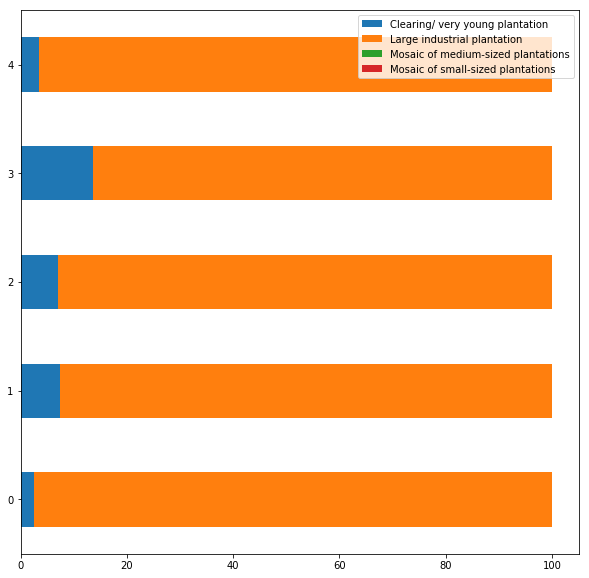

In [162]:
df1.plot.barh(stacked=True,figsize=(10,10),legend=True)

In [163]:
# get admin 1 or 2 level human-readable name info as needed:
adm1_to_name = None
adm2_to_name = None

if adm1:
    
    tmp = get_admin2_json(iso=adm0, adm1=adm1)
    adm2_to_name ={}
    for row in tmp:
        adm2_to_name[row.get('adm2')] = row.get('name')

tmp = get_admin1_json(iso=adm0)
adm1_to_name={}
for row in tmp:
    adm1_to_name[row.get('adm1')] = row.get('name') 

In [164]:
#Dynamic sentence (easier to use sorted_list1)

if adm1:
    print(f"{adm2_to_name[sorted_list1[0].get('region')]} ({extent_year}) has the largest ", end="")
    print(f"relative tree cover due to plantations ({sorted_list1[0].get('perc'):.1f}%) ", end="")
    print(f"in {adm1_to_name[adm1]}, ", end="")
elif adm0: 
    print(f"{adm1_to_name[sorted_list1[0].get('region')]} has the largest ", end="")
    print(f"relative tree cover due to plantations ({sorted_list1[0].get('perc'):.1f}%) ", end="")
    print(f"in {iso_to_countries[adm0]}, ", end="")


print(f"most of which area {plantation_type_dict[sorted_list1[0].get('data')[0][0]]} plantations ", end="")
print(f"where tree canopy is greater than {thresh}% ", end="")

Santa Catarina has the largest relative tree cover due to plantations (13.0%) in Brazil, most of which area large industrial plantations where tree canopy is greater than 0% 

# Ranked Plantations Stacked Barchart (by species)

Displays the Top 5 sub-regions ranked by the % of plantation cover relative to total area, containing tree plantations in a horizontal bar chart. Each bar is broken into the sub-categories (type or species).

Each bar is made up of 4 subcategories that should add to 100%.

Subcategory % calculated by dividing the extent by the total extent of plantations in the region

In [165]:
# VARIABLES

thresh = 0               # 0,10,15,20,25,30,50,75,100 
adm0 = 'BRA'
adm1 = None          
adm2 = None            

extent_year = 2000        #2000 or 2010

tags = ["land_cover", "land_use"]
selectable_polynames = ['gadm28', 'plantations']

In [166]:
# Get the total extent of each region
url = f"https://production-api.globalforestwatch.org/v1/query/{ds}"

sql = multiregion_extent_queries(adm0=adm0, adm1=adm1, p_name='gadm28', threshold=thresh)

properties = {"sql": sql}
r = requests.get(url, params = properties)
print(r.url)
print(f'Status: {r.status_code}')
extent_total = r.json().get('data')
extent_total[0:3]

Request for adm1 areas
https://production-api.globalforestwatch.org/v1/query/499682b1-3174-493f-ba1a-368b4636708e?sql=SELECT+adm1+as+region%2C+sum%28area_extent%29+as+extent%2C+sum%28area_gadm28%29+as+total+FROM+499682b1-3174-493f-ba1a-368b4636708e+WHERE+iso+%3D+%27BRA%27+AND+thresh+%3D+0+AND+polyname+%3D+%27gadm28%27+GROUP+BY+adm1+ORDER+BY+adm1
Status: 200


[{'extent': 14502759.1015625, 'region': 1, 'total': 15273286.984375},
 {'extent': 800115.4713287354, 'region': 2, 'total': 2775822.3068847656},
 {'extent': 12382432.1640625, 'region': 3, 'total': 14221825.859375}]

In [167]:
# Gets plantation areas by species, for each subregion
url = f"https://production-api.globalforestwatch.org/v1/query/{ds}"

sql = (f"SELECT SUM(area_extent) AS plantation_extent FROM {ds} WHERE iso = 'BRA' "
       f"AND thresh = 0 AND polyname = 'plantations' "
       f"GROUP BY adm1, bound2 ORDER BY plantation_extent DESC")

properties = {"sql": sql}
r = requests.get(url, params = properties)
print(r.url)
print(f'Status: {r.status_code}')
plantations_areas = r.json().get('data')
plantations_areas[0:3]

https://production-api.globalforestwatch.org/v1/query/499682b1-3174-493f-ba1a-368b4636708e?sql=SELECT+SUM%28area_extent%29+AS+plantation_extent+FROM+499682b1-3174-493f-ba1a-368b4636708e+WHERE+iso+%3D+%27BRA%27+AND+thresh+%3D+0+AND+polyname+%3D+%27plantations%27+GROUP+BY+adm1%2C+bound2+ORDER+BY+plantation_extent+DESC
Status: 200


[{'adm1': 13,
  'bound2': 'Wood fiber / timber',
  'plantation_extent': 866630.5609202683},
 {'adm1': 13,
  'bound2': 'Recently cleared',
  'plantation_extent': 134288.48072965443},
 {'adm1': 13, 'bound2': 'Fruit', 'plantation_extent': 12757.236675739288}]

In [168]:
#apply function to create json
plantations_json = format_plantations_data(plantations_areas, extent_total, adm0, adm1, 'species')

In [169]:
#Sort regions by % area of plantations (DESC)

sorted_list = sorted(plantations_json, key=lambda k: k['perc'], reverse=True) 
sorted_list[0]

{'data': [['Wood fiber / timber', 895171.1094231904],
  ['Recently cleared', 22645.54149529338]],
 'perc': 13.018225543693056,
 'plantations_total': 917816.6509184837,
 'region': 25,
 'region_total': 7050243.8895225525}

In [170]:
#The following code collects data into the correct groups so that a stacked bar can be implemented
# For each adm region this collects the extents by type and calaculates its percentage relative to 
# total plantation extent

wft = []
wfm = []
rc = []
unk = []
frt = []
frm = []
opt = []
oth = []
otm = []
rub = []

region = []
#we only want the top X to be displayed
max_num = 5


for i in range(0,max_num):
    
    length = len(sorted_list[i].get('data'))
    region.append(str(sorted_list[i].get('region')))
    flag = 0
    
    for j in range(0,length):
        
        if sorted_list[i].get('data')[j][0] =='Wood fiber / timber':
            wft.append(100 * sorted_list[i].get('data')[j][1] / sorted_list[i].get('plantations_total'))
            break
        elif flag == length-1:
            wft.append(0)
        else:
            flag += 1
    flag = 0
    for j in range(0,length):
        
        if sorted_list[i].get('data')[j][0] =='Wood fiber / timber mix':
            wfm.append(100 * sorted_list[i].get('data')[j][1] / sorted_list[i].get('plantations_total'))
            break
        elif flag == length-1:
            wfm.append(0)
        else:
            flag += 1
    flag = 0        
    for j in range(0,length):
        
        if sorted_list[i].get('data')[j][0] =='Recently cleared':
            rc.append(100 * sorted_list[i].get('data')[j][1] / sorted_list[i].get('plantations_total'))
            break
        elif flag == length-1:
            rc.append(0)
        else:
            flag += 1
    flag = 0
    for j in range(0,length):
        
        if sorted_list[i].get('data')[j][0] =='Unknown':
            unk.append(100 * sorted_list[i].get('data')[j][1] / sorted_list[i].get('plantations_total'))
            break
        elif flag == length-1:
            unk.append(0)
        else:
            flag += 1
    flag = 0        
    for j in range(0,length):
        
        if sorted_list[i].get('data')[j][0] =='Fruit':
            frt.append(100 * sorted_list[i].get('data')[j][1] / sorted_list[i].get('plantations_total'))
            break
        elif flag == length-1:
            frt.append(0)
        else:
            flag += 1
    flag = 0
    for j in range(0,length):
        
        if sorted_list[i].get('data')[j][0] =='Fruit mix':
            frm.append(100 * sorted_list[i].get('data')[j][1] / sorted_list[i].get('plantations_total'))
            break
        elif flag == length-1:
            frm.append(0)
        else:
            flag += 1
    flag = 0        
    for j in range(0,length):
        
        if sorted_list[i].get('data')[j][0] =='Oil palm':
            opt.append(100 * sorted_list[i].get('data')[j][1] / sorted_list[i].get('plantations_total'))
            break
        elif flag == length-1:
            opt.append(0)
        else:
            flag += 1
    flag = 0
    for j in range(0,length):
        
        if sorted_list[i].get('data')[j][0] =='Other mix':
            otm.append(100 * sorted_list[i].get('data')[j][1] / sorted_list[i].get('plantations_total'))
            break
        elif flag == length-1:
            otm.append(0)
        else:
            flag += 1
    flag = 0
    for j in range(0,length):
        
        if sorted_list[i].get('data')[j][0] =='Other':
            oth.append(100 * sorted_list[i].get('data')[j][1] / sorted_list[i].get('plantations_total'))
            break
        elif flag == length-1:
            oth.append(0)
        else:
            flag += 1
    flag = 0
    for j in range(0,length):
        
        if sorted_list[i].get('data')[j][0] =='Rubber':
            rub.append(100 * sorted_list[i].get('data')[j][1] / sorted_list[i].get('plantations_total'))
            break
        elif flag == length-1:
            rub.append(0)
        else:
            flag += 1
            

In [171]:
#Prepare data to be visualised with pandas
d = {
    'Wood Fiber and Timber': wft,
    'Wood Fibre and Timber mix': wfm,
    'Recently Cleared': rc,
    'Unknown': unk,
    'Fruit Trees': frt,
    'Fruit Tree mix': frm,
    'Oil Palm': opt,
    'Other mix': otm,
    'Other': oth,
    'Rubber Trees': rub
    
}

In [172]:
#Creates dataframe to visualise data
df = pd.DataFrame(data=d)
df

Fruit Tree mix  Fruit Trees  Oil Palm  Other  Other mix  Recently Cleared  \
0               0     0.000000         0      0   0.000000          2.467327   
1               0     0.068368         0      0   0.000000          7.332298   
2               0     0.579796         0      0   6.746915          6.973439   
3               0     0.000000         0      0   0.000000         13.693243   
4               0     0.000000         0      0   0.000000          3.530766   

   Rubber Trees   Unknown  Wood Fiber and Timber  Wood Fibre and Timber mix  
0      0.000000  0.000000              97.532673                          0  
1      0.000000  0.146110              92.453224                          0  
2      1.498479  0.041432              84.159938                          0  
3      0.000000  0.000000              86.306757                          0  
4      0.000000  0.184963              96.284270                          0

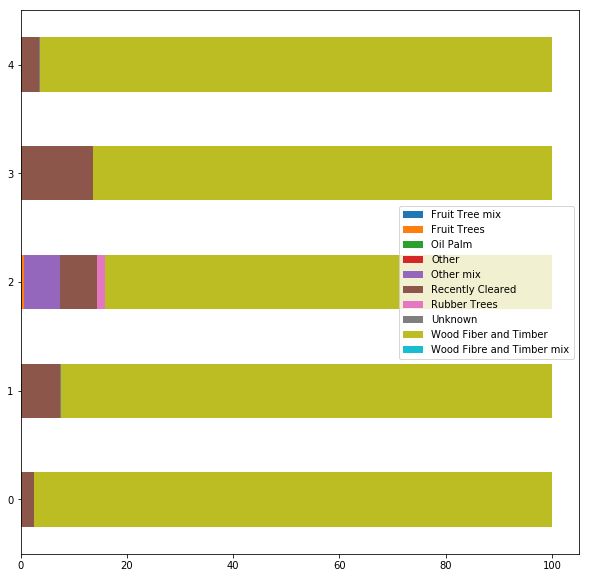

In [173]:
df.plot.barh(stacked=True,figsize=(10,10),legend=True)

In [174]:
# get admin 1 or 2 level human-readable name info as needed:
adm1_to_name = None
adm2_to_name = None

if adm1:
    
    tmp = get_admin2_json(iso=adm0, adm1=adm1)
    adm2_to_name ={}
    for row in tmp:
        adm2_to_name[row.get('adm2')] = row.get('name')

tmp = get_admin1_json(iso=adm0)
adm1_to_name={}
for row in tmp:
    adm1_to_name[row.get('adm1')] = row.get('name') 

In [175]:
#Dynamic sentence (easier to use sorted list)

if adm1:
    print(f"{adm2_to_name[sorted_list[0].get('region')]} ({extent_year}) has the largest ", end="")
    print(f"relative tree cover due to plantations ({sorted_list[0].get('perc'):.1f}%) ", end="")
    print(f"in {adm1_to_name[adm1]}, ", end="")
elif adm0: 
    print(f"{adm1_to_name[sorted_list[0].get('region')]} has the largest ", end="")
    print(f"relative tree cover due to plantations ({sorted_list[0].get('perc'):.1f}%) ", end="")
    print(f"in {iso_to_countries[adm0]}, ", end="")


print(f"most of which is used for {plantation_species_dict[sorted_list[0].get('data')[0][0]]} ", end="")
print(f"where tree canopy is greater than {thresh}% ", end="")

Santa Catarina has the largest relative tree cover due to plantations (13.0%) in Brazil, most of which is used for wood fiber and timber where tree canopy is greater than 0% 